<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init" data-toc-modified-id="Init-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Conf" data-toc-modified-id="Conf-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Conf</a></span></li></ul></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Algorithm" data-toc-modified-id="Algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Algorithm</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Visualization" data-toc-modified-id="Visualization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Visualization</a></span></li></ul></li></ul></div>

## Init

### Imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from blist import sortedlist
from collections import deque

### Conf

In [2]:
ROOT_PATH = 'data/'

DATA_PATH = ROOT_PATH+'2019-2021_1m_ohlcv.csv'
RESULTS_PATH = ROOT_PATH+'result.csv'

## Load data

In [3]:
raw_data_df = pd.read_csv(DATA_PATH)

raw_data_df

,exchange,symbol,open_time,open,high,low,close,volume
0,Binance,BTC/USDT,1546300800000,3701.23,3703.72,3701.09,3702.46,17.100110
1,Binance,BTC/USDT,1546300860000,3702.44,3702.63,3695.66,3697.04,23.700604
2,Binance,BTC/USDT,1546300920000,3699.42,3702.04,3696.08,3698.14,14.488615
3,Binance,BTC/USDT,1546300980000,3697.49,3698.19,3695.97,3696.51,8.499966
4,Binance,BTC/USDT,1546301040000,3697.20,3697.62,3695.00,3696.32,21.782886
...,...,...,...,...,...,...,...,...
1050995,Binance,BTC/USDT,1609478460000,29144.32,29154.91,29144.31,29154.48,10.299769
1050996,Binance,BTC/USDT,1609478520000,29154.49,29159.09,29148.33,29149.76,9.180320
1050997,Binance,BTC/USDT,1609478580000,29149.76,29154.00,29148.97,29151.54,11.870330
1050998,Binance,BTC/USDT,1609478640000,29151.54,29175.47,29151.53,29163.01,17.893775


## Algorithm

In [10]:
def add_alpha(data_df, lookup):
    price_list = list(data_df['close'])
    alpha_list = []
    window = deque()
    sorted_window = sortedlist() # keeps sorted prices in binary search tree for speed up

    for idx, price in enumerate(price_list):
        window.append(price)
        sorted_window.add(price)
        if len(window) <= lookup:
            continue
        old_price = window.popleft()
        sorted_window.remove(old_price)

        alpha = (sorted_window.index(price) + sorted_window.count(price) - 1) / len(window)
        alpha_list.append(alpha)   

    data_df['alpha'] = [-1]*lookup + alpha_list

    return data_df

def add_signal(data_df, buy_alpha, sell_alpha):
    signal_list = []

    for alpha in list(data_df['alpha']):
        if alpha >= buy_alpha:
            signal_list.append(1) # buy
        elif alpha < sell_alpha:
            signal_list.append(-1) # sell
        else:
            signal_list.append(0)

    last_signal = -1
    for idx, signal in enumerate(signal_list):
        if signal == -last_signal:
            last_signal = signal
        else:
            signal_list[idx] = 0

    data_df['signal'] = signal_list

    return data_df

def evaluation(data_df):
    signals = list(data_df[data_df['signal'] != 0]['close'])
    if signals[0] == -1:
        signals = signals[1:]
    money = 100
    bets = (len(signals)-1)/2
    posetives = 0
    i = 0
    while i + 1 < len(signals):
        if (signals[i + 1] / signals[i]) > 1 : posetives += 1
        money *= signals[i + 1] / signals[i] * 0.999
        i += 2
    return (round(money/100, 3), round(posetives/bets, 3), bets)

## Simulation

In [16]:
LOOKUP = [60*24, 60*24*5, 60*24*10, 60*24*20]
BUY_ALPHA = [i/100 for i in range(1, 100)]
SELL_ALPHA = [i/100 for i in range(1, 100)]

algorithm = []

for lookup in LOOKUP:
    data_df = raw_data_df.copy()
    data_df = add_alpha(data_df, lookup)

    for buy_alpha in BUY_ALPHA:
        for sell_alpha in SELL_ALPHA:
            res = evaluation(add_signal(data_df, buy_alpha, sell_alpha))
            
            if res[0] < 0.5: break
            algorithm.append({
                'lookup' : lookup,
                'buy_alpha' : buy_alpha,
                'sell_alpha' : sell_alpha,
                'money' : res[0],
                'bets' : res[2],
                'acc' : res[1]
            })

            print(algorithm[-1])

{'lookup': 1440, 'buy_alpha': 0.03, 'sell_alpha': 0.01, 'money': 0.924, 'bets': 2140.0, 'acc': 0.114}
{'lookup': 1440, 'buy_alpha': 0.04, 'sell_alpha': 0.01, 'money': 1.396, 'bets': 1775.0, 'acc': 0.133}
{'lookup': 1440, 'buy_alpha': 0.05, 'sell_alpha': 0.01, 'money': 1.734, 'bets': 1555.0, 'acc': 0.148}
{'lookup': 1440, 'buy_alpha': 0.05, 'sell_alpha': 0.02, 'money': 0.794, 'bets': 2281.0, 'acc': 0.112}
{'lookup': 1440, 'buy_alpha': 0.06, 'sell_alpha': 0.01, 'money': 2.209, 'bets': 1383.0, 'acc': 0.161}
{'lookup': 1440, 'buy_alpha': 0.06, 'sell_alpha': 0.02, 'money': 1.184, 'bets': 1962.0, 'acc': 0.127}
{'lookup': 1440, 'buy_alpha': 0.07, 'sell_alpha': 0.01, 'money': 2.606, 'bets': 1263.0, 'acc': 0.171}
{'lookup': 1440, 'buy_alpha': 0.07, 'sell_alpha': 0.02, 'money': 1.492, 'bets': 1751.0, 'acc': 0.134}
{'lookup': 1440, 'buy_alpha': 0.07, 'sell_alpha': 0.03, 'money': 0.757, 'bets': 2286.0, 'acc': 0.111}
{'lookup': 1440, 'buy_alpha': 0.08, 'sell_alpha': 0.01, 'money': 2.696, 'bets': 11

{'lookup': 1440, 'buy_alpha': 0.2, 'sell_alpha': 0.02, 'money': 3.421, 'bets': 859.0, 'acc': 0.221}
{'lookup': 1440, 'buy_alpha': 0.2, 'sell_alpha': 0.03, 'money': 2.927, 'bets': 992.0, 'acc': 0.2}
{'lookup': 1440, 'buy_alpha': 0.2, 'sell_alpha': 0.04, 'money': 2.041, 'bets': 1137.0, 'acc': 0.184}
{'lookup': 1440, 'buy_alpha': 0.2, 'sell_alpha': 0.05, 'money': 1.8, 'bets': 1288.0, 'acc': 0.171}
{'lookup': 1440, 'buy_alpha': 0.2, 'sell_alpha': 0.06, 'money': 1.302, 'bets': 1467.0, 'acc': 0.152}
{'lookup': 1440, 'buy_alpha': 0.2, 'sell_alpha': 0.07, 'money': 1.141, 'bets': 1604.0, 'acc': 0.143}
{'lookup': 1440, 'buy_alpha': 0.2, 'sell_alpha': 0.08, 'money': 0.808, 'bets': 1807.0, 'acc': 0.132}
{'lookup': 1440, 'buy_alpha': 0.2, 'sell_alpha': 0.09, 'money': 0.663, 'bets': 1996.0, 'acc': 0.125}
{'lookup': 1440, 'buy_alpha': 0.2, 'sell_alpha': 0.1, 'money': 0.5, 'bets': 2211.0, 'acc': 0.119}
{'lookup': 1440, 'buy_alpha': 0.21, 'sell_alpha': 0.01, 'money': 4.526, 'bets': 697.0, 'acc': 0.253}

{'lookup': 1440, 'buy_alpha': 0.27, 'sell_alpha': 0.04, 'money': 3.096, 'bets': 897.0, 'acc': 0.206}
{'lookup': 1440, 'buy_alpha': 0.27, 'sell_alpha': 0.05, 'money': 2.912, 'bets': 995.0, 'acc': 0.196}
{'lookup': 1440, 'buy_alpha': 0.27, 'sell_alpha': 0.06, 'money': 2.247, 'bets': 1113.0, 'acc': 0.183}
{'lookup': 1440, 'buy_alpha': 0.27, 'sell_alpha': 0.07, 'money': 2.034, 'bets': 1192.0, 'acc': 0.173}
{'lookup': 1440, 'buy_alpha': 0.27, 'sell_alpha': 0.08, 'money': 1.561, 'bets': 1314.0, 'acc': 0.163}
{'lookup': 1440, 'buy_alpha': 0.27, 'sell_alpha': 0.09, 'money': 1.443, 'bets': 1414.0, 'acc': 0.153}
{'lookup': 1440, 'buy_alpha': 0.27, 'sell_alpha': 0.1, 'money': 1.162, 'bets': 1537.0, 'acc': 0.146}
{'lookup': 1440, 'buy_alpha': 0.27, 'sell_alpha': 0.11, 'money': 0.986, 'bets': 1682.0, 'acc': 0.141}
{'lookup': 1440, 'buy_alpha': 0.27, 'sell_alpha': 0.12, 'money': 0.721, 'bets': 1828.0, 'acc': 0.131}
{'lookup': 1440, 'buy_alpha': 0.28, 'sell_alpha': 0.01, 'money': 5.191, 'bets': 596.0

{'lookup': 1440, 'buy_alpha': 0.33, 'sell_alpha': 0.05, 'money': 3.838, 'bets': 834.0, 'acc': 0.219}
{'lookup': 1440, 'buy_alpha': 0.33, 'sell_alpha': 0.06, 'money': 3.091, 'bets': 921.0, 'acc': 0.208}
{'lookup': 1440, 'buy_alpha': 0.33, 'sell_alpha': 0.07, 'money': 2.937, 'bets': 974.0, 'acc': 0.2}
{'lookup': 1440, 'buy_alpha': 0.33, 'sell_alpha': 0.08, 'money': 2.351, 'bets': 1063.0, 'acc': 0.191}
{'lookup': 1440, 'buy_alpha': 0.33, 'sell_alpha': 0.09, 'money': 2.163, 'bets': 1138.0, 'acc': 0.18}
{'lookup': 1440, 'buy_alpha': 0.33, 'sell_alpha': 0.1, 'money': 1.798, 'bets': 1225.0, 'acc': 0.173}
{'lookup': 1440, 'buy_alpha': 0.33, 'sell_alpha': 0.11, 'money': 1.671, 'bets': 1312.0, 'acc': 0.162}
{'lookup': 1440, 'buy_alpha': 0.33, 'sell_alpha': 0.12, 'money': 1.245, 'bets': 1417.0, 'acc': 0.15}
{'lookup': 1440, 'buy_alpha': 0.33, 'sell_alpha': 0.13, 'money': 0.909, 'bets': 1524.0, 'acc': 0.145}
{'lookup': 1440, 'buy_alpha': 0.33, 'sell_alpha': 0.14, 'money': 0.798, 'bets': 1638.0, 'a

{'lookup': 1440, 'buy_alpha': 0.38, 'sell_alpha': 0.07, 'money': 3.051, 'bets': 855.0, 'acc': 0.214}
{'lookup': 1440, 'buy_alpha': 0.38, 'sell_alpha': 0.08, 'money': 2.559, 'bets': 926.0, 'acc': 0.207}
{'lookup': 1440, 'buy_alpha': 0.38, 'sell_alpha': 0.09, 'money': 2.357, 'bets': 986.0, 'acc': 0.198}
{'lookup': 1440, 'buy_alpha': 0.38, 'sell_alpha': 0.1, 'money': 2.006, 'bets': 1058.0, 'acc': 0.188}
{'lookup': 1440, 'buy_alpha': 0.38, 'sell_alpha': 0.11, 'money': 1.786, 'bets': 1134.0, 'acc': 0.177}
{'lookup': 1440, 'buy_alpha': 0.38, 'sell_alpha': 0.12, 'money': 1.376, 'bets': 1211.0, 'acc': 0.168}
{'lookup': 1440, 'buy_alpha': 0.38, 'sell_alpha': 0.13, 'money': 0.994, 'bets': 1295.0, 'acc': 0.161}
{'lookup': 1440, 'buy_alpha': 0.38, 'sell_alpha': 0.14, 'money': 0.924, 'bets': 1373.0, 'acc': 0.157}
{'lookup': 1440, 'buy_alpha': 0.38, 'sell_alpha': 0.15, 'money': 0.794, 'bets': 1451.0, 'acc': 0.152}
{'lookup': 1440, 'buy_alpha': 0.38, 'sell_alpha': 0.16, 'money': 0.64, 'bets': 1553.0,

{'lookup': 1440, 'buy_alpha': 0.42, 'sell_alpha': 0.18, 'money': 0.57, 'bets': 1506.0, 'acc': 0.148}
{'lookup': 1440, 'buy_alpha': 0.42, 'sell_alpha': 0.19, 'money': 0.542, 'bets': 1577.0, 'acc': 0.143}
{'lookup': 1440, 'buy_alpha': 0.42, 'sell_alpha': 0.2, 'money': 0.508, 'bets': 1648.0, 'acc': 0.14}
{'lookup': 1440, 'buy_alpha': 0.43, 'sell_alpha': 0.01, 'money': 4.784, 'bets': 483.0, 'acc': 0.315}
{'lookup': 1440, 'buy_alpha': 0.43, 'sell_alpha': 0.02, 'money': 4.491, 'bets': 544.0, 'acc': 0.29}
{'lookup': 1440, 'buy_alpha': 0.43, 'sell_alpha': 0.03, 'money': 4.281, 'bets': 593.0, 'acc': 0.27}
{'lookup': 1440, 'buy_alpha': 0.43, 'sell_alpha': 0.04, 'money': 3.682, 'bets': 643.0, 'acc': 0.26}
{'lookup': 1440, 'buy_alpha': 0.43, 'sell_alpha': 0.05, 'money': 3.598, 'bets': 688.0, 'acc': 0.251}
{'lookup': 1440, 'buy_alpha': 0.43, 'sell_alpha': 0.06, 'money': 2.961, 'bets': 751.0, 'acc': 0.236}
{'lookup': 1440, 'buy_alpha': 0.43, 'sell_alpha': 0.07, 'money': 2.994, 'bets': 779.0, 'acc': 

{'lookup': 1440, 'buy_alpha': 0.46, 'sell_alpha': 0.2, 'money': 0.623, 'bets': 1429.0, 'acc': 0.153}
{'lookup': 1440, 'buy_alpha': 0.46, 'sell_alpha': 0.21, 'money': 0.532, 'bets': 1504.0, 'acc': 0.148}
{'lookup': 1440, 'buy_alpha': 0.47, 'sell_alpha': 0.01, 'money': 5.399, 'bets': 453.0, 'acc': 0.325}
{'lookup': 1440, 'buy_alpha': 0.47, 'sell_alpha': 0.02, 'money': 4.869, 'bets': 510.0, 'acc': 0.304}
{'lookup': 1440, 'buy_alpha': 0.47, 'sell_alpha': 0.03, 'money': 4.855, 'bets': 548.0, 'acc': 0.288}
{'lookup': 1440, 'buy_alpha': 0.47, 'sell_alpha': 0.04, 'money': 4.141, 'bets': 592.0, 'acc': 0.279}
{'lookup': 1440, 'buy_alpha': 0.47, 'sell_alpha': 0.05, 'money': 4.067, 'bets': 632.0, 'acc': 0.267}
{'lookup': 1440, 'buy_alpha': 0.47, 'sell_alpha': 0.06, 'money': 3.435, 'bets': 687.0, 'acc': 0.247}
{'lookup': 1440, 'buy_alpha': 0.47, 'sell_alpha': 0.07, 'money': 3.48, 'bets': 711.0, 'acc': 0.241}
{'lookup': 1440, 'buy_alpha': 0.47, 'sell_alpha': 0.08, 'money': 3.011, 'bets': 760.0, 'acc

{'lookup': 1440, 'buy_alpha': 0.5, 'sell_alpha': 0.14, 'money': 1.367, 'bets': 995.0, 'acc': 0.193}
{'lookup': 1440, 'buy_alpha': 0.5, 'sell_alpha': 0.15, 'money': 1.28, 'bets': 1037.0, 'acc': 0.188}
{'lookup': 1440, 'buy_alpha': 0.5, 'sell_alpha': 0.16, 'money': 1.136, 'bets': 1092.0, 'acc': 0.179}
{'lookup': 1440, 'buy_alpha': 0.5, 'sell_alpha': 0.17, 'money': 1.186, 'bets': 1125.0, 'acc': 0.177}
{'lookup': 1440, 'buy_alpha': 0.5, 'sell_alpha': 0.18, 'money': 1.063, 'bets': 1165.0, 'acc': 0.175}
{'lookup': 1440, 'buy_alpha': 0.5, 'sell_alpha': 0.19, 'money': 1.069, 'bets': 1206.0, 'acc': 0.172}
{'lookup': 1440, 'buy_alpha': 0.5, 'sell_alpha': 0.2, 'money': 1.004, 'bets': 1252.0, 'acc': 0.167}
{'lookup': 1440, 'buy_alpha': 0.5, 'sell_alpha': 0.21, 'money': 0.866, 'bets': 1314.0, 'acc': 0.161}
{'lookup': 1440, 'buy_alpha': 0.5, 'sell_alpha': 0.22, 'money': 0.734, 'bets': 1372.0, 'acc': 0.154}
{'lookup': 1440, 'buy_alpha': 0.5, 'sell_alpha': 0.23, 'money': 0.654, 'bets': 1435.0, 'acc': 

{'lookup': 1440, 'buy_alpha': 0.53, 'sell_alpha': 0.18, 'money': 1.486, 'bets': 1047.0, 'acc': 0.188}
{'lookup': 1440, 'buy_alpha': 0.53, 'sell_alpha': 0.19, 'money': 1.45, 'bets': 1086.0, 'acc': 0.184}
{'lookup': 1440, 'buy_alpha': 0.53, 'sell_alpha': 0.2, 'money': 1.328, 'bets': 1129.0, 'acc': 0.18}
{'lookup': 1440, 'buy_alpha': 0.53, 'sell_alpha': 0.21, 'money': 1.171, 'bets': 1178.0, 'acc': 0.177}
{'lookup': 1440, 'buy_alpha': 0.53, 'sell_alpha': 0.22, 'money': 1.066, 'bets': 1224.0, 'acc': 0.17}
{'lookup': 1440, 'buy_alpha': 0.53, 'sell_alpha': 0.23, 'money': 0.934, 'bets': 1282.0, 'acc': 0.166}
{'lookup': 1440, 'buy_alpha': 0.53, 'sell_alpha': 0.24, 'money': 0.83, 'bets': 1343.0, 'acc': 0.16}
{'lookup': 1440, 'buy_alpha': 0.53, 'sell_alpha': 0.25, 'money': 0.728, 'bets': 1397.0, 'acc': 0.159}
{'lookup': 1440, 'buy_alpha': 0.53, 'sell_alpha': 0.26, 'money': 0.697, 'bets': 1458.0, 'acc': 0.152}
{'lookup': 1440, 'buy_alpha': 0.53, 'sell_alpha': 0.27, 'money': 0.585, 'bets': 1529.0, 

{'lookup': 1440, 'buy_alpha': 0.56, 'sell_alpha': 0.11, 'money': 3.712, 'bets': 738.0, 'acc': 0.244}
{'lookup': 1440, 'buy_alpha': 0.56, 'sell_alpha': 0.12, 'money': 3.074, 'bets': 772.0, 'acc': 0.233}
{'lookup': 1440, 'buy_alpha': 0.56, 'sell_alpha': 0.13, 'money': 2.291, 'bets': 811.0, 'acc': 0.223}
{'lookup': 1440, 'buy_alpha': 0.56, 'sell_alpha': 0.14, 'money': 2.247, 'bets': 839.0, 'acc': 0.216}
{'lookup': 1440, 'buy_alpha': 0.56, 'sell_alpha': 0.15, 'money': 2.137, 'bets': 869.0, 'acc': 0.209}
{'lookup': 1440, 'buy_alpha': 0.56, 'sell_alpha': 0.16, 'money': 1.941, 'bets': 908.0, 'acc': 0.202}
{'lookup': 1440, 'buy_alpha': 0.56, 'sell_alpha': 0.17, 'money': 2.006, 'bets': 931.0, 'acc': 0.202}
{'lookup': 1440, 'buy_alpha': 0.56, 'sell_alpha': 0.18, 'money': 1.796, 'bets': 959.0, 'acc': 0.201}
{'lookup': 1440, 'buy_alpha': 0.56, 'sell_alpha': 0.19, 'money': 1.733, 'bets': 994.0, 'acc': 0.199}
{'lookup': 1440, 'buy_alpha': 0.56, 'sell_alpha': 0.2, 'money': 1.611, 'bets': 1030.0, 'acc

{'lookup': 1440, 'buy_alpha': 0.58, 'sell_alpha': 0.27, 'money': 0.873, 'bets': 1274.0, 'acc': 0.166}
{'lookup': 1440, 'buy_alpha': 0.58, 'sell_alpha': 0.28, 'money': 0.887, 'bets': 1316.0, 'acc': 0.163}
{'lookup': 1440, 'buy_alpha': 0.58, 'sell_alpha': 0.29, 'money': 0.767, 'bets': 1365.0, 'acc': 0.161}
{'lookup': 1440, 'buy_alpha': 0.58, 'sell_alpha': 0.3, 'money': 0.752, 'bets': 1413.0, 'acc': 0.159}
{'lookup': 1440, 'buy_alpha': 0.58, 'sell_alpha': 0.31, 'money': 0.664, 'bets': 1481.0, 'acc': 0.153}
{'lookup': 1440, 'buy_alpha': 0.58, 'sell_alpha': 0.32, 'money': 0.619, 'bets': 1542.0, 'acc': 0.15}
{'lookup': 1440, 'buy_alpha': 0.58, 'sell_alpha': 0.33, 'money': 0.543, 'bets': 1610.0, 'acc': 0.147}
{'lookup': 1440, 'buy_alpha': 0.58, 'sell_alpha': 0.34, 'money': 0.521, 'bets': 1670.0, 'acc': 0.142}
{'lookup': 1440, 'buy_alpha': 0.59, 'sell_alpha': 0.01, 'money': 7.495, 'bets': 397.0, 'acc': 0.34}
{'lookup': 1440, 'buy_alpha': 0.59, 'sell_alpha': 0.02, 'money': 6.585, 'bets': 440.0,

{'lookup': 1440, 'buy_alpha': 0.61, 'sell_alpha': 0.03, 'money': 6.366, 'bets': 458.0, 'acc': 0.308}
{'lookup': 1440, 'buy_alpha': 0.61, 'sell_alpha': 0.04, 'money': 5.717, 'bets': 482.0, 'acc': 0.303}
{'lookup': 1440, 'buy_alpha': 0.61, 'sell_alpha': 0.05, 'money': 5.413, 'bets': 509.0, 'acc': 0.295}
{'lookup': 1440, 'buy_alpha': 0.61, 'sell_alpha': 0.06, 'money': 5.037, 'bets': 542.0, 'acc': 0.286}
{'lookup': 1440, 'buy_alpha': 0.61, 'sell_alpha': 0.07, 'money': 4.986, 'bets': 557.0, 'acc': 0.278}
{'lookup': 1440, 'buy_alpha': 0.61, 'sell_alpha': 0.08, 'money': 4.543, 'bets': 588.0, 'acc': 0.276}
{'lookup': 1440, 'buy_alpha': 0.61, 'sell_alpha': 0.09, 'money': 4.545, 'bets': 608.0, 'acc': 0.271}
{'lookup': 1440, 'buy_alpha': 0.61, 'sell_alpha': 0.1, 'money': 3.779, 'bets': 642.0, 'acc': 0.259}
{'lookup': 1440, 'buy_alpha': 0.61, 'sell_alpha': 0.11, 'money': 3.766, 'bets': 671.0, 'acc': 0.255}
{'lookup': 1440, 'buy_alpha': 0.61, 'sell_alpha': 0.12, 'money': 3.185, 'bets': 699.0, 'acc'

{'lookup': 1440, 'buy_alpha': 0.63, 'sell_alpha': 0.12, 'money': 3.067, 'bets': 676.0, 'acc': 0.244}
{'lookup': 1440, 'buy_alpha': 0.63, 'sell_alpha': 0.13, 'money': 2.24, 'bets': 707.0, 'acc': 0.233}
{'lookup': 1440, 'buy_alpha': 0.63, 'sell_alpha': 0.14, 'money': 2.224, 'bets': 728.0, 'acc': 0.227}
{'lookup': 1440, 'buy_alpha': 0.63, 'sell_alpha': 0.15, 'money': 2.214, 'bets': 745.0, 'acc': 0.223}
{'lookup': 1440, 'buy_alpha': 0.63, 'sell_alpha': 0.16, 'money': 2.043, 'bets': 776.0, 'acc': 0.216}
{'lookup': 1440, 'buy_alpha': 0.63, 'sell_alpha': 0.17, 'money': 2.133, 'bets': 791.0, 'acc': 0.217}
{'lookup': 1440, 'buy_alpha': 0.63, 'sell_alpha': 0.18, 'money': 1.876, 'bets': 813.0, 'acc': 0.216}
{'lookup': 1440, 'buy_alpha': 0.63, 'sell_alpha': 0.19, 'money': 1.781, 'bets': 843.0, 'acc': 0.21}
{'lookup': 1440, 'buy_alpha': 0.63, 'sell_alpha': 0.2, 'money': 1.649, 'bets': 871.0, 'acc': 0.208}
{'lookup': 1440, 'buy_alpha': 0.63, 'sell_alpha': 0.21, 'money': 1.587, 'bets': 898.0, 'acc': 

{'lookup': 1440, 'buy_alpha': 0.65, 'sell_alpha': 0.18, 'money': 1.874, 'bets': 783.0, 'acc': 0.22}
{'lookup': 1440, 'buy_alpha': 0.65, 'sell_alpha': 0.19, 'money': 1.801, 'bets': 809.0, 'acc': 0.215}
{'lookup': 1440, 'buy_alpha': 0.65, 'sell_alpha': 0.2, 'money': 1.674, 'bets': 835.0, 'acc': 0.213}
{'lookup': 1440, 'buy_alpha': 0.65, 'sell_alpha': 0.21, 'money': 1.6, 'bets': 862.0, 'acc': 0.21}
{'lookup': 1440, 'buy_alpha': 0.65, 'sell_alpha': 0.22, 'money': 1.498, 'bets': 890.0, 'acc': 0.203}
{'lookup': 1440, 'buy_alpha': 0.65, 'sell_alpha': 0.23, 'money': 1.358, 'bets': 922.0, 'acc': 0.2}
{'lookup': 1440, 'buy_alpha': 0.65, 'sell_alpha': 0.24, 'money': 1.302, 'bets': 952.0, 'acc': 0.195}
{'lookup': 1440, 'buy_alpha': 0.65, 'sell_alpha': 0.25, 'money': 1.175, 'bets': 980.0, 'acc': 0.19}
{'lookup': 1440, 'buy_alpha': 0.65, 'sell_alpha': 0.26, 'money': 1.2, 'bets': 1003.0, 'acc': 0.186}
{'lookup': 1440, 'buy_alpha': 0.65, 'sell_alpha': 0.27, 'money': 1.137, 'bets': 1035.0, 'acc': 0.185

{'lookup': 1440, 'buy_alpha': 0.67, 'sell_alpha': 0.22, 'money': 1.748, 'bets': 846.0, 'acc': 0.208}
{'lookup': 1440, 'buy_alpha': 0.67, 'sell_alpha': 0.23, 'money': 1.614, 'bets': 875.0, 'acc': 0.203}
{'lookup': 1440, 'buy_alpha': 0.67, 'sell_alpha': 0.24, 'money': 1.517, 'bets': 905.0, 'acc': 0.201}
{'lookup': 1440, 'buy_alpha': 0.67, 'sell_alpha': 0.25, 'money': 1.364, 'bets': 931.0, 'acc': 0.195}
{'lookup': 1440, 'buy_alpha': 0.67, 'sell_alpha': 0.26, 'money': 1.43, 'bets': 950.0, 'acc': 0.193}
{'lookup': 1440, 'buy_alpha': 0.67, 'sell_alpha': 0.27, 'money': 1.35, 'bets': 980.0, 'acc': 0.192}
{'lookup': 1440, 'buy_alpha': 0.67, 'sell_alpha': 0.28, 'money': 1.442, 'bets': 1003.0, 'acc': 0.19}
{'lookup': 1440, 'buy_alpha': 0.67, 'sell_alpha': 0.29, 'money': 1.276, 'bets': 1034.0, 'acc': 0.191}
{'lookup': 1440, 'buy_alpha': 0.67, 'sell_alpha': 0.3, 'money': 1.24, 'bets': 1069.0, 'acc': 0.188}
{'lookup': 1440, 'buy_alpha': 0.67, 'sell_alpha': 0.31, 'money': 1.224, 'bets': 1101.0, 'acc'

{'lookup': 1440, 'buy_alpha': 0.69, 'sell_alpha': 0.21, 'money': 1.983, 'bets': 782.0, 'acc': 0.219}
{'lookup': 1440, 'buy_alpha': 0.69, 'sell_alpha': 0.22, 'money': 1.823, 'bets': 808.0, 'acc': 0.212}
{'lookup': 1440, 'buy_alpha': 0.69, 'sell_alpha': 0.23, 'money': 1.666, 'bets': 837.0, 'acc': 0.209}
{'lookup': 1440, 'buy_alpha': 0.69, 'sell_alpha': 0.24, 'money': 1.554, 'bets': 866.0, 'acc': 0.204}
{'lookup': 1440, 'buy_alpha': 0.69, 'sell_alpha': 0.25, 'money': 1.375, 'bets': 891.0, 'acc': 0.2}
{'lookup': 1440, 'buy_alpha': 0.69, 'sell_alpha': 0.26, 'money': 1.449, 'bets': 909.0, 'acc': 0.197}
{'lookup': 1440, 'buy_alpha': 0.69, 'sell_alpha': 0.27, 'money': 1.413, 'bets': 934.0, 'acc': 0.197}
{'lookup': 1440, 'buy_alpha': 0.69, 'sell_alpha': 0.28, 'money': 1.524, 'bets': 954.0, 'acc': 0.196}
{'lookup': 1440, 'buy_alpha': 0.69, 'sell_alpha': 0.29, 'money': 1.343, 'bets': 983.0, 'acc': 0.194}
{'lookup': 1440, 'buy_alpha': 0.69, 'sell_alpha': 0.3, 'money': 1.325, 'bets': 1016.0, 'acc':

{'lookup': 1440, 'buy_alpha': 0.71, 'sell_alpha': 0.17, 'money': 2.654, 'bets': 676.0, 'acc': 0.238}
{'lookup': 1440, 'buy_alpha': 0.71, 'sell_alpha': 0.18, 'money': 2.372, 'bets': 689.0, 'acc': 0.239}
{'lookup': 1440, 'buy_alpha': 0.71, 'sell_alpha': 0.19, 'money': 2.332, 'bets': 708.0, 'acc': 0.234}
{'lookup': 1440, 'buy_alpha': 0.71, 'sell_alpha': 0.2, 'money': 2.212, 'bets': 729.0, 'acc': 0.23}
{'lookup': 1440, 'buy_alpha': 0.71, 'sell_alpha': 0.21, 'money': 2.242, 'bets': 744.0, 'acc': 0.227}
{'lookup': 1440, 'buy_alpha': 0.71, 'sell_alpha': 0.22, 'money': 2.067, 'bets': 768.0, 'acc': 0.22}
{'lookup': 1440, 'buy_alpha': 0.71, 'sell_alpha': 0.23, 'money': 1.9, 'bets': 794.0, 'acc': 0.217}
{'lookup': 1440, 'buy_alpha': 0.71, 'sell_alpha': 0.24, 'money': 1.779, 'bets': 819.0, 'acc': 0.212}
{'lookup': 1440, 'buy_alpha': 0.71, 'sell_alpha': 0.25, 'money': 1.566, 'bets': 843.0, 'acc': 0.206}
{'lookup': 1440, 'buy_alpha': 0.71, 'sell_alpha': 0.26, 'money': 1.661, 'bets': 859.0, 'acc': 0.

{'lookup': 1440, 'buy_alpha': 0.73, 'sell_alpha': 0.1, 'money': 4.246, 'bets': 530.0, 'acc': 0.287}
{'lookup': 1440, 'buy_alpha': 0.73, 'sell_alpha': 0.11, 'money': 4.511, 'bets': 546.0, 'acc': 0.286}
{'lookup': 1440, 'buy_alpha': 0.73, 'sell_alpha': 0.12, 'money': 4.042, 'bets': 562.0, 'acc': 0.278}
{'lookup': 1440, 'buy_alpha': 0.73, 'sell_alpha': 0.13, 'money': 2.973, 'bets': 587.0, 'acc': 0.262}
{'lookup': 1440, 'buy_alpha': 0.73, 'sell_alpha': 0.14, 'money': 3.026, 'bets': 598.0, 'acc': 0.261}
{'lookup': 1440, 'buy_alpha': 0.73, 'sell_alpha': 0.15, 'money': 2.999, 'bets': 610.0, 'acc': 0.256}
{'lookup': 1440, 'buy_alpha': 0.73, 'sell_alpha': 0.16, 'money': 2.718, 'bets': 635.0, 'acc': 0.249}
{'lookup': 1440, 'buy_alpha': 0.73, 'sell_alpha': 0.17, 'money': 2.79, 'bets': 648.0, 'acc': 0.247}
{'lookup': 1440, 'buy_alpha': 0.73, 'sell_alpha': 0.18, 'money': 2.489, 'bets': 660.0, 'acc': 0.248}
{'lookup': 1440, 'buy_alpha': 0.73, 'sell_alpha': 0.19, 'money': 2.45, 'bets': 678.0, 'acc': 

{'lookup': 1440, 'buy_alpha': 0.74, 'sell_alpha': 0.45, 'money': 0.716, 'bets': 1382.0, 'acc': 0.153}
{'lookup': 1440, 'buy_alpha': 0.74, 'sell_alpha': 0.46, 'money': 0.69, 'bets': 1430.0, 'acc': 0.152}
{'lookup': 1440, 'buy_alpha': 0.74, 'sell_alpha': 0.47, 'money': 0.623, 'bets': 1480.0, 'acc': 0.148}
{'lookup': 1440, 'buy_alpha': 0.74, 'sell_alpha': 0.48, 'money': 0.572, 'bets': 1537.0, 'acc': 0.148}
{'lookup': 1440, 'buy_alpha': 0.74, 'sell_alpha': 0.49, 'money': 0.527, 'bets': 1599.0, 'acc': 0.144}
{'lookup': 1440, 'buy_alpha': 0.75, 'sell_alpha': 0.01, 'money': 7.194, 'bets': 350.0, 'acc': 0.334}
{'lookup': 1440, 'buy_alpha': 0.75, 'sell_alpha': 0.02, 'money': 6.87, 'bets': 374.0, 'acc': 0.326}
{'lookup': 1440, 'buy_alpha': 0.75, 'sell_alpha': 0.03, 'money': 7.644, 'bets': 387.0, 'acc': 0.336}
{'lookup': 1440, 'buy_alpha': 0.75, 'sell_alpha': 0.04, 'money': 6.625, 'bets': 407.0, 'acc': 0.327}
{'lookup': 1440, 'buy_alpha': 0.75, 'sell_alpha': 0.05, 'money': 6.105, 'bets': 430.0, '

{'lookup': 1440, 'buy_alpha': 0.76, 'sell_alpha': 0.28, 'money': 2.472, 'bets': 782.0, 'acc': 0.225}
{'lookup': 1440, 'buy_alpha': 0.76, 'sell_alpha': 0.29, 'money': 2.28, 'bets': 801.0, 'acc': 0.226}
{'lookup': 1440, 'buy_alpha': 0.76, 'sell_alpha': 0.3, 'money': 2.256, 'bets': 822.0, 'acc': 0.223}
{'lookup': 1440, 'buy_alpha': 0.76, 'sell_alpha': 0.31, 'money': 2.22, 'bets': 845.0, 'acc': 0.217}
{'lookup': 1440, 'buy_alpha': 0.76, 'sell_alpha': 0.32, 'money': 2.182, 'bets': 864.0, 'acc': 0.215}
{'lookup': 1440, 'buy_alpha': 0.76, 'sell_alpha': 0.33, 'money': 2.041, 'bets': 889.0, 'acc': 0.208}
{'lookup': 1440, 'buy_alpha': 0.76, 'sell_alpha': 0.34, 'money': 1.93, 'bets': 915.0, 'acc': 0.204}
{'lookup': 1440, 'buy_alpha': 0.76, 'sell_alpha': 0.35, 'money': 1.971, 'bets': 942.0, 'acc': 0.205}
{'lookup': 1440, 'buy_alpha': 0.76, 'sell_alpha': 0.36, 'money': 1.961, 'bets': 964.0, 'acc': 0.199}
{'lookup': 1440, 'buy_alpha': 0.76, 'sell_alpha': 0.37, 'money': 1.865, 'bets': 990.0, 'acc': 0

{'lookup': 1440, 'buy_alpha': 0.78, 'sell_alpha': 0.06, 'money': 5.809, 'bets': 437.0, 'acc': 0.302}
{'lookup': 1440, 'buy_alpha': 0.78, 'sell_alpha': 0.07, 'money': 5.576, 'bets': 448.0, 'acc': 0.301}
{'lookup': 1440, 'buy_alpha': 0.78, 'sell_alpha': 0.08, 'money': 5.011, 'bets': 469.0, 'acc': 0.296}
{'lookup': 1440, 'buy_alpha': 0.78, 'sell_alpha': 0.09, 'money': 5.08, 'bets': 480.0, 'acc': 0.294}
{'lookup': 1440, 'buy_alpha': 0.78, 'sell_alpha': 0.1, 'money': 4.659, 'bets': 495.0, 'acc': 0.287}
{'lookup': 1440, 'buy_alpha': 0.78, 'sell_alpha': 0.11, 'money': 4.918, 'bets': 508.0, 'acc': 0.283}
{'lookup': 1440, 'buy_alpha': 0.78, 'sell_alpha': 0.12, 'money': 4.543, 'bets': 520.0, 'acc': 0.277}
{'lookup': 1440, 'buy_alpha': 0.78, 'sell_alpha': 0.13, 'money': 3.776, 'bets': 541.0, 'acc': 0.266}
{'lookup': 1440, 'buy_alpha': 0.78, 'sell_alpha': 0.14, 'money': 3.818, 'bets': 549.0, 'acc': 0.266}
{'lookup': 1440, 'buy_alpha': 0.78, 'sell_alpha': 0.15, 'money': 3.76, 'bets': 560.0, 'acc': 

{'lookup': 1440, 'buy_alpha': 0.79, 'sell_alpha': 0.35, 'money': 2.254, 'bets': 867.0, 'acc': 0.213}
{'lookup': 1440, 'buy_alpha': 0.79, 'sell_alpha': 0.36, 'money': 2.275, 'bets': 886.0, 'acc': 0.209}
{'lookup': 1440, 'buy_alpha': 0.79, 'sell_alpha': 0.37, 'money': 2.147, 'bets': 910.0, 'acc': 0.208}
{'lookup': 1440, 'buy_alpha': 0.79, 'sell_alpha': 0.38, 'money': 1.923, 'bets': 943.0, 'acc': 0.204}
{'lookup': 1440, 'buy_alpha': 0.79, 'sell_alpha': 0.39, 'money': 1.603, 'bets': 983.0, 'acc': 0.197}
{'lookup': 1440, 'buy_alpha': 0.79, 'sell_alpha': 0.4, 'money': 1.508, 'bets': 1013.0, 'acc': 0.192}
{'lookup': 1440, 'buy_alpha': 0.79, 'sell_alpha': 0.41, 'money': 1.484, 'bets': 1037.0, 'acc': 0.186}
{'lookup': 1440, 'buy_alpha': 0.79, 'sell_alpha': 0.42, 'money': 1.395, 'bets': 1065.0, 'acc': 0.183}
{'lookup': 1440, 'buy_alpha': 0.79, 'sell_alpha': 0.43, 'money': 1.267, 'bets': 1096.0, 'acc': 0.183}
{'lookup': 1440, 'buy_alpha': 0.79, 'sell_alpha': 0.44, 'money': 1.141, 'bets': 1124.0, 

{'lookup': 1440, 'buy_alpha': 0.81, 'sell_alpha': 0.04, 'money': 6.649, 'bets': 384.0, 'acc': 0.318}
{'lookup': 1440, 'buy_alpha': 0.81, 'sell_alpha': 0.05, 'money': 5.973, 'bets': 404.0, 'acc': 0.317}
{'lookup': 1440, 'buy_alpha': 0.81, 'sell_alpha': 0.06, 'money': 5.711, 'bets': 423.0, 'acc': 0.3}
{'lookup': 1440, 'buy_alpha': 0.81, 'sell_alpha': 0.07, 'money': 5.459, 'bets': 434.0, 'acc': 0.302}
{'lookup': 1440, 'buy_alpha': 0.81, 'sell_alpha': 0.08, 'money': 5.021, 'bets': 452.0, 'acc': 0.299}
{'lookup': 1440, 'buy_alpha': 0.81, 'sell_alpha': 0.09, 'money': 5.065, 'bets': 462.0, 'acc': 0.299}
{'lookup': 1440, 'buy_alpha': 0.81, 'sell_alpha': 0.1, 'money': 4.583, 'bets': 477.0, 'acc': 0.291}
{'lookup': 1440, 'buy_alpha': 0.81, 'sell_alpha': 0.11, 'money': 4.841, 'bets': 487.0, 'acc': 0.29}
{'lookup': 1440, 'buy_alpha': 0.81, 'sell_alpha': 0.12, 'money': 4.46, 'bets': 498.0, 'acc': 0.283}
{'lookup': 1440, 'buy_alpha': 0.81, 'sell_alpha': 0.13, 'money': 3.999, 'bets': 514.0, 'acc': 0.

{'lookup': 1440, 'buy_alpha': 0.82, 'sell_alpha': 0.27, 'money': 2.884, 'bets': 665.0, 'acc': 0.241}
{'lookup': 1440, 'buy_alpha': 0.82, 'sell_alpha': 0.28, 'money': 3.089, 'bets': 674.0, 'acc': 0.242}
{'lookup': 1440, 'buy_alpha': 0.82, 'sell_alpha': 0.29, 'money': 2.835, 'bets': 689.0, 'acc': 0.244}
{'lookup': 1440, 'buy_alpha': 0.82, 'sell_alpha': 0.3, 'money': 2.807, 'bets': 707.0, 'acc': 0.24}
{'lookup': 1440, 'buy_alpha': 0.82, 'sell_alpha': 0.31, 'money': 2.839, 'bets': 721.0, 'acc': 0.239}
{'lookup': 1440, 'buy_alpha': 0.82, 'sell_alpha': 0.32, 'money': 2.739, 'bets': 734.0, 'acc': 0.234}
{'lookup': 1440, 'buy_alpha': 0.82, 'sell_alpha': 0.33, 'money': 2.549, 'bets': 754.0, 'acc': 0.228}
{'lookup': 1440, 'buy_alpha': 0.82, 'sell_alpha': 0.34, 'money': 2.42, 'bets': 773.0, 'acc': 0.224}
{'lookup': 1440, 'buy_alpha': 0.82, 'sell_alpha': 0.35, 'money': 2.533, 'bets': 788.0, 'acc': 0.223}
{'lookup': 1440, 'buy_alpha': 0.82, 'sell_alpha': 0.36, 'money': 2.601, 'bets': 802.0, 'acc': 

{'lookup': 1440, 'buy_alpha': 0.83, 'sell_alpha': 0.5, 'money': 0.982, 'bets': 1154.0, 'acc': 0.176}
{'lookup': 1440, 'buy_alpha': 0.83, 'sell_alpha': 0.51, 'money': 0.98, 'bets': 1180.0, 'acc': 0.174}
{'lookup': 1440, 'buy_alpha': 0.83, 'sell_alpha': 0.52, 'money': 0.98, 'bets': 1214.0, 'acc': 0.168}
{'lookup': 1440, 'buy_alpha': 0.83, 'sell_alpha': 0.53, 'money': 0.899, 'bets': 1260.0, 'acc': 0.166}
{'lookup': 1440, 'buy_alpha': 0.83, 'sell_alpha': 0.54, 'money': 0.825, 'bets': 1304.0, 'acc': 0.163}
{'lookup': 1440, 'buy_alpha': 0.83, 'sell_alpha': 0.55, 'money': 0.862, 'bets': 1332.0, 'acc': 0.164}
{'lookup': 1440, 'buy_alpha': 0.83, 'sell_alpha': 0.56, 'money': 0.837, 'bets': 1377.0, 'acc': 0.166}
{'lookup': 1440, 'buy_alpha': 0.83, 'sell_alpha': 0.57, 'money': 0.724, 'bets': 1433.0, 'acc': 0.165}
{'lookup': 1440, 'buy_alpha': 0.83, 'sell_alpha': 0.58, 'money': 0.662, 'bets': 1493.0, 'acc': 0.161}
{'lookup': 1440, 'buy_alpha': 0.83, 'sell_alpha': 0.59, 'money': 0.598, 'bets': 1558.

{'lookup': 1440, 'buy_alpha': 0.85, 'sell_alpha': 0.11, 'money': 4.627, 'bets': 462.0, 'acc': 0.297}
{'lookup': 1440, 'buy_alpha': 0.85, 'sell_alpha': 0.12, 'money': 4.271, 'bets': 471.0, 'acc': 0.291}
{'lookup': 1440, 'buy_alpha': 0.85, 'sell_alpha': 0.13, 'money': 3.825, 'bets': 485.0, 'acc': 0.282}
{'lookup': 1440, 'buy_alpha': 0.85, 'sell_alpha': 0.14, 'money': 3.786, 'bets': 493.0, 'acc': 0.28}
{'lookup': 1440, 'buy_alpha': 0.85, 'sell_alpha': 0.15, 'money': 3.716, 'bets': 501.0, 'acc': 0.275}
{'lookup': 1440, 'buy_alpha': 0.85, 'sell_alpha': 0.16, 'money': 3.615, 'bets': 514.0, 'acc': 0.268}
{'lookup': 1440, 'buy_alpha': 0.85, 'sell_alpha': 0.17, 'money': 3.708, 'bets': 520.0, 'acc': 0.269}
{'lookup': 1440, 'buy_alpha': 0.85, 'sell_alpha': 0.18, 'money': 3.169, 'bets': 528.0, 'acc': 0.267}
{'lookup': 1440, 'buy_alpha': 0.85, 'sell_alpha': 0.19, 'money': 3.099, 'bets': 539.0, 'acc': 0.271}
{'lookup': 1440, 'buy_alpha': 0.85, 'sell_alpha': 0.2, 'money': 3.01, 'bets': 550.0, 'acc': 

{'lookup': 1440, 'buy_alpha': 0.86, 'sell_alpha': 0.32, 'money': 2.594, 'bets': 671.0, 'acc': 0.247}
{'lookup': 1440, 'buy_alpha': 0.86, 'sell_alpha': 0.33, 'money': 2.477, 'bets': 686.0, 'acc': 0.239}
{'lookup': 1440, 'buy_alpha': 0.86, 'sell_alpha': 0.34, 'money': 2.352, 'bets': 704.0, 'acc': 0.234}
{'lookup': 1440, 'buy_alpha': 0.86, 'sell_alpha': 0.35, 'money': 2.496, 'bets': 716.0, 'acc': 0.233}
{'lookup': 1440, 'buy_alpha': 0.86, 'sell_alpha': 0.36, 'money': 2.56, 'bets': 728.0, 'acc': 0.232}
{'lookup': 1440, 'buy_alpha': 0.86, 'sell_alpha': 0.37, 'money': 2.514, 'bets': 741.0, 'acc': 0.231}
{'lookup': 1440, 'buy_alpha': 0.86, 'sell_alpha': 0.38, 'money': 2.36, 'bets': 760.0, 'acc': 0.226}
{'lookup': 1440, 'buy_alpha': 0.86, 'sell_alpha': 0.39, 'money': 2.043, 'bets': 786.0, 'acc': 0.224}
{'lookup': 1440, 'buy_alpha': 0.86, 'sell_alpha': 0.4, 'money': 2.025, 'bets': 801.0, 'acc': 0.221}
{'lookup': 1440, 'buy_alpha': 0.86, 'sell_alpha': 0.41, 'money': 2.019, 'bets': 816.0, 'acc': 

{'lookup': 1440, 'buy_alpha': 0.87, 'sell_alpha': 0.52, 'money': 1.456, 'bets': 1018.0, 'acc': 0.194}
{'lookup': 1440, 'buy_alpha': 0.87, 'sell_alpha': 0.53, 'money': 1.351, 'bets': 1052.0, 'acc': 0.195}
{'lookup': 1440, 'buy_alpha': 0.87, 'sell_alpha': 0.54, 'money': 1.236, 'bets': 1087.0, 'acc': 0.19}
{'lookup': 1440, 'buy_alpha': 0.87, 'sell_alpha': 0.55, 'money': 1.277, 'bets': 1107.0, 'acc': 0.189}
{'lookup': 1440, 'buy_alpha': 0.87, 'sell_alpha': 0.56, 'money': 1.273, 'bets': 1135.0, 'acc': 0.187}
{'lookup': 1440, 'buy_alpha': 0.87, 'sell_alpha': 0.57, 'money': 1.131, 'bets': 1178.0, 'acc': 0.183}
{'lookup': 1440, 'buy_alpha': 0.87, 'sell_alpha': 0.58, 'money': 1.068, 'bets': 1218.0, 'acc': 0.18}
{'lookup': 1440, 'buy_alpha': 0.87, 'sell_alpha': 0.59, 'money': 0.971, 'bets': 1267.0, 'acc': 0.182}
{'lookup': 1440, 'buy_alpha': 0.87, 'sell_alpha': 0.6, 'money': 0.841, 'bets': 1310.0, 'acc': 0.179}
{'lookup': 1440, 'buy_alpha': 0.87, 'sell_alpha': 0.61, 'money': 0.779, 'bets': 1358.

{'lookup': 1440, 'buy_alpha': 0.89, 'sell_alpha': 0.04, 'money': 5.766, 'bets': 360.0, 'acc': 0.325}
{'lookup': 1440, 'buy_alpha': 0.89, 'sell_alpha': 0.05, 'money': 5.073, 'bets': 379.0, 'acc': 0.322}
{'lookup': 1440, 'buy_alpha': 0.89, 'sell_alpha': 0.06, 'money': 4.939, 'bets': 394.0, 'acc': 0.315}
{'lookup': 1440, 'buy_alpha': 0.89, 'sell_alpha': 0.07, 'money': 4.804, 'bets': 401.0, 'acc': 0.312}
{'lookup': 1440, 'buy_alpha': 0.89, 'sell_alpha': 0.08, 'money': 4.448, 'bets': 414.0, 'acc': 0.312}
{'lookup': 1440, 'buy_alpha': 0.89, 'sell_alpha': 0.09, 'money': 4.503, 'bets': 421.0, 'acc': 0.316}
{'lookup': 1440, 'buy_alpha': 0.89, 'sell_alpha': 0.1, 'money': 4.165, 'bets': 433.0, 'acc': 0.309}
{'lookup': 1440, 'buy_alpha': 0.89, 'sell_alpha': 0.11, 'money': 4.327, 'bets': 440.0, 'acc': 0.305}
{'lookup': 1440, 'buy_alpha': 0.89, 'sell_alpha': 0.12, 'money': 4.095, 'bets': 446.0, 'acc': 0.305}
{'lookup': 1440, 'buy_alpha': 0.89, 'sell_alpha': 0.13, 'money': 3.675, 'bets': 458.0, 'acc'

{'lookup': 1440, 'buy_alpha': 0.9, 'sell_alpha': 0.2, 'money': 3.178, 'bets': 500.0, 'acc': 0.278}
{'lookup': 1440, 'buy_alpha': 0.9, 'sell_alpha': 0.21, 'money': 3.222, 'bets': 508.0, 'acc': 0.28}
{'lookup': 1440, 'buy_alpha': 0.9, 'sell_alpha': 0.22, 'money': 3.056, 'bets': 516.0, 'acc': 0.277}
{'lookup': 1440, 'buy_alpha': 0.9, 'sell_alpha': 0.23, 'money': 3.057, 'bets': 526.0, 'acc': 0.27}
{'lookup': 1440, 'buy_alpha': 0.9, 'sell_alpha': 0.24, 'money': 3.117, 'bets': 534.0, 'acc': 0.27}
{'lookup': 1440, 'buy_alpha': 0.9, 'sell_alpha': 0.25, 'money': 2.988, 'bets': 543.0, 'acc': 0.269}
{'lookup': 1440, 'buy_alpha': 0.9, 'sell_alpha': 0.26, 'money': 3.066, 'bets': 552.0, 'acc': 0.268}
{'lookup': 1440, 'buy_alpha': 0.9, 'sell_alpha': 0.27, 'money': 3.171, 'bets': 558.0, 'acc': 0.267}
{'lookup': 1440, 'buy_alpha': 0.9, 'sell_alpha': 0.28, 'money': 3.418, 'bets': 563.0, 'acc': 0.27}
{'lookup': 1440, 'buy_alpha': 0.9, 'sell_alpha': 0.29, 'money': 3.088, 'bets': 574.0, 'acc': 0.27}
{'look

{'lookup': 1440, 'buy_alpha': 0.91, 'sell_alpha': 0.34, 'money': 3.148, 'bets': 605.0, 'acc': 0.263}
{'lookup': 1440, 'buy_alpha': 0.91, 'sell_alpha': 0.35, 'money': 3.312, 'bets': 613.0, 'acc': 0.261}
{'lookup': 1440, 'buy_alpha': 0.91, 'sell_alpha': 0.36, 'money': 3.441, 'bets': 621.0, 'acc': 0.261}
{'lookup': 1440, 'buy_alpha': 0.91, 'sell_alpha': 0.37, 'money': 3.434, 'bets': 630.0, 'acc': 0.257}
{'lookup': 1440, 'buy_alpha': 0.91, 'sell_alpha': 0.38, 'money': 3.203, 'bets': 643.0, 'acc': 0.253}
{'lookup': 1440, 'buy_alpha': 0.91, 'sell_alpha': 0.39, 'money': 2.971, 'bets': 659.0, 'acc': 0.255}
{'lookup': 1440, 'buy_alpha': 0.91, 'sell_alpha': 0.4, 'money': 2.973, 'bets': 669.0, 'acc': 0.254}
{'lookup': 1440, 'buy_alpha': 0.91, 'sell_alpha': 0.41, 'money': 2.953, 'bets': 682.0, 'acc': 0.249}
{'lookup': 1440, 'buy_alpha': 0.91, 'sell_alpha': 0.42, 'money': 2.781, 'bets': 695.0, 'acc': 0.246}
{'lookup': 1440, 'buy_alpha': 0.91, 'sell_alpha': 0.43, 'money': 2.547, 'bets': 711.0, 'acc'

{'lookup': 1440, 'buy_alpha': 0.92, 'sell_alpha': 0.47, 'money': 1.968, 'bets': 751.0, 'acc': 0.226}
{'lookup': 1440, 'buy_alpha': 0.92, 'sell_alpha': 0.48, 'money': 1.95, 'bets': 767.0, 'acc': 0.227}
{'lookup': 1440, 'buy_alpha': 0.92, 'sell_alpha': 0.49, 'money': 1.961, 'bets': 784.0, 'acc': 0.223}
{'lookup': 1440, 'buy_alpha': 0.92, 'sell_alpha': 0.5, 'money': 1.916, 'bets': 805.0, 'acc': 0.221}
{'lookup': 1440, 'buy_alpha': 0.92, 'sell_alpha': 0.51, 'money': 1.947, 'bets': 815.0, 'acc': 0.221}
{'lookup': 1440, 'buy_alpha': 0.92, 'sell_alpha': 0.52, 'money': 1.924, 'bets': 832.0, 'acc': 0.224}
{'lookup': 1440, 'buy_alpha': 0.92, 'sell_alpha': 0.53, 'money': 1.762, 'bets': 855.0, 'acc': 0.225}
{'lookup': 1440, 'buy_alpha': 0.92, 'sell_alpha': 0.54, 'money': 1.624, 'bets': 879.0, 'acc': 0.216}
{'lookup': 1440, 'buy_alpha': 0.92, 'sell_alpha': 0.55, 'money': 1.727, 'bets': 890.0, 'acc': 0.216}
{'lookup': 1440, 'buy_alpha': 0.92, 'sell_alpha': 0.56, 'money': 1.716, 'bets': 909.0, 'acc':

{'lookup': 1440, 'buy_alpha': 0.93, 'sell_alpha': 0.57, 'money': 1.682, 'bets': 893.0, 'acc': 0.222}
{'lookup': 1440, 'buy_alpha': 0.93, 'sell_alpha': 0.58, 'money': 1.71, 'bets': 912.0, 'acc': 0.22}
{'lookup': 1440, 'buy_alpha': 0.93, 'sell_alpha': 0.59, 'money': 1.557, 'bets': 942.0, 'acc': 0.221}
{'lookup': 1440, 'buy_alpha': 0.93, 'sell_alpha': 0.6, 'money': 1.392, 'bets': 963.0, 'acc': 0.219}
{'lookup': 1440, 'buy_alpha': 0.93, 'sell_alpha': 0.61, 'money': 1.327, 'bets': 988.0, 'acc': 0.218}
{'lookup': 1440, 'buy_alpha': 0.93, 'sell_alpha': 0.62, 'money': 1.271, 'bets': 1004.0, 'acc': 0.216}
{'lookup': 1440, 'buy_alpha': 0.93, 'sell_alpha': 0.63, 'money': 1.194, 'bets': 1031.0, 'acc': 0.216}
{'lookup': 1440, 'buy_alpha': 0.93, 'sell_alpha': 0.64, 'money': 1.166, 'bets': 1052.0, 'acc': 0.215}
{'lookup': 1440, 'buy_alpha': 0.93, 'sell_alpha': 0.65, 'money': 1.2, 'bets': 1084.0, 'acc': 0.211}
{'lookup': 1440, 'buy_alpha': 0.93, 'sell_alpha': 0.66, 'money': 1.122, 'bets': 1125.0, 'acc

{'lookup': 1440, 'buy_alpha': 0.94, 'sell_alpha': 0.64, 'money': 1.58, 'bets': 976.0, 'acc': 0.225}
{'lookup': 1440, 'buy_alpha': 0.94, 'sell_alpha': 0.65, 'money': 1.593, 'bets': 1007.0, 'acc': 0.219}
{'lookup': 1440, 'buy_alpha': 0.94, 'sell_alpha': 0.66, 'money': 1.518, 'bets': 1042.0, 'acc': 0.219}
{'lookup': 1440, 'buy_alpha': 0.94, 'sell_alpha': 0.67, 'money': 1.312, 'bets': 1078.0, 'acc': 0.214}
{'lookup': 1440, 'buy_alpha': 0.94, 'sell_alpha': 0.68, 'money': 1.254, 'bets': 1117.0, 'acc': 0.212}
{'lookup': 1440, 'buy_alpha': 0.94, 'sell_alpha': 0.69, 'money': 1.117, 'bets': 1159.0, 'acc': 0.207}
{'lookup': 1440, 'buy_alpha': 0.94, 'sell_alpha': 0.7, 'money': 1.083, 'bets': 1191.0, 'acc': 0.204}
{'lookup': 1440, 'buy_alpha': 0.94, 'sell_alpha': 0.71, 'money': 1.111, 'bets': 1222.0, 'acc': 0.202}
{'lookup': 1440, 'buy_alpha': 0.94, 'sell_alpha': 0.72, 'money': 1.052, 'bets': 1268.0, 'acc': 0.196}
{'lookup': 1440, 'buy_alpha': 0.94, 'sell_alpha': 0.73, 'money': 0.912, 'bets': 1320.

{'lookup': 1440, 'buy_alpha': 0.95, 'sell_alpha': 0.67, 'money': 1.463, 'bets': 998.0, 'acc': 0.223}
{'lookup': 1440, 'buy_alpha': 0.95, 'sell_alpha': 0.68, 'money': 1.408, 'bets': 1034.0, 'acc': 0.221}
{'lookup': 1440, 'buy_alpha': 0.95, 'sell_alpha': 0.69, 'money': 1.28, 'bets': 1070.0, 'acc': 0.219}
{'lookup': 1440, 'buy_alpha': 0.95, 'sell_alpha': 0.7, 'money': 1.244, 'bets': 1098.0, 'acc': 0.219}
{'lookup': 1440, 'buy_alpha': 0.95, 'sell_alpha': 0.71, 'money': 1.304, 'bets': 1123.0, 'acc': 0.215}
{'lookup': 1440, 'buy_alpha': 0.95, 'sell_alpha': 0.72, 'money': 1.241, 'bets': 1162.0, 'acc': 0.21}
{'lookup': 1440, 'buy_alpha': 0.95, 'sell_alpha': 0.73, 'money': 1.101, 'bets': 1206.0, 'acc': 0.21}
{'lookup': 1440, 'buy_alpha': 0.95, 'sell_alpha': 0.74, 'money': 1.011, 'bets': 1249.5, 'acc': 0.21}
{'lookup': 1440, 'buy_alpha': 0.95, 'sell_alpha': 0.75, 'money': 0.999, 'bets': 1293.5, 'acc': 0.21}
{'lookup': 1440, 'buy_alpha': 0.95, 'sell_alpha': 0.76, 'money': 0.842, 'bets': 1344.5, '

{'lookup': 1440, 'buy_alpha': 0.96, 'sell_alpha': 0.69, 'money': 1.54, 'bets': 977.0, 'acc': 0.231}
{'lookup': 1440, 'buy_alpha': 0.96, 'sell_alpha': 0.7, 'money': 1.498, 'bets': 1002.0, 'acc': 0.231}
{'lookup': 1440, 'buy_alpha': 0.96, 'sell_alpha': 0.71, 'money': 1.582, 'bets': 1020.0, 'acc': 0.23}
{'lookup': 1440, 'buy_alpha': 0.96, 'sell_alpha': 0.72, 'money': 1.559, 'bets': 1046.0, 'acc': 0.227}
{'lookup': 1440, 'buy_alpha': 0.96, 'sell_alpha': 0.73, 'money': 1.401, 'bets': 1083.0, 'acc': 0.228}
{'lookup': 1440, 'buy_alpha': 0.96, 'sell_alpha': 0.74, 'money': 1.265, 'bets': 1122.5, 'acc': 0.229}
{'lookup': 1440, 'buy_alpha': 0.96, 'sell_alpha': 0.75, 'money': 1.27, 'bets': 1157.5, 'acc': 0.224}
{'lookup': 1440, 'buy_alpha': 0.96, 'sell_alpha': 0.76, 'money': 1.113, 'bets': 1196.5, 'acc': 0.221}
{'lookup': 1440, 'buy_alpha': 0.96, 'sell_alpha': 0.77, 'money': 1.051, 'bets': 1240.5, 'acc': 0.222}
{'lookup': 1440, 'buy_alpha': 0.96, 'sell_alpha': 0.78, 'money': 1.054, 'bets': 1284.5,

{'lookup': 1440, 'buy_alpha': 0.97, 'sell_alpha': 0.67, 'money': 1.81, 'bets': 844.0, 'acc': 0.248}
{'lookup': 1440, 'buy_alpha': 0.97, 'sell_alpha': 0.68, 'money': 1.808, 'bets': 866.0, 'acc': 0.246}
{'lookup': 1440, 'buy_alpha': 0.97, 'sell_alpha': 0.69, 'money': 1.772, 'bets': 889.0, 'acc': 0.245}
{'lookup': 1440, 'buy_alpha': 0.97, 'sell_alpha': 0.7, 'money': 1.722, 'bets': 908.0, 'acc': 0.244}
{'lookup': 1440, 'buy_alpha': 0.97, 'sell_alpha': 0.71, 'money': 1.808, 'bets': 924.0, 'acc': 0.242}
{'lookup': 1440, 'buy_alpha': 0.97, 'sell_alpha': 0.72, 'money': 1.817, 'bets': 943.0, 'acc': 0.238}
{'lookup': 1440, 'buy_alpha': 0.97, 'sell_alpha': 0.73, 'money': 1.639, 'bets': 975.0, 'acc': 0.238}
{'lookup': 1440, 'buy_alpha': 0.97, 'sell_alpha': 0.74, 'money': 1.512, 'bets': 1008.5, 'acc': 0.238}
{'lookup': 1440, 'buy_alpha': 0.97, 'sell_alpha': 0.75, 'money': 1.505, 'bets': 1036.5, 'acc': 0.237}
{'lookup': 1440, 'buy_alpha': 0.97, 'sell_alpha': 0.76, 'money': 1.298, 'bets': 1071.5, 'ac

{'lookup': 1440, 'buy_alpha': 0.98, 'sell_alpha': 0.62, 'money': 2.375, 'bets': 687.0, 'acc': 0.285}
{'lookup': 1440, 'buy_alpha': 0.98, 'sell_alpha': 0.63, 'money': 2.341, 'bets': 696.0, 'acc': 0.282}
{'lookup': 1440, 'buy_alpha': 0.98, 'sell_alpha': 0.64, 'money': 2.307, 'bets': 705.0, 'acc': 0.278}
{'lookup': 1440, 'buy_alpha': 0.98, 'sell_alpha': 0.65, 'money': 2.433, 'bets': 720.0, 'acc': 0.276}
{'lookup': 1440, 'buy_alpha': 0.98, 'sell_alpha': 0.66, 'money': 2.416, 'bets': 736.0, 'acc': 0.274}
{'lookup': 1440, 'buy_alpha': 0.98, 'sell_alpha': 0.67, 'money': 2.226, 'bets': 756.0, 'acc': 0.263}
{'lookup': 1440, 'buy_alpha': 0.98, 'sell_alpha': 0.68, 'money': 2.261, 'bets': 770.0, 'acc': 0.264}
{'lookup': 1440, 'buy_alpha': 0.98, 'sell_alpha': 0.69, 'money': 2.22, 'bets': 787.0, 'acc': 0.263}
{'lookup': 1440, 'buy_alpha': 0.98, 'sell_alpha': 0.7, 'money': 2.146, 'bets': 802.0, 'acc': 0.261}
{'lookup': 1440, 'buy_alpha': 0.98, 'sell_alpha': 0.71, 'money': 2.255, 'bets': 815.0, 'acc':

{'lookup': 1440, 'buy_alpha': 0.99, 'sell_alpha': 0.54, 'money': 2.729, 'bets': 547.0, 'acc': 0.293}
{'lookup': 1440, 'buy_alpha': 0.99, 'sell_alpha': 0.55, 'money': 2.878, 'bets': 552.0, 'acc': 0.303}
{'lookup': 1440, 'buy_alpha': 0.99, 'sell_alpha': 0.56, 'money': 2.849, 'bets': 560.0, 'acc': 0.309}
{'lookup': 1440, 'buy_alpha': 0.99, 'sell_alpha': 0.57, 'money': 2.704, 'bets': 571.0, 'acc': 0.305}
{'lookup': 1440, 'buy_alpha': 0.99, 'sell_alpha': 0.58, 'money': 2.748, 'bets': 581.0, 'acc': 0.303}
{'lookup': 1440, 'buy_alpha': 0.99, 'sell_alpha': 0.59, 'money': 2.503, 'bets': 597.0, 'acc': 0.302}
{'lookup': 1440, 'buy_alpha': 0.99, 'sell_alpha': 0.6, 'money': 2.248, 'bets': 606.0, 'acc': 0.299}
{'lookup': 1440, 'buy_alpha': 0.99, 'sell_alpha': 0.61, 'money': 2.396, 'bets': 612.0, 'acc': 0.299}
{'lookup': 1440, 'buy_alpha': 0.99, 'sell_alpha': 0.62, 'money': 2.296, 'bets': 618.0, 'acc': 0.303}
{'lookup': 1440, 'buy_alpha': 0.99, 'sell_alpha': 0.63, 'money': 2.236, 'bets': 626.0, 'acc'

{'lookup': 7200, 'buy_alpha': 0.1, 'sell_alpha': 0.07, 'money': 1.639, 'bets': 1075.0, 'acc': 0.064}
{'lookup': 7200, 'buy_alpha': 0.1, 'sell_alpha': 0.08, 'money': 0.972, 'bets': 1453.0, 'acc': 0.052}
{'lookup': 7200, 'buy_alpha': 0.11, 'sell_alpha': 0.01, 'money': 3.717, 'bets': 224.0, 'acc': 0.188}
{'lookup': 7200, 'buy_alpha': 0.11, 'sell_alpha': 0.02, 'money': 3.342, 'bets': 302.0, 'acc': 0.146}
{'lookup': 7200, 'buy_alpha': 0.11, 'sell_alpha': 0.03, 'money': 2.495, 'bets': 379.0, 'acc': 0.119}
{'lookup': 7200, 'buy_alpha': 0.11, 'sell_alpha': 0.04, 'money': 3.087, 'bets': 461.0, 'acc': 0.106}
{'lookup': 7200, 'buy_alpha': 0.11, 'sell_alpha': 0.05, 'money': 2.78, 'bets': 573.0, 'acc': 0.089}
{'lookup': 7200, 'buy_alpha': 0.11, 'sell_alpha': 0.06, 'money': 2.479, 'bets': 717.0, 'acc': 0.077}
{'lookup': 7200, 'buy_alpha': 0.11, 'sell_alpha': 0.07, 'money': 1.834, 'bets': 911.0, 'acc': 0.07}
{'lookup': 7200, 'buy_alpha': 0.11, 'sell_alpha': 0.08, 'money': 1.2, 'bets': 1167.0, 'acc': 

{'lookup': 7200, 'buy_alpha': 0.17, 'sell_alpha': 0.13, 'money': 1.077, 'bets': 1190.0, 'acc': 0.063}
{'lookup': 7200, 'buy_alpha': 0.17, 'sell_alpha': 0.14, 'money': 0.725, 'bets': 1492.0, 'acc': 0.05}
{'lookup': 7200, 'buy_alpha': 0.18, 'sell_alpha': 0.01, 'money': 3.818, 'bets': 171.0, 'acc': 0.234}
{'lookup': 7200, 'buy_alpha': 0.18, 'sell_alpha': 0.02, 'money': 3.581, 'bets': 213.0, 'acc': 0.192}
{'lookup': 7200, 'buy_alpha': 0.18, 'sell_alpha': 0.03, 'money': 3.236, 'bets': 254.0, 'acc': 0.169}
{'lookup': 7200, 'buy_alpha': 0.18, 'sell_alpha': 0.04, 'money': 4.337, 'bets': 284.0, 'acc': 0.162}
{'lookup': 7200, 'buy_alpha': 0.18, 'sell_alpha': 0.05, 'money': 4.581, 'bets': 319.0, 'acc': 0.144}
{'lookup': 7200, 'buy_alpha': 0.18, 'sell_alpha': 0.06, 'money': 4.236, 'bets': 366.0, 'acc': 0.137}
{'lookup': 7200, 'buy_alpha': 0.18, 'sell_alpha': 0.07, 'money': 3.499, 'bets': 420.0, 'acc': 0.126}
{'lookup': 7200, 'buy_alpha': 0.18, 'sell_alpha': 0.08, 'money': 3.246, 'bets': 471.0, 'ac

{'lookup': 7200, 'buy_alpha': 0.22, 'sell_alpha': 0.14, 'money': 2.154, 'bets': 713.0, 'acc': 0.09}
{'lookup': 7200, 'buy_alpha': 0.22, 'sell_alpha': 0.15, 'money': 1.844, 'bets': 827.0, 'acc': 0.082}
{'lookup': 7200, 'buy_alpha': 0.22, 'sell_alpha': 0.16, 'money': 1.591, 'bets': 946.0, 'acc': 0.076}
{'lookup': 7200, 'buy_alpha': 0.22, 'sell_alpha': 0.17, 'money': 1.3, 'bets': 1093.0, 'acc': 0.07}
{'lookup': 7200, 'buy_alpha': 0.22, 'sell_alpha': 0.18, 'money': 1.07, 'bets': 1276.0, 'acc': 0.066}
{'lookup': 7200, 'buy_alpha': 0.22, 'sell_alpha': 0.19, 'money': 0.776, 'bets': 1572.0, 'acc': 0.055}
{'lookup': 7200, 'buy_alpha': 0.23, 'sell_alpha': 0.01, 'money': 4.302, 'bets': 145.0, 'acc': 0.255}
{'lookup': 7200, 'buy_alpha': 0.23, 'sell_alpha': 0.02, 'money': 3.791, 'bets': 176.0, 'acc': 0.222}
{'lookup': 7200, 'buy_alpha': 0.23, 'sell_alpha': 0.03, 'money': 3.606, 'bets': 201.0, 'acc': 0.204}
{'lookup': 7200, 'buy_alpha': 0.23, 'sell_alpha': 0.04, 'money': 4.921, 'bets': 220.0, 'acc':

{'lookup': 7200, 'buy_alpha': 0.26, 'sell_alpha': 0.14, 'money': 2.986, 'bets': 495.0, 'acc': 0.119}
{'lookup': 7200, 'buy_alpha': 0.26, 'sell_alpha': 0.15, 'money': 2.644, 'bets': 559.0, 'acc': 0.111}
{'lookup': 7200, 'buy_alpha': 0.26, 'sell_alpha': 0.16, 'money': 2.461, 'bets': 617.0, 'acc': 0.1}
{'lookup': 7200, 'buy_alpha': 0.26, 'sell_alpha': 0.17, 'money': 2.225, 'bets': 684.0, 'acc': 0.098}
{'lookup': 7200, 'buy_alpha': 0.26, 'sell_alpha': 0.18, 'money': 2.121, 'bets': 754.0, 'acc': 0.093}
{'lookup': 7200, 'buy_alpha': 0.26, 'sell_alpha': 0.19, 'money': 1.987, 'bets': 850.0, 'acc': 0.084}
{'lookup': 7200, 'buy_alpha': 0.26, 'sell_alpha': 0.2, 'money': 1.581, 'bets': 983.0, 'acc': 0.076}
{'lookup': 7200, 'buy_alpha': 0.26, 'sell_alpha': 0.21, 'money': 1.31, 'bets': 1147.0, 'acc': 0.071}
{'lookup': 7200, 'buy_alpha': 0.26, 'sell_alpha': 0.22, 'money': 1.024, 'bets': 1359.0, 'acc': 0.063}
{'lookup': 7200, 'buy_alpha': 0.26, 'sell_alpha': 0.23, 'money': 0.714, 'bets': 1631.0, 'acc'

{'lookup': 7200, 'buy_alpha': 0.29, 'sell_alpha': 0.24, 'money': 1.438, 'bets': 1126.0, 'acc': 0.077}
{'lookup': 7200, 'buy_alpha': 0.29, 'sell_alpha': 0.25, 'money': 1.124, 'bets': 1314.0, 'acc': 0.072}
{'lookup': 7200, 'buy_alpha': 0.29, 'sell_alpha': 0.26, 'money': 0.807, 'bets': 1580.0, 'acc': 0.063}
{'lookup': 7200, 'buy_alpha': 0.3, 'sell_alpha': 0.01, 'money': 4.172, 'bets': 129.0, 'acc': 0.287}
{'lookup': 7200, 'buy_alpha': 0.3, 'sell_alpha': 0.02, 'money': 4.019, 'bets': 148.0, 'acc': 0.257}
{'lookup': 7200, 'buy_alpha': 0.3, 'sell_alpha': 0.03, 'money': 3.81, 'bets': 164.0, 'acc': 0.238}
{'lookup': 7200, 'buy_alpha': 0.3, 'sell_alpha': 0.04, 'money': 5.219, 'bets': 173.0, 'acc': 0.237}
{'lookup': 7200, 'buy_alpha': 0.3, 'sell_alpha': 0.05, 'money': 5.433, 'bets': 189.0, 'acc': 0.222}
{'lookup': 7200, 'buy_alpha': 0.3, 'sell_alpha': 0.06, 'money': 5.086, 'bets': 209.0, 'acc': 0.206}
{'lookup': 7200, 'buy_alpha': 0.3, 'sell_alpha': 0.07, 'money': 4.62, 'bets': 229.0, 'acc': 0.2

{'lookup': 7200, 'buy_alpha': 0.32, 'sell_alpha': 0.25, 'money': 1.81, 'bets': 885.0, 'acc': 0.086}
{'lookup': 7200, 'buy_alpha': 0.32, 'sell_alpha': 0.26, 'money': 1.603, 'bets': 1002.0, 'acc': 0.08}
{'lookup': 7200, 'buy_alpha': 0.32, 'sell_alpha': 0.27, 'money': 1.235, 'bets': 1163.0, 'acc': 0.07}
{'lookup': 7200, 'buy_alpha': 0.32, 'sell_alpha': 0.28, 'money': 0.94, 'bets': 1373.0, 'acc': 0.063}
{'lookup': 7200, 'buy_alpha': 0.32, 'sell_alpha': 0.29, 'money': 0.737, 'bets': 1625.0, 'acc': 0.057}
{'lookup': 7200, 'buy_alpha': 0.32, 'sell_alpha': 0.3, 'money': 0.5, 'bets': 2013.0, 'acc': 0.048}
{'lookup': 7200, 'buy_alpha': 0.33, 'sell_alpha': 0.01, 'money': 5.12, 'bets': 117.0, 'acc': 0.316}
{'lookup': 7200, 'buy_alpha': 0.33, 'sell_alpha': 0.02, 'money': 4.934, 'bets': 133.0, 'acc': 0.278}
{'lookup': 7200, 'buy_alpha': 0.33, 'sell_alpha': 0.03, 'money': 4.785, 'bets': 147.0, 'acc': 0.265}
{'lookup': 7200, 'buy_alpha': 0.33, 'sell_alpha': 0.04, 'money': 6.52, 'bets': 155.0, 'acc': 0

{'lookup': 7200, 'buy_alpha': 0.35, 'sell_alpha': 0.15, 'money': 4.023, 'bets': 320.0, 'acc': 0.159}
{'lookup': 7200, 'buy_alpha': 0.35, 'sell_alpha': 0.16, 'money': 4.011, 'bets': 339.0, 'acc': 0.153}
{'lookup': 7200, 'buy_alpha': 0.35, 'sell_alpha': 0.17, 'money': 3.913, 'bets': 362.0, 'acc': 0.149}
{'lookup': 7200, 'buy_alpha': 0.35, 'sell_alpha': 0.18, 'money': 3.794, 'bets': 383.0, 'acc': 0.154}
{'lookup': 7200, 'buy_alpha': 0.35, 'sell_alpha': 0.19, 'money': 3.958, 'bets': 407.0, 'acc': 0.14}
{'lookup': 7200, 'buy_alpha': 0.35, 'sell_alpha': 0.2, 'money': 3.782, 'bets': 433.0, 'acc': 0.136}
{'lookup': 7200, 'buy_alpha': 0.35, 'sell_alpha': 0.21, 'money': 3.598, 'bets': 469.0, 'acc': 0.132}
{'lookup': 7200, 'buy_alpha': 0.35, 'sell_alpha': 0.22, 'money': 3.476, 'bets': 513.0, 'acc': 0.125}
{'lookup': 7200, 'buy_alpha': 0.35, 'sell_alpha': 0.23, 'money': 2.999, 'bets': 560.0, 'acc': 0.116}
{'lookup': 7200, 'buy_alpha': 0.35, 'sell_alpha': 0.24, 'money': 2.68, 'bets': 614.0, 'acc': 

{'lookup': 7200, 'buy_alpha': 0.37, 'sell_alpha': 0.31, 'money': 1.681, 'bets': 1016.0, 'acc': 0.073}
{'lookup': 7200, 'buy_alpha': 0.37, 'sell_alpha': 0.32, 'money': 1.507, 'bets': 1169.0, 'acc': 0.066}
{'lookup': 7200, 'buy_alpha': 0.37, 'sell_alpha': 0.33, 'money': 1.148, 'bets': 1372.0, 'acc': 0.057}
{'lookup': 7200, 'buy_alpha': 0.37, 'sell_alpha': 0.34, 'money': 0.884, 'bets': 1621.0, 'acc': 0.055}
{'lookup': 7200, 'buy_alpha': 0.37, 'sell_alpha': 0.35, 'money': 0.555, 'bets': 2014.0, 'acc': 0.048}
{'lookup': 7200, 'buy_alpha': 0.38, 'sell_alpha': 0.01, 'money': 5.266, 'bets': 106.0, 'acc': 0.34}
{'lookup': 7200, 'buy_alpha': 0.38, 'sell_alpha': 0.02, 'money': 5.219, 'bets': 120.0, 'acc': 0.3}
{'lookup': 7200, 'buy_alpha': 0.38, 'sell_alpha': 0.03, 'money': 4.976, 'bets': 132.0, 'acc': 0.28}
{'lookup': 7200, 'buy_alpha': 0.38, 'sell_alpha': 0.04, 'money': 6.989, 'bets': 136.0, 'acc': 0.294}
{'lookup': 7200, 'buy_alpha': 0.38, 'sell_alpha': 0.05, 'money': 6.838, 'bets': 149.0, 'ac

{'lookup': 7200, 'buy_alpha': 0.4, 'sell_alpha': 0.05, 'money': 6.445, 'bets': 142.0, 'acc': 0.261}
{'lookup': 7200, 'buy_alpha': 0.4, 'sell_alpha': 0.06, 'money': 6.205, 'bets': 154.0, 'acc': 0.247}
{'lookup': 7200, 'buy_alpha': 0.4, 'sell_alpha': 0.07, 'money': 5.718, 'bets': 164.0, 'acc': 0.25}
{'lookup': 7200, 'buy_alpha': 0.4, 'sell_alpha': 0.08, 'money': 5.809, 'bets': 171.0, 'acc': 0.24}
{'lookup': 7200, 'buy_alpha': 0.4, 'sell_alpha': 0.09, 'money': 5.678, 'bets': 179.0, 'acc': 0.235}
{'lookup': 7200, 'buy_alpha': 0.4, 'sell_alpha': 0.1, 'money': 5.936, 'bets': 188.0, 'acc': 0.239}
{'lookup': 7200, 'buy_alpha': 0.4, 'sell_alpha': 0.11, 'money': 5.548, 'bets': 198.0, 'acc': 0.232}
{'lookup': 7200, 'buy_alpha': 0.4, 'sell_alpha': 0.12, 'money': 4.473, 'bets': 215.0, 'acc': 0.219}
{'lookup': 7200, 'buy_alpha': 0.4, 'sell_alpha': 0.13, 'money': 4.779, 'bets': 228.0, 'acc': 0.215}
{'lookup': 7200, 'buy_alpha': 0.4, 'sell_alpha': 0.14, 'money': 4.922, 'bets': 238.0, 'acc': 0.206}
{'l

{'lookup': 7200, 'buy_alpha': 0.42, 'sell_alpha': 0.1, 'money': 5.318, 'bets': 182.0, 'acc': 0.236}
{'lookup': 7200, 'buy_alpha': 0.42, 'sell_alpha': 0.11, 'money': 4.999, 'bets': 191.0, 'acc': 0.225}
{'lookup': 7200, 'buy_alpha': 0.42, 'sell_alpha': 0.12, 'money': 4.0, 'bets': 207.0, 'acc': 0.217}
{'lookup': 7200, 'buy_alpha': 0.42, 'sell_alpha': 0.13, 'money': 4.289, 'bets': 219.0, 'acc': 0.215}
{'lookup': 7200, 'buy_alpha': 0.42, 'sell_alpha': 0.14, 'money': 4.386, 'bets': 229.0, 'acc': 0.205}
{'lookup': 7200, 'buy_alpha': 0.42, 'sell_alpha': 0.15, 'money': 4.008, 'bets': 247.0, 'acc': 0.186}
{'lookup': 7200, 'buy_alpha': 0.42, 'sell_alpha': 0.16, 'money': 3.982, 'bets': 259.0, 'acc': 0.174}
{'lookup': 7200, 'buy_alpha': 0.42, 'sell_alpha': 0.17, 'money': 3.932, 'bets': 272.0, 'acc': 0.173}
{'lookup': 7200, 'buy_alpha': 0.42, 'sell_alpha': 0.18, 'money': 3.995, 'bets': 281.0, 'acc': 0.174}
{'lookup': 7200, 'buy_alpha': 0.42, 'sell_alpha': 0.19, 'money': 4.326, 'bets': 294.0, 'acc': 

{'lookup': 7200, 'buy_alpha': 0.44, 'sell_alpha': 0.13, 'money': 4.075, 'bets': 206.0, 'acc': 0.228}
{'lookup': 7200, 'buy_alpha': 0.44, 'sell_alpha': 0.14, 'money': 4.128, 'bets': 216.0, 'acc': 0.218}
{'lookup': 7200, 'buy_alpha': 0.44, 'sell_alpha': 0.15, 'money': 3.814, 'bets': 231.0, 'acc': 0.199}
{'lookup': 7200, 'buy_alpha': 0.44, 'sell_alpha': 0.16, 'money': 3.871, 'bets': 241.0, 'acc': 0.187}
{'lookup': 7200, 'buy_alpha': 0.44, 'sell_alpha': 0.17, 'money': 3.841, 'bets': 251.0, 'acc': 0.187}
{'lookup': 7200, 'buy_alpha': 0.44, 'sell_alpha': 0.18, 'money': 3.868, 'bets': 260.0, 'acc': 0.188}
{'lookup': 7200, 'buy_alpha': 0.44, 'sell_alpha': 0.19, 'money': 4.21, 'bets': 270.0, 'acc': 0.181}
{'lookup': 7200, 'buy_alpha': 0.44, 'sell_alpha': 0.2, 'money': 4.003, 'bets': 283.0, 'acc': 0.17}
{'lookup': 7200, 'buy_alpha': 0.44, 'sell_alpha': 0.21, 'money': 4.09, 'bets': 295.0, 'acc': 0.166}
{'lookup': 7200, 'buy_alpha': 0.44, 'sell_alpha': 0.22, 'money': 4.062, 'bets': 315.0, 'acc': 0

{'lookup': 7200, 'buy_alpha': 0.46, 'sell_alpha': 0.1, 'money': 5.456, 'bets': 160.0, 'acc': 0.244}
{'lookup': 7200, 'buy_alpha': 0.46, 'sell_alpha': 0.11, 'money': 5.193, 'bets': 167.0, 'acc': 0.234}
{'lookup': 7200, 'buy_alpha': 0.46, 'sell_alpha': 0.12, 'money': 4.231, 'bets': 180.0, 'acc': 0.233}
{'lookup': 7200, 'buy_alpha': 0.46, 'sell_alpha': 0.13, 'money': 4.609, 'bets': 188.0, 'acc': 0.245}
{'lookup': 7200, 'buy_alpha': 0.46, 'sell_alpha': 0.14, 'money': 4.681, 'bets': 196.0, 'acc': 0.235}
{'lookup': 7200, 'buy_alpha': 0.46, 'sell_alpha': 0.15, 'money': 4.246, 'bets': 209.0, 'acc': 0.22}
{'lookup': 7200, 'buy_alpha': 0.46, 'sell_alpha': 0.16, 'money': 4.434, 'bets': 215.0, 'acc': 0.209}
{'lookup': 7200, 'buy_alpha': 0.46, 'sell_alpha': 0.17, 'money': 4.353, 'bets': 225.0, 'acc': 0.204}
{'lookup': 7200, 'buy_alpha': 0.46, 'sell_alpha': 0.18, 'money': 4.349, 'bets': 234.0, 'acc': 0.205}
{'lookup': 7200, 'buy_alpha': 0.46, 'sell_alpha': 0.19, 'money': 4.778, 'bets': 241.0, 'acc':

{'lookup': 7200, 'buy_alpha': 0.48, 'sell_alpha': 0.03, 'money': 4.587, 'bets': 105.0, 'acc': 0.295}
{'lookup': 7200, 'buy_alpha': 0.48, 'sell_alpha': 0.04, 'money': 6.311, 'bets': 107.0, 'acc': 0.308}
{'lookup': 7200, 'buy_alpha': 0.48, 'sell_alpha': 0.05, 'money': 6.514, 'bets': 116.0, 'acc': 0.293}
{'lookup': 7200, 'buy_alpha': 0.48, 'sell_alpha': 0.06, 'money': 6.491, 'bets': 123.0, 'acc': 0.285}
{'lookup': 7200, 'buy_alpha': 0.48, 'sell_alpha': 0.07, 'money': 5.866, 'bets': 132.0, 'acc': 0.28}
{'lookup': 7200, 'buy_alpha': 0.48, 'sell_alpha': 0.08, 'money': 5.859, 'bets': 138.0, 'acc': 0.268}
{'lookup': 7200, 'buy_alpha': 0.48, 'sell_alpha': 0.09, 'money': 5.533, 'bets': 146.0, 'acc': 0.253}
{'lookup': 7200, 'buy_alpha': 0.48, 'sell_alpha': 0.1, 'money': 5.712, 'bets': 153.0, 'acc': 0.248}
{'lookup': 7200, 'buy_alpha': 0.48, 'sell_alpha': 0.11, 'money': 5.527, 'bets': 158.0, 'acc': 0.241}
{'lookup': 7200, 'buy_alpha': 0.48, 'sell_alpha': 0.12, 'money': 4.702, 'bets': 170.0, 'acc':

{'lookup': 7200, 'buy_alpha': 0.49, 'sell_alpha': 0.39, 'money': 2.626, 'bets': 684.0, 'acc': 0.096}
{'lookup': 7200, 'buy_alpha': 0.49, 'sell_alpha': 0.4, 'money': 2.461, 'bets': 749.0, 'acc': 0.095}
{'lookup': 7200, 'buy_alpha': 0.49, 'sell_alpha': 0.41, 'money': 2.293, 'bets': 830.0, 'acc': 0.092}
{'lookup': 7200, 'buy_alpha': 0.49, 'sell_alpha': 0.42, 'money': 1.912, 'bets': 935.0, 'acc': 0.095}
{'lookup': 7200, 'buy_alpha': 0.49, 'sell_alpha': 0.43, 'money': 1.562, 'bets': 1076.0, 'acc': 0.086}
{'lookup': 7200, 'buy_alpha': 0.49, 'sell_alpha': 0.44, 'money': 1.383, 'bets': 1221.0, 'acc': 0.081}
{'lookup': 7200, 'buy_alpha': 0.49, 'sell_alpha': 0.45, 'money': 1.062, 'bets': 1431.0, 'acc': 0.075}
{'lookup': 7200, 'buy_alpha': 0.49, 'sell_alpha': 0.46, 'money': 0.774, 'bets': 1693.0, 'acc': 0.067}
{'lookup': 7200, 'buy_alpha': 0.5, 'sell_alpha': 0.01, 'money': 4.57, 'bets': 89.0, 'acc': 0.337}
{'lookup': 7200, 'buy_alpha': 0.5, 'sell_alpha': 0.02, 'money': 4.778, 'bets': 96.0, 'acc':

{'lookup': 7200, 'buy_alpha': 0.51, 'sell_alpha': 0.27, 'money': 3.989, 'bets': 290.0, 'acc': 0.172}
{'lookup': 7200, 'buy_alpha': 0.51, 'sell_alpha': 0.28, 'money': 3.757, 'bets': 313.0, 'acc': 0.166}
{'lookup': 7200, 'buy_alpha': 0.51, 'sell_alpha': 0.29, 'money': 3.682, 'bets': 329.0, 'acc': 0.158}
{'lookup': 7200, 'buy_alpha': 0.51, 'sell_alpha': 0.3, 'money': 4.028, 'bets': 338.0, 'acc': 0.157}
{'lookup': 7200, 'buy_alpha': 0.51, 'sell_alpha': 0.31, 'money': 3.577, 'bets': 359.0, 'acc': 0.148}
{'lookup': 7200, 'buy_alpha': 0.51, 'sell_alpha': 0.32, 'money': 3.655, 'bets': 374.0, 'acc': 0.144}
{'lookup': 7200, 'buy_alpha': 0.51, 'sell_alpha': 0.33, 'money': 3.636, 'bets': 389.0, 'acc': 0.144}
{'lookup': 7200, 'buy_alpha': 0.51, 'sell_alpha': 0.34, 'money': 3.649, 'bets': 407.0, 'acc': 0.14}
{'lookup': 7200, 'buy_alpha': 0.51, 'sell_alpha': 0.35, 'money': 3.493, 'bets': 433.0, 'acc': 0.134}
{'lookup': 7200, 'buy_alpha': 0.51, 'sell_alpha': 0.36, 'money': 3.497, 'bets': 453.0, 'acc':

{'lookup': 7200, 'buy_alpha': 0.53, 'sell_alpha': 0.12, 'money': 4.616, 'bets': 152.0, 'acc': 0.263}
{'lookup': 7200, 'buy_alpha': 0.53, 'sell_alpha': 0.13, 'money': 4.975, 'bets': 156.0, 'acc': 0.276}
{'lookup': 7200, 'buy_alpha': 0.53, 'sell_alpha': 0.14, 'money': 5.08, 'bets': 162.0, 'acc': 0.265}
{'lookup': 7200, 'buy_alpha': 0.53, 'sell_alpha': 0.15, 'money': 4.671, 'bets': 172.0, 'acc': 0.25}
{'lookup': 7200, 'buy_alpha': 0.53, 'sell_alpha': 0.16, 'money': 4.802, 'bets': 176.0, 'acc': 0.244}
{'lookup': 7200, 'buy_alpha': 0.53, 'sell_alpha': 0.17, 'money': 4.629, 'bets': 184.0, 'acc': 0.239}
{'lookup': 7200, 'buy_alpha': 0.53, 'sell_alpha': 0.18, 'money': 4.548, 'bets': 191.0, 'acc': 0.23}
{'lookup': 7200, 'buy_alpha': 0.53, 'sell_alpha': 0.19, 'money': 4.979, 'bets': 196.0, 'acc': 0.224}
{'lookup': 7200, 'buy_alpha': 0.53, 'sell_alpha': 0.2, 'money': 4.827, 'bets': 202.0, 'acc': 0.213}
{'lookup': 7200, 'buy_alpha': 0.53, 'sell_alpha': 0.21, 'money': 4.854, 'bets': 210.0, 'acc': 0

{'lookup': 7200, 'buy_alpha': 0.54, 'sell_alpha': 0.44, 'money': 2.629, 'bets': 720.0, 'acc': 0.111}
{'lookup': 7200, 'buy_alpha': 0.54, 'sell_alpha': 0.45, 'money': 2.378, 'bets': 803.0, 'acc': 0.103}
{'lookup': 7200, 'buy_alpha': 0.54, 'sell_alpha': 0.46, 'money': 1.987, 'bets': 890.0, 'acc': 0.1}
{'lookup': 7200, 'buy_alpha': 0.54, 'sell_alpha': 0.47, 'money': 1.592, 'bets': 1013.0, 'acc': 0.092}
{'lookup': 7200, 'buy_alpha': 0.54, 'sell_alpha': 0.48, 'money': 1.394, 'bets': 1142.0, 'acc': 0.088}
{'lookup': 7200, 'buy_alpha': 0.54, 'sell_alpha': 0.49, 'money': 1.062, 'bets': 1319.0, 'acc': 0.079}
{'lookup': 7200, 'buy_alpha': 0.54, 'sell_alpha': 0.5, 'money': 0.782, 'bets': 1541.0, 'acc': 0.07}
{'lookup': 7200, 'buy_alpha': 0.54, 'sell_alpha': 0.51, 'money': 0.546, 'bets': 1819.0, 'acc': 0.064}
{'lookup': 7200, 'buy_alpha': 0.55, 'sell_alpha': 0.01, 'money': 5.131, 'bets': 81.0, 'acc': 0.358}
{'lookup': 7200, 'buy_alpha': 0.55, 'sell_alpha': 0.02, 'money': 5.268, 'bets': 88.0, 'acc'

{'lookup': 7200, 'buy_alpha': 0.56, 'sell_alpha': 0.23, 'money': 4.664, 'bets': 205.0, 'acc': 0.229}
{'lookup': 7200, 'buy_alpha': 0.56, 'sell_alpha': 0.24, 'money': 4.578, 'bets': 213.0, 'acc': 0.225}
{'lookup': 7200, 'buy_alpha': 0.56, 'sell_alpha': 0.25, 'money': 4.651, 'bets': 221.0, 'acc': 0.217}
{'lookup': 7200, 'buy_alpha': 0.56, 'sell_alpha': 0.26, 'money': 4.567, 'bets': 230.0, 'acc': 0.204}
{'lookup': 7200, 'buy_alpha': 0.56, 'sell_alpha': 0.27, 'money': 4.243, 'bets': 241.0, 'acc': 0.195}
{'lookup': 7200, 'buy_alpha': 0.56, 'sell_alpha': 0.28, 'money': 3.967, 'bets': 258.0, 'acc': 0.186}
{'lookup': 7200, 'buy_alpha': 0.56, 'sell_alpha': 0.29, 'money': 3.891, 'bets': 270.0, 'acc': 0.178}
{'lookup': 7200, 'buy_alpha': 0.56, 'sell_alpha': 0.3, 'money': 4.226, 'bets': 277.0, 'acc': 0.177}
{'lookup': 7200, 'buy_alpha': 0.56, 'sell_alpha': 0.31, 'money': 3.949, 'bets': 291.0, 'acc': 0.172}
{'lookup': 7200, 'buy_alpha': 0.56, 'sell_alpha': 0.32, 'money': 4.178, 'bets': 298.0, 'acc'

{'lookup': 7200, 'buy_alpha': 0.57, 'sell_alpha': 0.53, 'money': 0.65, 'bets': 1585.0, 'acc': 0.076}
{'lookup': 7200, 'buy_alpha': 0.58, 'sell_alpha': 0.01, 'money': 4.824, 'bets': 79.0, 'acc': 0.367}
{'lookup': 7200, 'buy_alpha': 0.58, 'sell_alpha': 0.02, 'money': 4.947, 'bets': 85.0, 'acc': 0.341}
{'lookup': 7200, 'buy_alpha': 0.58, 'sell_alpha': 0.03, 'money': 4.567, 'bets': 91.0, 'acc': 0.33}
{'lookup': 7200, 'buy_alpha': 0.58, 'sell_alpha': 0.04, 'money': 6.089, 'bets': 93.0, 'acc': 0.333}
{'lookup': 7200, 'buy_alpha': 0.58, 'sell_alpha': 0.05, 'money': 6.43, 'bets': 97.0, 'acc': 0.32}
{'lookup': 7200, 'buy_alpha': 0.58, 'sell_alpha': 0.06, 'money': 6.195, 'bets': 104.0, 'acc': 0.308}
{'lookup': 7200, 'buy_alpha': 0.58, 'sell_alpha': 0.07, 'money': 5.544, 'bets': 112.0, 'acc': 0.321}
{'lookup': 7200, 'buy_alpha': 0.58, 'sell_alpha': 0.08, 'money': 5.754, 'bets': 115.0, 'acc': 0.313}
{'lookup': 7200, 'buy_alpha': 0.58, 'sell_alpha': 0.09, 'money': 5.677, 'bets': 120.0, 'acc': 0.3}


{'lookup': 7200, 'buy_alpha': 0.59, 'sell_alpha': 0.28, 'money': 4.056, 'bets': 225.0, 'acc': 0.204}
{'lookup': 7200, 'buy_alpha': 0.59, 'sell_alpha': 0.29, 'money': 3.952, 'bets': 235.0, 'acc': 0.196}
{'lookup': 7200, 'buy_alpha': 0.59, 'sell_alpha': 0.3, 'money': 4.366, 'bets': 240.0, 'acc': 0.196}
{'lookup': 7200, 'buy_alpha': 0.59, 'sell_alpha': 0.31, 'money': 4.141, 'bets': 251.0, 'acc': 0.195}
{'lookup': 7200, 'buy_alpha': 0.59, 'sell_alpha': 0.32, 'money': 4.311, 'bets': 258.0, 'acc': 0.198}
{'lookup': 7200, 'buy_alpha': 0.59, 'sell_alpha': 0.33, 'money': 4.109, 'bets': 268.0, 'acc': 0.19}
{'lookup': 7200, 'buy_alpha': 0.59, 'sell_alpha': 0.34, 'money': 4.247, 'bets': 274.0, 'acc': 0.193}
{'lookup': 7200, 'buy_alpha': 0.59, 'sell_alpha': 0.35, 'money': 4.216, 'bets': 286.0, 'acc': 0.189}
{'lookup': 7200, 'buy_alpha': 0.59, 'sell_alpha': 0.36, 'money': 4.25, 'bets': 296.0, 'acc': 0.182}
{'lookup': 7200, 'buy_alpha': 0.59, 'sell_alpha': 0.37, 'money': 4.159, 'bets': 314.0, 'acc': 

{'lookup': 7200, 'buy_alpha': 0.6, 'sell_alpha': 0.56, 'money': 0.542, 'bets': 1614.0, 'acc': 0.077}
{'lookup': 7200, 'buy_alpha': 0.61, 'sell_alpha': 0.01, 'money': 4.341, 'bets': 78.0, 'acc': 0.372}
{'lookup': 7200, 'buy_alpha': 0.61, 'sell_alpha': 0.02, 'money': 4.61, 'bets': 82.0, 'acc': 0.354}
{'lookup': 7200, 'buy_alpha': 0.61, 'sell_alpha': 0.03, 'money': 4.229, 'bets': 88.0, 'acc': 0.341}
{'lookup': 7200, 'buy_alpha': 0.61, 'sell_alpha': 0.04, 'money': 5.568, 'bets': 90.0, 'acc': 0.344}
{'lookup': 7200, 'buy_alpha': 0.61, 'sell_alpha': 0.05, 'money': 5.851, 'bets': 94.0, 'acc': 0.33}
{'lookup': 7200, 'buy_alpha': 0.61, 'sell_alpha': 0.06, 'money': 5.581, 'bets': 101.0, 'acc': 0.307}
{'lookup': 7200, 'buy_alpha': 0.61, 'sell_alpha': 0.07, 'money': 4.939, 'bets': 108.0, 'acc': 0.306}
{'lookup': 7200, 'buy_alpha': 0.61, 'sell_alpha': 0.08, 'money': 5.114, 'bets': 111.0, 'acc': 0.315}
{'lookup': 7200, 'buy_alpha': 0.61, 'sell_alpha': 0.09, 'money': 5.081, 'bets': 115.0, 'acc': 0.30

{'lookup': 7200, 'buy_alpha': 0.62, 'sell_alpha': 0.25, 'money': 4.038, 'bets': 185.0, 'acc': 0.243}
{'lookup': 7200, 'buy_alpha': 0.62, 'sell_alpha': 0.26, 'money': 4.218, 'bets': 188.0, 'acc': 0.239}
{'lookup': 7200, 'buy_alpha': 0.62, 'sell_alpha': 0.27, 'money': 4.129, 'bets': 195.0, 'acc': 0.236}
{'lookup': 7200, 'buy_alpha': 0.62, 'sell_alpha': 0.28, 'money': 4.043, 'bets': 204.0, 'acc': 0.225}
{'lookup': 7200, 'buy_alpha': 0.62, 'sell_alpha': 0.29, 'money': 3.933, 'bets': 211.0, 'acc': 0.218}
{'lookup': 7200, 'buy_alpha': 0.62, 'sell_alpha': 0.3, 'money': 4.32, 'bets': 215.0, 'acc': 0.214}
{'lookup': 7200, 'buy_alpha': 0.62, 'sell_alpha': 0.31, 'money': 4.102, 'bets': 223.0, 'acc': 0.215}
{'lookup': 7200, 'buy_alpha': 0.62, 'sell_alpha': 0.32, 'money': 4.252, 'bets': 228.0, 'acc': 0.219}
{'lookup': 7200, 'buy_alpha': 0.62, 'sell_alpha': 0.33, 'money': 4.104, 'bets': 236.0, 'acc': 0.212}
{'lookup': 7200, 'buy_alpha': 0.62, 'sell_alpha': 0.34, 'money': 4.226, 'bets': 241.0, 'acc':

{'lookup': 7200, 'buy_alpha': 0.63, 'sell_alpha': 0.5, 'money': 2.286, 'bets': 619.0, 'acc': 0.118}
{'lookup': 7200, 'buy_alpha': 0.63, 'sell_alpha': 0.51, 'money': 2.197, 'bets': 664.0, 'acc': 0.114}
{'lookup': 7200, 'buy_alpha': 0.63, 'sell_alpha': 0.52, 'money': 1.967, 'bets': 722.0, 'acc': 0.107}
{'lookup': 7200, 'buy_alpha': 0.63, 'sell_alpha': 0.53, 'money': 1.565, 'bets': 809.0, 'acc': 0.099}
{'lookup': 7200, 'buy_alpha': 0.63, 'sell_alpha': 0.54, 'money': 1.465, 'bets': 883.0, 'acc': 0.099}
{'lookup': 7200, 'buy_alpha': 0.63, 'sell_alpha': 0.55, 'money': 1.273, 'bets': 969.0, 'acc': 0.098}
{'lookup': 7200, 'buy_alpha': 0.63, 'sell_alpha': 0.56, 'money': 1.016, 'bets': 1087.0, 'acc': 0.093}
{'lookup': 7200, 'buy_alpha': 0.63, 'sell_alpha': 0.57, 'money': 0.871, 'bets': 1225.0, 'acc': 0.087}
{'lookup': 7200, 'buy_alpha': 0.63, 'sell_alpha': 0.58, 'money': 0.633, 'bets': 1416.0, 'acc': 0.082}
{'lookup': 7200, 'buy_alpha': 0.63, 'sell_alpha': 0.59, 'money': 0.522, 'bets': 1640.0, '

{'lookup': 7200, 'buy_alpha': 0.65, 'sell_alpha': 0.14, 'money': 5.165, 'bets': 124.0, 'acc': 0.29}
{'lookup': 7200, 'buy_alpha': 0.65, 'sell_alpha': 0.15, 'money': 5.194, 'bets': 128.0, 'acc': 0.273}
{'lookup': 7200, 'buy_alpha': 0.65, 'sell_alpha': 0.16, 'money': 5.305, 'bets': 130.0, 'acc': 0.269}
{'lookup': 7200, 'buy_alpha': 0.65, 'sell_alpha': 0.17, 'money': 5.202, 'bets': 134.0, 'acc': 0.276}
{'lookup': 7200, 'buy_alpha': 0.65, 'sell_alpha': 0.18, 'money': 5.131, 'bets': 137.0, 'acc': 0.27}
{'lookup': 7200, 'buy_alpha': 0.65, 'sell_alpha': 0.19, 'money': 5.649, 'bets': 138.0, 'acc': 0.275}
{'lookup': 7200, 'buy_alpha': 0.65, 'sell_alpha': 0.2, 'money': 5.389, 'bets': 142.0, 'acc': 0.275}
{'lookup': 7200, 'buy_alpha': 0.65, 'sell_alpha': 0.21, 'money': 5.53, 'bets': 145.0, 'acc': 0.276}
{'lookup': 7200, 'buy_alpha': 0.65, 'sell_alpha': 0.22, 'money': 5.437, 'bets': 148.0, 'acc': 0.277}
{'lookup': 7200, 'buy_alpha': 0.65, 'sell_alpha': 0.23, 'money': 4.772, 'bets': 155.0, 'acc': 0

{'lookup': 7200, 'buy_alpha': 0.66, 'sell_alpha': 0.36, 'money': 4.406, 'bets': 224.0, 'acc': 0.214}
{'lookup': 7200, 'buy_alpha': 0.66, 'sell_alpha': 0.37, 'money': 4.469, 'bets': 234.0, 'acc': 0.205}
{'lookup': 7200, 'buy_alpha': 0.66, 'sell_alpha': 0.38, 'money': 4.571, 'bets': 247.0, 'acc': 0.198}
{'lookup': 7200, 'buy_alpha': 0.66, 'sell_alpha': 0.39, 'money': 4.49, 'bets': 261.0, 'acc': 0.199}
{'lookup': 7200, 'buy_alpha': 0.66, 'sell_alpha': 0.4, 'money': 4.532, 'bets': 273.0, 'acc': 0.194}
{'lookup': 7200, 'buy_alpha': 0.66, 'sell_alpha': 0.41, 'money': 4.537, 'bets': 285.0, 'acc': 0.189}
{'lookup': 7200, 'buy_alpha': 0.66, 'sell_alpha': 0.42, 'money': 4.528, 'bets': 298.0, 'acc': 0.191}
{'lookup': 7200, 'buy_alpha': 0.66, 'sell_alpha': 0.43, 'money': 3.889, 'bets': 322.0, 'acc': 0.177}
{'lookup': 7200, 'buy_alpha': 0.66, 'sell_alpha': 0.44, 'money': 3.926, 'bets': 339.0, 'acc': 0.177}
{'lookup': 7200, 'buy_alpha': 0.66, 'sell_alpha': 0.45, 'money': 3.627, 'bets': 366.0, 'acc':

{'lookup': 7200, 'buy_alpha': 0.67, 'sell_alpha': 0.57, 'money': 1.272, 'bets': 825.0, 'acc': 0.093}
{'lookup': 7200, 'buy_alpha': 0.67, 'sell_alpha': 0.58, 'money': 1.061, 'bets': 909.0, 'acc': 0.091}
{'lookup': 7200, 'buy_alpha': 0.67, 'sell_alpha': 0.59, 'money': 0.998, 'bets': 998.0, 'acc': 0.091}
{'lookup': 7200, 'buy_alpha': 0.67, 'sell_alpha': 0.6, 'money': 0.827, 'bets': 1120.0, 'acc': 0.083}
{'lookup': 7200, 'buy_alpha': 0.67, 'sell_alpha': 0.61, 'money': 0.611, 'bets': 1288.0, 'acc': 0.083}
{'lookup': 7200, 'buy_alpha': 0.68, 'sell_alpha': 0.01, 'money': 4.932, 'bets': 73.0, 'acc': 0.37}
{'lookup': 7200, 'buy_alpha': 0.68, 'sell_alpha': 0.02, 'money': 5.44, 'bets': 75.0, 'acc': 0.36}
{'lookup': 7200, 'buy_alpha': 0.68, 'sell_alpha': 0.03, 'money': 4.738, 'bets': 80.0, 'acc': 0.362}
{'lookup': 7200, 'buy_alpha': 0.68, 'sell_alpha': 0.04, 'money': 6.214, 'bets': 81.0, 'acc': 0.37}
{'lookup': 7200, 'buy_alpha': 0.68, 'sell_alpha': 0.05, 'money': 6.399, 'bets': 84.0, 'acc': 0.357

{'lookup': 7200, 'buy_alpha': 0.69, 'sell_alpha': 0.16, 'money': 4.95, 'bets': 123.0, 'acc': 0.276}
{'lookup': 7200, 'buy_alpha': 0.69, 'sell_alpha': 0.17, 'money': 4.79, 'bets': 127.0, 'acc': 0.276}
{'lookup': 7200, 'buy_alpha': 0.69, 'sell_alpha': 0.18, 'money': 4.711, 'bets': 130.0, 'acc': 0.277}
{'lookup': 7200, 'buy_alpha': 0.69, 'sell_alpha': 0.19, 'money': 5.155, 'bets': 131.0, 'acc': 0.282}
{'lookup': 7200, 'buy_alpha': 0.69, 'sell_alpha': 0.2, 'money': 4.868, 'bets': 135.0, 'acc': 0.289}
{'lookup': 7200, 'buy_alpha': 0.69, 'sell_alpha': 0.21, 'money': 4.956, 'bets': 138.0, 'acc': 0.29}
{'lookup': 7200, 'buy_alpha': 0.69, 'sell_alpha': 0.22, 'money': 4.833, 'bets': 141.0, 'acc': 0.291}
{'lookup': 7200, 'buy_alpha': 0.69, 'sell_alpha': 0.23, 'money': 4.302, 'bets': 146.0, 'acc': 0.288}
{'lookup': 7200, 'buy_alpha': 0.69, 'sell_alpha': 0.24, 'money': 4.198, 'bets': 151.0, 'acc': 0.285}
{'lookup': 7200, 'buy_alpha': 0.69, 'sell_alpha': 0.25, 'money': 4.286, 'bets': 156.0, 'acc': 0

{'lookup': 7200, 'buy_alpha': 0.7, 'sell_alpha': 0.35, 'money': 4.529, 'bets': 195.0, 'acc': 0.241}
{'lookup': 7200, 'buy_alpha': 0.7, 'sell_alpha': 0.36, 'money': 4.585, 'bets': 199.0, 'acc': 0.236}
{'lookup': 7200, 'buy_alpha': 0.7, 'sell_alpha': 0.37, 'money': 4.62, 'bets': 208.0, 'acc': 0.226}
{'lookup': 7200, 'buy_alpha': 0.7, 'sell_alpha': 0.38, 'money': 4.847, 'bets': 215.0, 'acc': 0.223}
{'lookup': 7200, 'buy_alpha': 0.7, 'sell_alpha': 0.39, 'money': 4.732, 'bets': 226.0, 'acc': 0.221}
{'lookup': 7200, 'buy_alpha': 0.7, 'sell_alpha': 0.4, 'money': 4.729, 'bets': 237.0, 'acc': 0.211}
{'lookup': 7200, 'buy_alpha': 0.7, 'sell_alpha': 0.41, 'money': 4.665, 'bets': 248.0, 'acc': 0.206}
{'lookup': 7200, 'buy_alpha': 0.7, 'sell_alpha': 0.42, 'money': 4.821, 'bets': 256.0, 'acc': 0.211}
{'lookup': 7200, 'buy_alpha': 0.7, 'sell_alpha': 0.43, 'money': 4.099, 'bets': 274.0, 'acc': 0.204}
{'lookup': 7200, 'buy_alpha': 0.7, 'sell_alpha': 0.44, 'money': 4.068, 'bets': 288.0, 'acc': 0.201}
{'

{'lookup': 7200, 'buy_alpha': 0.71, 'sell_alpha': 0.53, 'money': 2.12, 'bets': 474.0, 'acc': 0.133}
{'lookup': 7200, 'buy_alpha': 0.71, 'sell_alpha': 0.54, 'money': 2.161, 'bets': 499.0, 'acc': 0.13}
{'lookup': 7200, 'buy_alpha': 0.71, 'sell_alpha': 0.55, 'money': 2.078, 'bets': 527.0, 'acc': 0.118}
{'lookup': 7200, 'buy_alpha': 0.71, 'sell_alpha': 0.56, 'money': 1.875, 'bets': 566.0, 'acc': 0.113}
{'lookup': 7200, 'buy_alpha': 0.71, 'sell_alpha': 0.57, 'money': 1.84, 'bets': 597.0, 'acc': 0.109}
{'lookup': 7200, 'buy_alpha': 0.71, 'sell_alpha': 0.58, 'money': 1.591, 'bets': 646.0, 'acc': 0.107}
{'lookup': 7200, 'buy_alpha': 0.71, 'sell_alpha': 0.59, 'money': 1.494, 'bets': 697.0, 'acc': 0.106}
{'lookup': 7200, 'buy_alpha': 0.71, 'sell_alpha': 0.6, 'money': 1.321, 'bets': 763.0, 'acc': 0.094}
{'lookup': 7200, 'buy_alpha': 0.71, 'sell_alpha': 0.61, 'money': 1.057, 'bets': 850.0, 'acc': 0.099}
{'lookup': 7200, 'buy_alpha': 0.71, 'sell_alpha': 0.62, 'money': 0.879, 'bets': 935.0, 'acc': 0

{'lookup': 7200, 'buy_alpha': 0.73, 'sell_alpha': 0.05, 'money': 5.784, 'bets': 79.0, 'acc': 0.367}
{'lookup': 7200, 'buy_alpha': 0.73, 'sell_alpha': 0.06, 'money': 5.378, 'bets': 85.0, 'acc': 0.341}
{'lookup': 7200, 'buy_alpha': 0.73, 'sell_alpha': 0.07, 'money': 4.707, 'bets': 91.0, 'acc': 0.319}
{'lookup': 7200, 'buy_alpha': 0.73, 'sell_alpha': 0.08, 'money': 4.835, 'bets': 93.0, 'acc': 0.323}
{'lookup': 7200, 'buy_alpha': 0.73, 'sell_alpha': 0.09, 'money': 4.569, 'bets': 97.0, 'acc': 0.309}
{'lookup': 7200, 'buy_alpha': 0.73, 'sell_alpha': 0.1, 'money': 4.769, 'bets': 99.0, 'acc': 0.313}
{'lookup': 7200, 'buy_alpha': 0.73, 'sell_alpha': 0.11, 'money': 4.674, 'bets': 101.0, 'acc': 0.297}
{'lookup': 7200, 'buy_alpha': 0.73, 'sell_alpha': 0.12, 'money': 3.764, 'bets': 108.0, 'acc': 0.287}
{'lookup': 7200, 'buy_alpha': 0.73, 'sell_alpha': 0.13, 'money': 4.093, 'bets': 110.0, 'acc': 0.3}
{'lookup': 7200, 'buy_alpha': 0.73, 'sell_alpha': 0.14, 'money': 4.193, 'bets': 112.0, 'acc': 0.295}

{'lookup': 7200, 'buy_alpha': 0.74, 'sell_alpha': 0.21, 'money': 4.595, 'bets': 127.0, 'acc': 0.276}
{'lookup': 7200, 'buy_alpha': 0.74, 'sell_alpha': 0.22, 'money': 4.552, 'bets': 129.0, 'acc': 0.279}
{'lookup': 7200, 'buy_alpha': 0.74, 'sell_alpha': 0.23, 'money': 4.108, 'bets': 133.0, 'acc': 0.271}
{'lookup': 7200, 'buy_alpha': 0.74, 'sell_alpha': 0.24, 'money': 4.219, 'bets': 136.0, 'acc': 0.279}
{'lookup': 7200, 'buy_alpha': 0.74, 'sell_alpha': 0.25, 'money': 4.394, 'bets': 138.0, 'acc': 0.283}
{'lookup': 7200, 'buy_alpha': 0.74, 'sell_alpha': 0.26, 'money': 4.406, 'bets': 140.0, 'acc': 0.271}
{'lookup': 7200, 'buy_alpha': 0.74, 'sell_alpha': 0.27, 'money': 4.248, 'bets': 144.0, 'acc': 0.285}
{'lookup': 7200, 'buy_alpha': 0.74, 'sell_alpha': 0.28, 'money': 4.233, 'bets': 148.0, 'acc': 0.277}
{'lookup': 7200, 'buy_alpha': 0.74, 'sell_alpha': 0.29, 'money': 3.998, 'bets': 153.0, 'acc': 0.268}
{'lookup': 7200, 'buy_alpha': 0.74, 'sell_alpha': 0.3, 'money': 4.363, 'bets': 155.0, 'acc'

{'lookup': 7200, 'buy_alpha': 0.75, 'sell_alpha': 0.36, 'money': 4.411, 'bets': 175.0, 'acc': 0.269}
{'lookup': 7200, 'buy_alpha': 0.75, 'sell_alpha': 0.37, 'money': 4.481, 'bets': 181.0, 'acc': 0.26}
{'lookup': 7200, 'buy_alpha': 0.75, 'sell_alpha': 0.38, 'money': 4.654, 'bets': 186.0, 'acc': 0.253}
{'lookup': 7200, 'buy_alpha': 0.75, 'sell_alpha': 0.39, 'money': 4.479, 'bets': 194.0, 'acc': 0.253}
{'lookup': 7200, 'buy_alpha': 0.75, 'sell_alpha': 0.4, 'money': 4.673, 'bets': 200.0, 'acc': 0.245}
{'lookup': 7200, 'buy_alpha': 0.75, 'sell_alpha': 0.41, 'money': 4.676, 'bets': 207.0, 'acc': 0.237}
{'lookup': 7200, 'buy_alpha': 0.75, 'sell_alpha': 0.42, 'money': 4.785, 'bets': 213.0, 'acc': 0.235}
{'lookup': 7200, 'buy_alpha': 0.75, 'sell_alpha': 0.43, 'money': 4.122, 'bets': 229.0, 'acc': 0.223}
{'lookup': 7200, 'buy_alpha': 0.75, 'sell_alpha': 0.44, 'money': 4.053, 'bets': 239.0, 'acc': 0.222}
{'lookup': 7200, 'buy_alpha': 0.75, 'sell_alpha': 0.45, 'money': 3.93, 'bets': 253.0, 'acc': 

{'lookup': 7200, 'buy_alpha': 0.76, 'sell_alpha': 0.49, 'money': 3.571, 'bets': 291.0, 'acc': 0.192}
{'lookup': 7200, 'buy_alpha': 0.76, 'sell_alpha': 0.5, 'money': 3.288, 'bets': 304.0, 'acc': 0.184}
{'lookup': 7200, 'buy_alpha': 0.76, 'sell_alpha': 0.51, 'money': 3.135, 'bets': 319.0, 'acc': 0.176}
{'lookup': 7200, 'buy_alpha': 0.76, 'sell_alpha': 0.52, 'money': 2.921, 'bets': 338.0, 'acc': 0.169}
{'lookup': 7200, 'buy_alpha': 0.76, 'sell_alpha': 0.53, 'money': 2.532, 'bets': 361.0, 'acc': 0.161}
{'lookup': 7200, 'buy_alpha': 0.76, 'sell_alpha': 0.54, 'money': 2.597, 'bets': 375.0, 'acc': 0.149}
{'lookup': 7200, 'buy_alpha': 0.76, 'sell_alpha': 0.55, 'money': 2.451, 'bets': 394.0, 'acc': 0.145}
{'lookup': 7200, 'buy_alpha': 0.76, 'sell_alpha': 0.56, 'money': 2.293, 'bets': 416.0, 'acc': 0.137}
{'lookup': 7200, 'buy_alpha': 0.76, 'sell_alpha': 0.57, 'money': 2.348, 'bets': 432.0, 'acc': 0.132}
{'lookup': 7200, 'buy_alpha': 0.76, 'sell_alpha': 0.58, 'money': 1.956, 'bets': 467.0, 'acc'

{'lookup': 7200, 'buy_alpha': 0.77, 'sell_alpha': 0.61, 'money': 1.468, 'bets': 530.0, 'acc': 0.125}
{'lookup': 7200, 'buy_alpha': 0.77, 'sell_alpha': 0.62, 'money': 1.346, 'bets': 563.0, 'acc': 0.124}
{'lookup': 7200, 'buy_alpha': 0.77, 'sell_alpha': 0.63, 'money': 1.32, 'bets': 591.0, 'acc': 0.127}
{'lookup': 7200, 'buy_alpha': 0.77, 'sell_alpha': 0.64, 'money': 1.191, 'bets': 636.0, 'acc': 0.126}
{'lookup': 7200, 'buy_alpha': 0.77, 'sell_alpha': 0.65, 'money': 1.139, 'bets': 678.0, 'acc': 0.122}
{'lookup': 7200, 'buy_alpha': 0.77, 'sell_alpha': 0.66, 'money': 1.097, 'bets': 730.0, 'acc': 0.118}
{'lookup': 7200, 'buy_alpha': 0.77, 'sell_alpha': 0.67, 'money': 0.942, 'bets': 798.0, 'acc': 0.11}
{'lookup': 7200, 'buy_alpha': 0.77, 'sell_alpha': 0.68, 'money': 0.85, 'bets': 873.0, 'acc': 0.103}
{'lookup': 7200, 'buy_alpha': 0.77, 'sell_alpha': 0.69, 'money': 0.78, 'bets': 963.0, 'acc': 0.099}
{'lookup': 7200, 'buy_alpha': 0.77, 'sell_alpha': 0.7, 'money': 0.664, 'bets': 1073.0, 'acc': 0

{'lookup': 7200, 'buy_alpha': 0.78, 'sell_alpha': 0.72, 'money': 0.626, 'bets': 1155.0, 'acc': 0.088}
{'lookup': 7200, 'buy_alpha': 0.79, 'sell_alpha': 0.01, 'money': 5.543, 'bets': 62.0, 'acc': 0.403}
{'lookup': 7200, 'buy_alpha': 0.79, 'sell_alpha': 0.02, 'money': 5.853, 'bets': 64.0, 'acc': 0.391}
{'lookup': 7200, 'buy_alpha': 0.79, 'sell_alpha': 0.03, 'money': 5.115, 'bets': 68.0, 'acc': 0.382}
{'lookup': 7200, 'buy_alpha': 0.79, 'sell_alpha': 0.04, 'money': 6.401, 'bets': 69.0, 'acc': 0.391}
{'lookup': 7200, 'buy_alpha': 0.79, 'sell_alpha': 0.05, 'money': 6.363, 'bets': 72.0, 'acc': 0.389}
{'lookup': 7200, 'buy_alpha': 0.79, 'sell_alpha': 0.06, 'money': 5.935, 'bets': 76.0, 'acc': 0.368}
{'lookup': 7200, 'buy_alpha': 0.79, 'sell_alpha': 0.07, 'money': 5.496, 'bets': 80.0, 'acc': 0.35}
{'lookup': 7200, 'buy_alpha': 0.79, 'sell_alpha': 0.08, 'money': 5.461, 'bets': 82.0, 'acc': 0.354}
{'lookup': 7200, 'buy_alpha': 0.79, 'sell_alpha': 0.09, 'money': 5.081, 'bets': 86.0, 'acc': 0.337}

{'lookup': 7200, 'buy_alpha': 0.8, 'sell_alpha': 0.09, 'money': 5.095, 'bets': 84.0, 'acc': 0.345}
{'lookup': 7200, 'buy_alpha': 0.8, 'sell_alpha': 0.1, 'money': 5.411, 'bets': 84.0, 'acc': 0.345}
{'lookup': 7200, 'buy_alpha': 0.8, 'sell_alpha': 0.11, 'money': 5.388, 'bets': 85.0, 'acc': 0.341}
{'lookup': 7200, 'buy_alpha': 0.8, 'sell_alpha': 0.12, 'money': 4.361, 'bets': 91.0, 'acc': 0.319}
{'lookup': 7200, 'buy_alpha': 0.8, 'sell_alpha': 0.13, 'money': 4.63, 'bets': 93.0, 'acc': 0.323}
{'lookup': 7200, 'buy_alpha': 0.8, 'sell_alpha': 0.14, 'money': 4.827, 'bets': 93.0, 'acc': 0.323}
{'lookup': 7200, 'buy_alpha': 0.8, 'sell_alpha': 0.15, 'money': 4.939, 'bets': 95.0, 'acc': 0.326}
{'lookup': 7200, 'buy_alpha': 0.8, 'sell_alpha': 0.16, 'money': 5.169, 'bets': 95.0, 'acc': 0.326}
{'lookup': 7200, 'buy_alpha': 0.8, 'sell_alpha': 0.17, 'money': 4.885, 'bets': 98.0, 'acc': 0.306}
{'lookup': 7200, 'buy_alpha': 0.8, 'sell_alpha': 0.18, 'money': 4.745, 'bets': 101.0, 'acc': 0.317}
{'lookup': 

{'lookup': 7200, 'buy_alpha': 0.81, 'sell_alpha': 0.18, 'money': 5.058, 'bets': 94.0, 'acc': 0.33}
{'lookup': 7200, 'buy_alpha': 0.81, 'sell_alpha': 0.19, 'money': 5.43, 'bets': 94.0, 'acc': 0.34}
{'lookup': 7200, 'buy_alpha': 0.81, 'sell_alpha': 0.2, 'money': 5.264, 'bets': 96.0, 'acc': 0.333}
{'lookup': 7200, 'buy_alpha': 0.81, 'sell_alpha': 0.21, 'money': 5.718, 'bets': 97.0, 'acc': 0.34}
{'lookup': 7200, 'buy_alpha': 0.81, 'sell_alpha': 0.22, 'money': 5.602, 'bets': 99.0, 'acc': 0.333}
{'lookup': 7200, 'buy_alpha': 0.81, 'sell_alpha': 0.23, 'money': 5.019, 'bets': 102.0, 'acc': 0.324}
{'lookup': 7200, 'buy_alpha': 0.81, 'sell_alpha': 0.24, 'money': 5.047, 'bets': 105.0, 'acc': 0.324}
{'lookup': 7200, 'buy_alpha': 0.81, 'sell_alpha': 0.25, 'money': 5.268, 'bets': 106.0, 'acc': 0.33}
{'lookup': 7200, 'buy_alpha': 0.81, 'sell_alpha': 0.26, 'money': 5.243, 'bets': 108.0, 'acc': 0.315}
{'lookup': 7200, 'buy_alpha': 0.81, 'sell_alpha': 0.27, 'money': 5.264, 'bets': 110.0, 'acc': 0.318}
{

{'lookup': 7200, 'buy_alpha': 0.82, 'sell_alpha': 0.25, 'money': 5.151, 'bets': 104.0, 'acc': 0.327}
{'lookup': 7200, 'buy_alpha': 0.82, 'sell_alpha': 0.26, 'money': 5.126, 'bets': 106.0, 'acc': 0.311}
{'lookup': 7200, 'buy_alpha': 0.82, 'sell_alpha': 0.27, 'money': 5.277, 'bets': 106.0, 'acc': 0.33}
{'lookup': 7200, 'buy_alpha': 0.82, 'sell_alpha': 0.28, 'money': 5.308, 'bets': 108.0, 'acc': 0.315}
{'lookup': 7200, 'buy_alpha': 0.82, 'sell_alpha': 0.29, 'money': 5.133, 'bets': 111.0, 'acc': 0.315}
{'lookup': 7200, 'buy_alpha': 0.82, 'sell_alpha': 0.3, 'money': 5.495, 'bets': 112.0, 'acc': 0.33}
{'lookup': 7200, 'buy_alpha': 0.82, 'sell_alpha': 0.31, 'money': 5.06, 'bets': 116.0, 'acc': 0.328}
{'lookup': 7200, 'buy_alpha': 0.82, 'sell_alpha': 0.32, 'money': 5.444, 'bets': 117.0, 'acc': 0.333}
{'lookup': 7200, 'buy_alpha': 0.82, 'sell_alpha': 0.33, 'money': 5.308, 'bets': 119.0, 'acc': 0.336}
{'lookup': 7200, 'buy_alpha': 0.82, 'sell_alpha': 0.34, 'money': 5.346, 'bets': 123.0, 'acc': 0

{'lookup': 7200, 'buy_alpha': 0.83, 'sell_alpha': 0.31, 'money': 5.499, 'bets': 112.0, 'acc': 0.321}
{'lookup': 7200, 'buy_alpha': 0.83, 'sell_alpha': 0.32, 'money': 5.915, 'bets': 113.0, 'acc': 0.327}
{'lookup': 7200, 'buy_alpha': 0.83, 'sell_alpha': 0.33, 'money': 5.766, 'bets': 115.0, 'acc': 0.33}
{'lookup': 7200, 'buy_alpha': 0.83, 'sell_alpha': 0.34, 'money': 5.799, 'bets': 119.0, 'acc': 0.336}
{'lookup': 7200, 'buy_alpha': 0.83, 'sell_alpha': 0.35, 'money': 5.663, 'bets': 122.0, 'acc': 0.336}
{'lookup': 7200, 'buy_alpha': 0.83, 'sell_alpha': 0.36, 'money': 5.635, 'bets': 125.0, 'acc': 0.352}
{'lookup': 7200, 'buy_alpha': 0.83, 'sell_alpha': 0.37, 'money': 5.735, 'bets': 128.0, 'acc': 0.344}
{'lookup': 7200, 'buy_alpha': 0.83, 'sell_alpha': 0.38, 'money': 5.975, 'bets': 130.0, 'acc': 0.338}
{'lookup': 7200, 'buy_alpha': 0.83, 'sell_alpha': 0.39, 'money': 5.708, 'bets': 136.0, 'acc': 0.346}
{'lookup': 7200, 'buy_alpha': 0.83, 'sell_alpha': 0.4, 'money': 5.74, 'bets': 141.0, 'acc': 

{'lookup': 7200, 'buy_alpha': 0.84, 'sell_alpha': 0.35, 'money': 5.695, 'bets': 118.0, 'acc': 0.331}
{'lookup': 7200, 'buy_alpha': 0.84, 'sell_alpha': 0.36, 'money': 5.662, 'bets': 121.0, 'acc': 0.339}
{'lookup': 7200, 'buy_alpha': 0.84, 'sell_alpha': 0.37, 'money': 5.76, 'bets': 124.0, 'acc': 0.331}
{'lookup': 7200, 'buy_alpha': 0.84, 'sell_alpha': 0.38, 'money': 6.002, 'bets': 126.0, 'acc': 0.333}
{'lookup': 7200, 'buy_alpha': 0.84, 'sell_alpha': 0.39, 'money': 5.723, 'bets': 132.0, 'acc': 0.348}
{'lookup': 7200, 'buy_alpha': 0.84, 'sell_alpha': 0.4, 'money': 5.729, 'bets': 137.0, 'acc': 0.336}
{'lookup': 7200, 'buy_alpha': 0.84, 'sell_alpha': 0.41, 'money': 5.757, 'bets': 140.0, 'acc': 0.329}
{'lookup': 7200, 'buy_alpha': 0.84, 'sell_alpha': 0.42, 'money': 5.757, 'bets': 144.0, 'acc': 0.312}
{'lookup': 7200, 'buy_alpha': 0.84, 'sell_alpha': 0.43, 'money': 5.247, 'bets': 150.0, 'acc': 0.293}
{'lookup': 7200, 'buy_alpha': 0.84, 'sell_alpha': 0.44, 'money': 5.114, 'bets': 156.0, 'acc':

{'lookup': 7200, 'buy_alpha': 0.85, 'sell_alpha': 0.39, 'money': 5.508, 'bets': 130.0, 'acc': 0.338}
{'lookup': 7200, 'buy_alpha': 0.85, 'sell_alpha': 0.4, 'money': 5.495, 'bets': 135.0, 'acc': 0.319}
{'lookup': 7200, 'buy_alpha': 0.85, 'sell_alpha': 0.41, 'money': 5.507, 'bets': 138.0, 'acc': 0.312}
{'lookup': 7200, 'buy_alpha': 0.85, 'sell_alpha': 0.42, 'money': 5.493, 'bets': 142.0, 'acc': 0.31}
{'lookup': 7200, 'buy_alpha': 0.85, 'sell_alpha': 0.43, 'money': 5.0, 'bets': 148.0, 'acc': 0.291}
{'lookup': 7200, 'buy_alpha': 0.85, 'sell_alpha': 0.44, 'money': 4.864, 'bets': 154.0, 'acc': 0.292}
{'lookup': 7200, 'buy_alpha': 0.85, 'sell_alpha': 0.45, 'money': 4.72, 'bets': 165.0, 'acc': 0.285}
{'lookup': 7200, 'buy_alpha': 0.85, 'sell_alpha': 0.46, 'money': 4.426, 'bets': 173.0, 'acc': 0.277}
{'lookup': 7200, 'buy_alpha': 0.85, 'sell_alpha': 0.47, 'money': 4.664, 'bets': 178.0, 'acc': 0.27}
{'lookup': 7200, 'buy_alpha': 0.85, 'sell_alpha': 0.48, 'money': 4.487, 'bets': 185.0, 'acc': 0.2

{'lookup': 7200, 'buy_alpha': 0.86, 'sell_alpha': 0.42, 'money': 5.428, 'bets': 138.0, 'acc': 0.319}
{'lookup': 7200, 'buy_alpha': 0.86, 'sell_alpha': 0.43, 'money': 4.997, 'bets': 143.0, 'acc': 0.301}
{'lookup': 7200, 'buy_alpha': 0.86, 'sell_alpha': 0.44, 'money': 4.853, 'bets': 149.0, 'acc': 0.302}
{'lookup': 7200, 'buy_alpha': 0.86, 'sell_alpha': 0.45, 'money': 4.678, 'bets': 160.0, 'acc': 0.294}
{'lookup': 7200, 'buy_alpha': 0.86, 'sell_alpha': 0.46, 'money': 4.455, 'bets': 167.0, 'acc': 0.281}
{'lookup': 7200, 'buy_alpha': 0.86, 'sell_alpha': 0.47, 'money': 4.684, 'bets': 172.0, 'acc': 0.279}
{'lookup': 7200, 'buy_alpha': 0.86, 'sell_alpha': 0.48, 'money': 4.581, 'bets': 177.0, 'acc': 0.277}
{'lookup': 7200, 'buy_alpha': 0.86, 'sell_alpha': 0.49, 'money': 4.632, 'bets': 181.0, 'acc': 0.271}
{'lookup': 7200, 'buy_alpha': 0.86, 'sell_alpha': 0.5, 'money': 4.276, 'bets': 187.0, 'acc': 0.262}
{'lookup': 7200, 'buy_alpha': 0.86, 'sell_alpha': 0.51, 'money': 4.207, 'bets': 194.0, 'acc'

{'lookup': 7200, 'buy_alpha': 0.87, 'sell_alpha': 0.44, 'money': 4.769, 'bets': 143.0, 'acc': 0.308}
{'lookup': 7200, 'buy_alpha': 0.87, 'sell_alpha': 0.45, 'money': 4.579, 'bets': 154.0, 'acc': 0.299}
{'lookup': 7200, 'buy_alpha': 0.87, 'sell_alpha': 0.46, 'money': 4.36, 'bets': 160.0, 'acc': 0.294}
{'lookup': 7200, 'buy_alpha': 0.87, 'sell_alpha': 0.47, 'money': 4.568, 'bets': 164.0, 'acc': 0.287}
{'lookup': 7200, 'buy_alpha': 0.87, 'sell_alpha': 0.48, 'money': 4.45, 'bets': 169.0, 'acc': 0.29}
{'lookup': 7200, 'buy_alpha': 0.87, 'sell_alpha': 0.49, 'money': 4.493, 'bets': 173.0, 'acc': 0.283}
{'lookup': 7200, 'buy_alpha': 0.87, 'sell_alpha': 0.5, 'money': 4.122, 'bets': 179.0, 'acc': 0.274}
{'lookup': 7200, 'buy_alpha': 0.87, 'sell_alpha': 0.51, 'money': 4.041, 'bets': 186.0, 'acc': 0.263}
{'lookup': 7200, 'buy_alpha': 0.87, 'sell_alpha': 0.52, 'money': 3.85, 'bets': 195.0, 'acc': 0.251}
{'lookup': 7200, 'buy_alpha': 0.87, 'sell_alpha': 0.53, 'money': 3.788, 'bets': 199.0, 'acc': 0.

{'lookup': 7200, 'buy_alpha': 0.88, 'sell_alpha': 0.44, 'money': 5.164, 'bets': 134.0, 'acc': 0.328}
{'lookup': 7200, 'buy_alpha': 0.88, 'sell_alpha': 0.45, 'money': 4.999, 'bets': 144.0, 'acc': 0.319}
{'lookup': 7200, 'buy_alpha': 0.88, 'sell_alpha': 0.46, 'money': 4.866, 'bets': 149.0, 'acc': 0.315}
{'lookup': 7200, 'buy_alpha': 0.88, 'sell_alpha': 0.47, 'money': 5.071, 'bets': 153.0, 'acc': 0.307}
{'lookup': 7200, 'buy_alpha': 0.88, 'sell_alpha': 0.48, 'money': 4.966, 'bets': 157.0, 'acc': 0.306}
{'lookup': 7200, 'buy_alpha': 0.88, 'sell_alpha': 0.49, 'money': 5.002, 'bets': 161.0, 'acc': 0.298}
{'lookup': 7200, 'buy_alpha': 0.88, 'sell_alpha': 0.5, 'money': 4.585, 'bets': 167.0, 'acc': 0.287}
{'lookup': 7200, 'buy_alpha': 0.88, 'sell_alpha': 0.51, 'money': 4.459, 'bets': 174.0, 'acc': 0.276}
{'lookup': 7200, 'buy_alpha': 0.88, 'sell_alpha': 0.52, 'money': 4.231, 'bets': 183.0, 'acc': 0.268}
{'lookup': 7200, 'buy_alpha': 0.88, 'sell_alpha': 0.53, 'money': 4.178, 'bets': 186.0, 'acc'

{'lookup': 7200, 'buy_alpha': 0.89, 'sell_alpha': 0.42, 'money': 5.701, 'bets': 123.0, 'acc': 0.333}
{'lookup': 7200, 'buy_alpha': 0.89, 'sell_alpha': 0.43, 'money': 5.237, 'bets': 127.0, 'acc': 0.323}
{'lookup': 7200, 'buy_alpha': 0.89, 'sell_alpha': 0.44, 'money': 5.237, 'bets': 131.0, 'acc': 0.328}
{'lookup': 7200, 'buy_alpha': 0.89, 'sell_alpha': 0.45, 'money': 5.045, 'bets': 141.0, 'acc': 0.312}
{'lookup': 7200, 'buy_alpha': 0.89, 'sell_alpha': 0.46, 'money': 4.941, 'bets': 145.0, 'acc': 0.31}
{'lookup': 7200, 'buy_alpha': 0.89, 'sell_alpha': 0.47, 'money': 5.09, 'bets': 149.0, 'acc': 0.302}
{'lookup': 7200, 'buy_alpha': 0.89, 'sell_alpha': 0.48, 'money': 5.055, 'bets': 152.0, 'acc': 0.303}
{'lookup': 7200, 'buy_alpha': 0.89, 'sell_alpha': 0.49, 'money': 5.074, 'bets': 156.0, 'acc': 0.301}
{'lookup': 7200, 'buy_alpha': 0.89, 'sell_alpha': 0.5, 'money': 4.637, 'bets': 162.0, 'acc': 0.29}
{'lookup': 7200, 'buy_alpha': 0.89, 'sell_alpha': 0.51, 'money': 4.604, 'bets': 167.0, 'acc': 0

{'lookup': 7200, 'buy_alpha': 0.9, 'sell_alpha': 0.41, 'money': 5.744, 'bets': 116.0, 'acc': 0.336}
{'lookup': 7200, 'buy_alpha': 0.9, 'sell_alpha': 0.42, 'money': 5.696, 'bets': 119.0, 'acc': 0.336}
{'lookup': 7200, 'buy_alpha': 0.9, 'sell_alpha': 0.43, 'money': 5.517, 'bets': 122.0, 'acc': 0.328}
{'lookup': 7200, 'buy_alpha': 0.9, 'sell_alpha': 0.44, 'money': 5.487, 'bets': 126.0, 'acc': 0.341}
{'lookup': 7200, 'buy_alpha': 0.9, 'sell_alpha': 0.45, 'money': 5.371, 'bets': 135.0, 'acc': 0.326}
{'lookup': 7200, 'buy_alpha': 0.9, 'sell_alpha': 0.46, 'money': 5.204, 'bets': 139.0, 'acc': 0.324}
{'lookup': 7200, 'buy_alpha': 0.9, 'sell_alpha': 0.47, 'money': 5.374, 'bets': 142.0, 'acc': 0.317}
{'lookup': 7200, 'buy_alpha': 0.9, 'sell_alpha': 0.48, 'money': 5.323, 'bets': 145.0, 'acc': 0.317}
{'lookup': 7200, 'buy_alpha': 0.9, 'sell_alpha': 0.49, 'money': 5.325, 'bets': 149.0, 'acc': 0.315}
{'lookup': 7200, 'buy_alpha': 0.9, 'sell_alpha': 0.5, 'money': 4.935, 'bets': 154.0, 'acc': 0.305}
{

{'lookup': 7200, 'buy_alpha': 0.91, 'sell_alpha': 0.38, 'money': 5.883, 'bets': 102.0, 'acc': 0.353}
{'lookup': 7200, 'buy_alpha': 0.91, 'sell_alpha': 0.39, 'money': 5.616, 'bets': 106.0, 'acc': 0.358}
{'lookup': 7200, 'buy_alpha': 0.91, 'sell_alpha': 0.4, 'money': 5.64, 'bets': 109.0, 'acc': 0.349}
{'lookup': 7200, 'buy_alpha': 0.91, 'sell_alpha': 0.41, 'money': 5.602, 'bets': 112.0, 'acc': 0.33}
{'lookup': 7200, 'buy_alpha': 0.91, 'sell_alpha': 0.42, 'money': 5.772, 'bets': 114.0, 'acc': 0.342}
{'lookup': 7200, 'buy_alpha': 0.91, 'sell_alpha': 0.43, 'money': 5.587, 'bets': 117.0, 'acc': 0.333}
{'lookup': 7200, 'buy_alpha': 0.91, 'sell_alpha': 0.44, 'money': 5.581, 'bets': 120.0, 'acc': 0.35}
{'lookup': 7200, 'buy_alpha': 0.91, 'sell_alpha': 0.45, 'money': 5.643, 'bets': 127.0, 'acc': 0.339}
{'lookup': 7200, 'buy_alpha': 0.91, 'sell_alpha': 0.46, 'money': 5.592, 'bets': 130.0, 'acc': 0.338}
{'lookup': 7200, 'buy_alpha': 0.91, 'sell_alpha': 0.47, 'money': 5.745, 'bets': 133.0, 'acc': 0

{'lookup': 7200, 'buy_alpha': 0.92, 'sell_alpha': 0.34, 'money': 5.154, 'bets': 98.0, 'acc': 0.357}
{'lookup': 7200, 'buy_alpha': 0.92, 'sell_alpha': 0.35, 'money': 5.076, 'bets': 99.0, 'acc': 0.354}
{'lookup': 7200, 'buy_alpha': 0.92, 'sell_alpha': 0.36, 'money': 5.322, 'bets': 99.0, 'acc': 0.364}
{'lookup': 7200, 'buy_alpha': 0.92, 'sell_alpha': 0.37, 'money': 5.465, 'bets': 99.0, 'acc': 0.364}
{'lookup': 7200, 'buy_alpha': 0.92, 'sell_alpha': 0.38, 'money': 5.7, 'bets': 100.0, 'acc': 0.36}
{'lookup': 7200, 'buy_alpha': 0.92, 'sell_alpha': 0.39, 'money': 5.413, 'bets': 104.0, 'acc': 0.365}
{'lookup': 7200, 'buy_alpha': 0.92, 'sell_alpha': 0.4, 'money': 5.424, 'bets': 107.0, 'acc': 0.355}
{'lookup': 7200, 'buy_alpha': 0.92, 'sell_alpha': 0.41, 'money': 5.38, 'bets': 110.0, 'acc': 0.336}
{'lookup': 7200, 'buy_alpha': 0.92, 'sell_alpha': 0.42, 'money': 5.522, 'bets': 112.0, 'acc': 0.357}
{'lookup': 7200, 'buy_alpha': 0.92, 'sell_alpha': 0.43, 'money': 5.376, 'bets': 114.0, 'acc': 0.351}

{'lookup': 7200, 'buy_alpha': 0.93, 'sell_alpha': 0.28, 'money': 4.645, 'bets': 90.0, 'acc': 0.333}
{'lookup': 7200, 'buy_alpha': 0.93, 'sell_alpha': 0.29, 'money': 4.923, 'bets': 90.0, 'acc': 0.344}
{'lookup': 7200, 'buy_alpha': 0.93, 'sell_alpha': 0.3, 'money': 5.179, 'bets': 91.0, 'acc': 0.341}
{'lookup': 7200, 'buy_alpha': 0.93, 'sell_alpha': 0.31, 'money': 4.676, 'bets': 94.0, 'acc': 0.351}
{'lookup': 7200, 'buy_alpha': 0.93, 'sell_alpha': 0.32, 'money': 4.974, 'bets': 95.0, 'acc': 0.358}
{'lookup': 7200, 'buy_alpha': 0.93, 'sell_alpha': 0.33, 'money': 4.836, 'bets': 96.0, 'acc': 0.354}
{'lookup': 7200, 'buy_alpha': 0.93, 'sell_alpha': 0.34, 'money': 4.919, 'bets': 97.0, 'acc': 0.351}
{'lookup': 7200, 'buy_alpha': 0.93, 'sell_alpha': 0.35, 'money': 4.845, 'bets': 98.0, 'acc': 0.347}
{'lookup': 7200, 'buy_alpha': 0.93, 'sell_alpha': 0.36, 'money': 5.079, 'bets': 98.0, 'acc': 0.357}
{'lookup': 7200, 'buy_alpha': 0.93, 'sell_alpha': 0.37, 'money': 5.216, 'bets': 98.0, 'acc': 0.357}
{

{'lookup': 7200, 'buy_alpha': 0.94, 'sell_alpha': 0.22, 'money': 5.022, 'bets': 80.0, 'acc': 0.35}
{'lookup': 7200, 'buy_alpha': 0.94, 'sell_alpha': 0.23, 'money': 4.268, 'bets': 82.0, 'acc': 0.341}
{'lookup': 7200, 'buy_alpha': 0.94, 'sell_alpha': 0.24, 'money': 4.206, 'bets': 84.0, 'acc': 0.345}
{'lookup': 7200, 'buy_alpha': 0.94, 'sell_alpha': 0.25, 'money': 4.392, 'bets': 84.0, 'acc': 0.345}
{'lookup': 7200, 'buy_alpha': 0.94, 'sell_alpha': 0.26, 'money': 4.421, 'bets': 85.0, 'acc': 0.341}
{'lookup': 7200, 'buy_alpha': 0.94, 'sell_alpha': 0.27, 'money': 4.533, 'bets': 85.0, 'acc': 0.341}
{'lookup': 7200, 'buy_alpha': 0.94, 'sell_alpha': 0.28, 'money': 4.707, 'bets': 85.0, 'acc': 0.341}
{'lookup': 7200, 'buy_alpha': 0.94, 'sell_alpha': 0.29, 'money': 4.987, 'bets': 85.0, 'acc': 0.353}
{'lookup': 7200, 'buy_alpha': 0.94, 'sell_alpha': 0.3, 'money': 5.239, 'bets': 86.0, 'acc': 0.349}
{'lookup': 7200, 'buy_alpha': 0.94, 'sell_alpha': 0.31, 'money': 4.71, 'bets': 89.0, 'acc': 0.36}
{'lo

{'lookup': 7200, 'buy_alpha': 0.95, 'sell_alpha': 0.13, 'money': 4.477, 'bets': 71.0, 'acc': 0.352}
{'lookup': 7200, 'buy_alpha': 0.95, 'sell_alpha': 0.14, 'money': 4.612, 'bets': 71.0, 'acc': 0.352}
{'lookup': 7200, 'buy_alpha': 0.95, 'sell_alpha': 0.15, 'money': 4.655, 'bets': 72.0, 'acc': 0.347}
{'lookup': 7200, 'buy_alpha': 0.95, 'sell_alpha': 0.16, 'money': 4.781, 'bets': 72.0, 'acc': 0.361}
{'lookup': 7200, 'buy_alpha': 0.95, 'sell_alpha': 0.17, 'money': 4.701, 'bets': 73.0, 'acc': 0.356}
{'lookup': 7200, 'buy_alpha': 0.95, 'sell_alpha': 0.18, 'money': 4.557, 'bets': 75.0, 'acc': 0.373}
{'lookup': 7200, 'buy_alpha': 0.95, 'sell_alpha': 0.19, 'money': 4.849, 'bets': 75.0, 'acc': 0.36}
{'lookup': 7200, 'buy_alpha': 0.95, 'sell_alpha': 0.2, 'money': 4.63, 'bets': 77.0, 'acc': 0.351}
{'lookup': 7200, 'buy_alpha': 0.95, 'sell_alpha': 0.21, 'money': 4.964, 'bets': 78.0, 'acc': 0.359}
{'lookup': 7200, 'buy_alpha': 0.95, 'sell_alpha': 0.22, 'money': 4.779, 'bets': 80.0, 'acc': 0.35}
{'lo

{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.03, 'money': 4.327, 'bets': 56.0, 'acc': 0.393}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.04, 'money': 5.33, 'bets': 57.0, 'acc': 0.404}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.05, 'money': 5.63, 'bets': 57.0, 'acc': 0.404}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.06, 'money': 5.473, 'bets': 58.0, 'acc': 0.397}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.07, 'money': 4.833, 'bets': 61.0, 'acc': 0.393}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.08, 'money': 4.878, 'bets': 62.0, 'acc': 0.387}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.09, 'money': 4.549, 'bets': 65.0, 'acc': 0.369}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.1, 'money': 4.797, 'bets': 65.0, 'acc': 0.369}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.11, 'money': 4.675, 'bets': 66.0, 'acc': 0.364}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.12, 'money': 3.956, 'bets': 70.0, 'acc': 0.343}
{'l

{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.85, 'money': 1.602, 'bets': 420.0, 'acc': 0.181}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.86, 'money': 1.64, 'bets': 445.0, 'acc': 0.187}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.87, 'money': 1.564, 'bets': 479.0, 'acc': 0.175}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.88, 'money': 1.595, 'bets': 518.0, 'acc': 0.174}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.89, 'money': 1.093, 'bets': 599.0, 'acc': 0.165}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.9, 'money': 1.112, 'bets': 662.0, 'acc': 0.159}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.91, 'money': 1.094, 'bets': 766.0, 'acc': 0.148}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.92, 'money': 0.888, 'bets': 927.0, 'acc': 0.138}
{'lookup': 7200, 'buy_alpha': 0.96, 'sell_alpha': 0.93, 'money': 0.641, 'bets': 1160.0, 'acc': 0.126}
{'lookup': 7200, 'buy_alpha': 0.97, 'sell_alpha': 0.01, 'money': 4.429, 'bets': 54.0, 'acc':

{'lookup': 7200, 'buy_alpha': 0.97, 'sell_alpha': 0.74, 'money': 2.722, 'bets': 209.0, 'acc': 0.254}
{'lookup': 7200, 'buy_alpha': 0.97, 'sell_alpha': 0.75, 'money': 2.488, 'bets': 217.0, 'acc': 0.244}
{'lookup': 7200, 'buy_alpha': 0.97, 'sell_alpha': 0.76, 'money': 2.541, 'bets': 224.0, 'acc': 0.246}
{'lookup': 7200, 'buy_alpha': 0.97, 'sell_alpha': 0.77, 'money': 2.658, 'bets': 235.0, 'acc': 0.243}
{'lookup': 7200, 'buy_alpha': 0.97, 'sell_alpha': 0.78, 'money': 2.738, 'bets': 244.0, 'acc': 0.258}
{'lookup': 7200, 'buy_alpha': 0.97, 'sell_alpha': 0.79, 'money': 2.548, 'bets': 255.0, 'acc': 0.255}
{'lookup': 7200, 'buy_alpha': 0.97, 'sell_alpha': 0.8, 'money': 2.623, 'bets': 265.0, 'acc': 0.242}
{'lookup': 7200, 'buy_alpha': 0.97, 'sell_alpha': 0.81, 'money': 2.795, 'bets': 274.0, 'acc': 0.245}
{'lookup': 7200, 'buy_alpha': 0.97, 'sell_alpha': 0.82, 'money': 2.951, 'bets': 285.0, 'acc': 0.239}
{'lookup': 7200, 'buy_alpha': 0.97, 'sell_alpha': 0.83, 'money': 2.513, 'bets': 309.0, 'acc'

{'lookup': 7200, 'buy_alpha': 0.98, 'sell_alpha': 0.61, 'money': 4.052, 'bets': 132.0, 'acc': 0.311}
{'lookup': 7200, 'buy_alpha': 0.98, 'sell_alpha': 0.62, 'money': 3.993, 'bets': 134.0, 'acc': 0.328}
{'lookup': 7200, 'buy_alpha': 0.98, 'sell_alpha': 0.63, 'money': 3.933, 'bets': 136.0, 'acc': 0.331}
{'lookup': 7200, 'buy_alpha': 0.98, 'sell_alpha': 0.64, 'money': 3.751, 'bets': 141.0, 'acc': 0.319}
{'lookup': 7200, 'buy_alpha': 0.98, 'sell_alpha': 0.65, 'money': 3.617, 'bets': 146.0, 'acc': 0.329}
{'lookup': 7200, 'buy_alpha': 0.98, 'sell_alpha': 0.66, 'money': 3.852, 'bets': 146.0, 'acc': 0.336}
{'lookup': 7200, 'buy_alpha': 0.98, 'sell_alpha': 0.67, 'money': 3.998, 'bets': 147.0, 'acc': 0.333}
{'lookup': 7200, 'buy_alpha': 0.98, 'sell_alpha': 0.68, 'money': 3.914, 'bets': 151.0, 'acc': 0.325}
{'lookup': 7200, 'buy_alpha': 0.98, 'sell_alpha': 0.69, 'money': 4.155, 'bets': 153.0, 'acc': 0.32}
{'lookup': 7200, 'buy_alpha': 0.98, 'sell_alpha': 0.7, 'money': 4.403, 'bets': 154.0, 'acc':

{'lookup': 7200, 'buy_alpha': 0.99, 'sell_alpha': 0.47, 'money': 5.498, 'bets': 90.0, 'acc': 0.4}
{'lookup': 7200, 'buy_alpha': 0.99, 'sell_alpha': 0.48, 'money': 5.292, 'bets': 93.0, 'acc': 0.398}
{'lookup': 7200, 'buy_alpha': 0.99, 'sell_alpha': 0.49, 'money': 5.281, 'bets': 94.0, 'acc': 0.383}
{'lookup': 7200, 'buy_alpha': 0.99, 'sell_alpha': 0.5, 'money': 4.993, 'bets': 95.0, 'acc': 0.379}
{'lookup': 7200, 'buy_alpha': 0.99, 'sell_alpha': 0.51, 'money': 5.075, 'bets': 96.0, 'acc': 0.385}
{'lookup': 7200, 'buy_alpha': 0.99, 'sell_alpha': 0.52, 'money': 4.99, 'bets': 98.0, 'acc': 0.408}
{'lookup': 7200, 'buy_alpha': 0.99, 'sell_alpha': 0.53, 'money': 4.882, 'bets': 99.0, 'acc': 0.404}
{'lookup': 7200, 'buy_alpha': 0.99, 'sell_alpha': 0.54, 'money': 4.934, 'bets': 100.0, 'acc': 0.4}
{'lookup': 7200, 'buy_alpha': 0.99, 'sell_alpha': 0.55, 'money': 4.984, 'bets': 101.0, 'acc': 0.386}
{'lookup': 7200, 'buy_alpha': 0.99, 'sell_alpha': 0.56, 'money': 5.145, 'bets': 101.0, 'acc': 0.386}
{'l

{'lookup': 14400, 'buy_alpha': 0.01, 'sell_alpha': 0.3, 'money': 0.764, 'bets': 1664.0, 'acc': 0.018}
{'lookup': 14400, 'buy_alpha': 0.01, 'sell_alpha': 0.31, 'money': 0.764, 'bets': 1664.0, 'acc': 0.018}
{'lookup': 14400, 'buy_alpha': 0.01, 'sell_alpha': 0.32, 'money': 0.764, 'bets': 1664.0, 'acc': 0.018}
{'lookup': 14400, 'buy_alpha': 0.01, 'sell_alpha': 0.33, 'money': 0.764, 'bets': 1664.0, 'acc': 0.018}
{'lookup': 14400, 'buy_alpha': 0.01, 'sell_alpha': 0.34, 'money': 0.764, 'bets': 1664.0, 'acc': 0.018}
{'lookup': 14400, 'buy_alpha': 0.01, 'sell_alpha': 0.35, 'money': 0.764, 'bets': 1664.0, 'acc': 0.018}
{'lookup': 14400, 'buy_alpha': 0.01, 'sell_alpha': 0.36, 'money': 0.764, 'bets': 1664.0, 'acc': 0.018}
{'lookup': 14400, 'buy_alpha': 0.01, 'sell_alpha': 0.37, 'money': 0.764, 'bets': 1664.0, 'acc': 0.018}
{'lookup': 14400, 'buy_alpha': 0.01, 'sell_alpha': 0.38, 'money': 0.764, 'bets': 1664.0, 'acc': 0.018}
{'lookup': 14400, 'buy_alpha': 0.01, 'sell_alpha': 0.39, 'money': 0.764, '

{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.11, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.12, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.13, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.14, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.15, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.16, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.17, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.18, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.19, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.2, 'money': 0.788, '

{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.91, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.92, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.93, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.94, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.95, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.96, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.97, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.98, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.02, 'sell_alpha': 0.99, 'money': 0.788, 'bets': 1722.0, 'acc': 0.019}
{'lookup': 14400, 'buy_alpha': 0.03, 'sell_alpha': 0.01, 'money': 3.874, 

{'lookup': 14400, 'buy_alpha': 0.03, 'sell_alpha': 0.73, 'money': 0.63, 'bets': 1917.0, 'acc': 0.021}
{'lookup': 14400, 'buy_alpha': 0.03, 'sell_alpha': 0.74, 'money': 0.63, 'bets': 1917.0, 'acc': 0.021}
{'lookup': 14400, 'buy_alpha': 0.03, 'sell_alpha': 0.75, 'money': 0.63, 'bets': 1917.0, 'acc': 0.021}
{'lookup': 14400, 'buy_alpha': 0.03, 'sell_alpha': 0.76, 'money': 0.63, 'bets': 1917.0, 'acc': 0.021}
{'lookup': 14400, 'buy_alpha': 0.03, 'sell_alpha': 0.77, 'money': 0.63, 'bets': 1917.0, 'acc': 0.021}
{'lookup': 14400, 'buy_alpha': 0.03, 'sell_alpha': 0.78, 'money': 0.63, 'bets': 1917.0, 'acc': 0.021}
{'lookup': 14400, 'buy_alpha': 0.03, 'sell_alpha': 0.79, 'money': 0.63, 'bets': 1917.0, 'acc': 0.021}
{'lookup': 14400, 'buy_alpha': 0.03, 'sell_alpha': 0.8, 'money': 0.63, 'bets': 1917.0, 'acc': 0.021}
{'lookup': 14400, 'buy_alpha': 0.03, 'sell_alpha': 0.81, 'money': 0.63, 'bets': 1917.0, 'acc': 0.021}
{'lookup': 14400, 'buy_alpha': 0.03, 'sell_alpha': 0.82, 'money': 0.63, 'bets': 191

{'lookup': 14400, 'buy_alpha': 0.05, 'sell_alpha': 0.52, 'money': 0.54, 'bets': 2024.0, 'acc': 0.02}
{'lookup': 14400, 'buy_alpha': 0.05, 'sell_alpha': 0.53, 'money': 0.54, 'bets': 2024.0, 'acc': 0.02}
{'lookup': 14400, 'buy_alpha': 0.05, 'sell_alpha': 0.54, 'money': 0.54, 'bets': 2024.0, 'acc': 0.02}
{'lookup': 14400, 'buy_alpha': 0.05, 'sell_alpha': 0.55, 'money': 0.54, 'bets': 2024.0, 'acc': 0.02}
{'lookup': 14400, 'buy_alpha': 0.05, 'sell_alpha': 0.56, 'money': 0.54, 'bets': 2024.0, 'acc': 0.02}
{'lookup': 14400, 'buy_alpha': 0.05, 'sell_alpha': 0.57, 'money': 0.54, 'bets': 2024.0, 'acc': 0.02}
{'lookup': 14400, 'buy_alpha': 0.05, 'sell_alpha': 0.58, 'money': 0.54, 'bets': 2024.0, 'acc': 0.02}
{'lookup': 14400, 'buy_alpha': 0.05, 'sell_alpha': 0.59, 'money': 0.54, 'bets': 2024.0, 'acc': 0.02}
{'lookup': 14400, 'buy_alpha': 0.05, 'sell_alpha': 0.6, 'money': 0.54, 'bets': 2024.0, 'acc': 0.02}
{'lookup': 14400, 'buy_alpha': 0.05, 'sell_alpha': 0.61, 'money': 0.54, 'bets': 2024.0, 'acc

{'lookup': 14400, 'buy_alpha': 0.1, 'sell_alpha': 0.08, 'money': 1.635, 'bets': 732.0, 'acc': 0.049}
{'lookup': 14400, 'buy_alpha': 0.1, 'sell_alpha': 0.09, 'money': 1.086, 'bets': 1140.0, 'acc': 0.037}
{'lookup': 14400, 'buy_alpha': 0.11, 'sell_alpha': 0.01, 'money': 3.214, 'bets': 122.0, 'acc': 0.18}
{'lookup': 14400, 'buy_alpha': 0.11, 'sell_alpha': 0.02, 'money': 3.723, 'bets': 146.0, 'acc': 0.151}
{'lookup': 14400, 'buy_alpha': 0.11, 'sell_alpha': 0.03, 'money': 3.597, 'bets': 178.0, 'acc': 0.135}
{'lookup': 14400, 'buy_alpha': 0.11, 'sell_alpha': 0.04, 'money': 3.24, 'bets': 217.0, 'acc': 0.12}
{'lookup': 14400, 'buy_alpha': 0.11, 'sell_alpha': 0.05, 'money': 3.399, 'bets': 263.0, 'acc': 0.099}
{'lookup': 14400, 'buy_alpha': 0.11, 'sell_alpha': 0.06, 'money': 3.05, 'bets': 331.0, 'acc': 0.085}
{'lookup': 14400, 'buy_alpha': 0.11, 'sell_alpha': 0.07, 'money': 2.81, 'bets': 402.0, 'acc': 0.072}
{'lookup': 14400, 'buy_alpha': 0.11, 'sell_alpha': 0.08, 'money': 2.246, 'bets': 531.0, 

{'lookup': 14400, 'buy_alpha': 0.17, 'sell_alpha': 0.05, 'money': 4.739, 'bets': 146.0, 'acc': 0.164}
{'lookup': 14400, 'buy_alpha': 0.17, 'sell_alpha': 0.06, 'money': 4.597, 'bets': 165.0, 'acc': 0.158}
{'lookup': 14400, 'buy_alpha': 0.17, 'sell_alpha': 0.07, 'money': 4.446, 'bets': 186.0, 'acc': 0.145}
{'lookup': 14400, 'buy_alpha': 0.17, 'sell_alpha': 0.08, 'money': 4.404, 'bets': 209.0, 'acc': 0.134}
{'lookup': 14400, 'buy_alpha': 0.17, 'sell_alpha': 0.09, 'money': 4.138, 'bets': 238.0, 'acc': 0.122}
{'lookup': 14400, 'buy_alpha': 0.17, 'sell_alpha': 0.1, 'money': 3.985, 'bets': 267.0, 'acc': 0.116}
{'lookup': 14400, 'buy_alpha': 0.17, 'sell_alpha': 0.11, 'money': 3.627, 'bets': 323.0, 'acc': 0.099}
{'lookup': 14400, 'buy_alpha': 0.17, 'sell_alpha': 0.12, 'money': 3.455, 'bets': 383.0, 'acc': 0.084}
{'lookup': 14400, 'buy_alpha': 0.17, 'sell_alpha': 0.13, 'money': 2.958, 'bets': 481.0, 'acc': 0.077}
{'lookup': 14400, 'buy_alpha': 0.17, 'sell_alpha': 0.14, 'money': 2.169, 'bets': 64

{'lookup': 14400, 'buy_alpha': 0.19, 'sell_alpha': 0.53, 'money': 0.516, 'bets': 2064.0, 'acc': 0.036}
{'lookup': 14400, 'buy_alpha': 0.19, 'sell_alpha': 0.54, 'money': 0.516, 'bets': 2064.0, 'acc': 0.036}
{'lookup': 14400, 'buy_alpha': 0.19, 'sell_alpha': 0.55, 'money': 0.516, 'bets': 2064.0, 'acc': 0.036}
{'lookup': 14400, 'buy_alpha': 0.19, 'sell_alpha': 0.56, 'money': 0.516, 'bets': 2064.0, 'acc': 0.036}
{'lookup': 14400, 'buy_alpha': 0.19, 'sell_alpha': 0.57, 'money': 0.516, 'bets': 2064.0, 'acc': 0.036}
{'lookup': 14400, 'buy_alpha': 0.19, 'sell_alpha': 0.58, 'money': 0.516, 'bets': 2064.0, 'acc': 0.036}
{'lookup': 14400, 'buy_alpha': 0.19, 'sell_alpha': 0.59, 'money': 0.516, 'bets': 2064.0, 'acc': 0.036}
{'lookup': 14400, 'buy_alpha': 0.19, 'sell_alpha': 0.6, 'money': 0.516, 'bets': 2064.0, 'acc': 0.036}
{'lookup': 14400, 'buy_alpha': 0.19, 'sell_alpha': 0.61, 'money': 0.516, 'bets': 2064.0, 'acc': 0.036}
{'lookup': 14400, 'buy_alpha': 0.19, 'sell_alpha': 0.62, 'money': 0.516, '

{'lookup': 14400, 'buy_alpha': 0.21, 'sell_alpha': 0.16, 'money': 2.935, 'bets': 426.0, 'acc': 0.087}
{'lookup': 14400, 'buy_alpha': 0.21, 'sell_alpha': 0.17, 'money': 2.693, 'bets': 518.0, 'acc': 0.071}
{'lookup': 14400, 'buy_alpha': 0.21, 'sell_alpha': 0.18, 'money': 2.288, 'bets': 646.0, 'acc': 0.056}
{'lookup': 14400, 'buy_alpha': 0.21, 'sell_alpha': 0.19, 'money': 1.654, 'bets': 858.0, 'acc': 0.05}
{'lookup': 14400, 'buy_alpha': 0.21, 'sell_alpha': 0.2, 'money': 1.039, 'bets': 1250.0, 'acc': 0.041}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.01, 'money': 3.909, 'bets': 74.0, 'acc': 0.297}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.02, 'money': 4.468, 'bets': 82.0, 'acc': 0.268}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.03, 'money': 4.338, 'bets': 90.0, 'acc': 0.256}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.04, 'money': 4.399, 'bets': 98.0, 'acc': 0.245}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.05, 'money': 4.851, 'bets': 105.0,

{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.76, 'money': 0.532, 'bets': 2060.0, 'acc': 0.034}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.77, 'money': 0.532, 'bets': 2060.0, 'acc': 0.034}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.78, 'money': 0.532, 'bets': 2060.0, 'acc': 0.034}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.79, 'money': 0.532, 'bets': 2060.0, 'acc': 0.034}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.8, 'money': 0.532, 'bets': 2060.0, 'acc': 0.034}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.81, 'money': 0.532, 'bets': 2060.0, 'acc': 0.034}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.82, 'money': 0.532, 'bets': 2060.0, 'acc': 0.034}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.83, 'money': 0.532, 'bets': 2060.0, 'acc': 0.034}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.84, 'money': 0.532, 'bets': 2060.0, 'acc': 0.034}
{'lookup': 14400, 'buy_alpha': 0.22, 'sell_alpha': 0.85, 'money': 0.532, '

{'lookup': 14400, 'buy_alpha': 0.25, 'sell_alpha': 0.13, 'money': 4.867, 'bets': 173.0, 'acc': 0.173}
{'lookup': 14400, 'buy_alpha': 0.25, 'sell_alpha': 0.14, 'money': 4.437, 'bets': 196.0, 'acc': 0.153}
{'lookup': 14400, 'buy_alpha': 0.25, 'sell_alpha': 0.15, 'money': 4.119, 'bets': 221.0, 'acc': 0.14}
{'lookup': 14400, 'buy_alpha': 0.25, 'sell_alpha': 0.16, 'money': 3.886, 'bets': 246.0, 'acc': 0.13}
{'lookup': 14400, 'buy_alpha': 0.25, 'sell_alpha': 0.17, 'money': 3.74, 'bets': 282.0, 'acc': 0.113}
{'lookup': 14400, 'buy_alpha': 0.25, 'sell_alpha': 0.18, 'money': 3.855, 'bets': 311.0, 'acc': 0.106}
{'lookup': 14400, 'buy_alpha': 0.25, 'sell_alpha': 0.19, 'money': 3.418, 'bets': 372.0, 'acc': 0.094}
{'lookup': 14400, 'buy_alpha': 0.25, 'sell_alpha': 0.2, 'money': 3.176, 'bets': 437.0, 'acc': 0.082}
{'lookup': 14400, 'buy_alpha': 0.25, 'sell_alpha': 0.21, 'money': 2.867, 'bets': 530.0, 'acc': 0.074}
{'lookup': 14400, 'buy_alpha': 0.25, 'sell_alpha': 0.22, 'money': 2.494, 'bets': 674.0

{'lookup': 14400, 'buy_alpha': 0.28, 'sell_alpha': 0.19, 'money': 3.642, 'bets': 269.0, 'acc': 0.123}
{'lookup': 14400, 'buy_alpha': 0.28, 'sell_alpha': 0.2, 'money': 3.569, 'bets': 303.0, 'acc': 0.116}
{'lookup': 14400, 'buy_alpha': 0.28, 'sell_alpha': 0.21, 'money': 3.381, 'bets': 344.0, 'acc': 0.099}
{'lookup': 14400, 'buy_alpha': 0.28, 'sell_alpha': 0.22, 'money': 3.188, 'bets': 396.0, 'acc': 0.091}
{'lookup': 14400, 'buy_alpha': 0.28, 'sell_alpha': 0.23, 'money': 2.866, 'bets': 472.0, 'acc': 0.076}
{'lookup': 14400, 'buy_alpha': 0.28, 'sell_alpha': 0.24, 'money': 2.6, 'bets': 559.0, 'acc': 0.068}
{'lookup': 14400, 'buy_alpha': 0.28, 'sell_alpha': 0.25, 'money': 2.095, 'bets': 703.0, 'acc': 0.055}
{'lookup': 14400, 'buy_alpha': 0.28, 'sell_alpha': 0.26, 'money': 1.53, 'bets': 927.0, 'acc': 0.052}
{'lookup': 14400, 'buy_alpha': 0.28, 'sell_alpha': 0.27, 'money': 0.925, 'bets': 1335.0, 'acc': 0.043}
{'lookup': 14400, 'buy_alpha': 0.29, 'sell_alpha': 0.01, 'money': 3.874, 'bets': 61.0

{'lookup': 14400, 'buy_alpha': 0.31, 'sell_alpha': 0.17, 'money': 4.195, 'bets': 169.0, 'acc': 0.178}
{'lookup': 14400, 'buy_alpha': 0.31, 'sell_alpha': 0.18, 'money': 4.329, 'bets': 178.0, 'acc': 0.174}
{'lookup': 14400, 'buy_alpha': 0.31, 'sell_alpha': 0.19, 'money': 4.136, 'bets': 196.0, 'acc': 0.158}
{'lookup': 14400, 'buy_alpha': 0.31, 'sell_alpha': 0.2, 'money': 4.028, 'bets': 217.0, 'acc': 0.143}
{'lookup': 14400, 'buy_alpha': 0.31, 'sell_alpha': 0.21, 'money': 3.882, 'bets': 241.0, 'acc': 0.129}
{'lookup': 14400, 'buy_alpha': 0.31, 'sell_alpha': 0.22, 'money': 3.656, 'bets': 273.0, 'acc': 0.117}
{'lookup': 14400, 'buy_alpha': 0.31, 'sell_alpha': 0.23, 'money': 3.27, 'bets': 322.0, 'acc': 0.102}
{'lookup': 14400, 'buy_alpha': 0.31, 'sell_alpha': 0.24, 'money': 3.221, 'bets': 353.0, 'acc': 0.093}
{'lookup': 14400, 'buy_alpha': 0.31, 'sell_alpha': 0.25, 'money': 2.881, 'bets': 413.0, 'acc': 0.082}
{'lookup': 14400, 'buy_alpha': 0.31, 'sell_alpha': 0.26, 'money': 2.461, 'bets': 492

{'lookup': 14400, 'buy_alpha': 0.34, 'sell_alpha': 0.05, 'money': 5.95, 'bets': 62.0, 'acc': 0.371}
{'lookup': 14400, 'buy_alpha': 0.34, 'sell_alpha': 0.06, 'money': 5.964, 'bets': 67.0, 'acc': 0.358}
{'lookup': 14400, 'buy_alpha': 0.34, 'sell_alpha': 0.07, 'money': 5.81, 'bets': 72.0, 'acc': 0.333}
{'lookup': 14400, 'buy_alpha': 0.34, 'sell_alpha': 0.08, 'money': 5.649, 'bets': 78.0, 'acc': 0.308}
{'lookup': 14400, 'buy_alpha': 0.34, 'sell_alpha': 0.09, 'money': 5.617, 'bets': 82.0, 'acc': 0.293}
{'lookup': 14400, 'buy_alpha': 0.34, 'sell_alpha': 0.1, 'money': 5.581, 'bets': 85.0, 'acc': 0.271}
{'lookup': 14400, 'buy_alpha': 0.34, 'sell_alpha': 0.11, 'money': 5.354, 'bets': 93.0, 'acc': 0.269}
{'lookup': 14400, 'buy_alpha': 0.34, 'sell_alpha': 0.12, 'money': 5.442, 'bets': 99.0, 'acc': 0.283}
{'lookup': 14400, 'buy_alpha': 0.34, 'sell_alpha': 0.13, 'money': 5.027, 'bets': 112.0, 'acc': 0.259}
{'lookup': 14400, 'buy_alpha': 0.34, 'sell_alpha': 0.14, 'money': 4.571, 'bets': 123.0, 'acc'

{'lookup': 14400, 'buy_alpha': 0.36, 'sell_alpha': 0.19, 'money': 4.568, 'bets': 150.0, 'acc': 0.2}
{'lookup': 14400, 'buy_alpha': 0.36, 'sell_alpha': 0.2, 'money': 4.499, 'bets': 162.0, 'acc': 0.185}
{'lookup': 14400, 'buy_alpha': 0.36, 'sell_alpha': 0.21, 'money': 4.512, 'bets': 175.0, 'acc': 0.171}
{'lookup': 14400, 'buy_alpha': 0.36, 'sell_alpha': 0.22, 'money': 4.28, 'bets': 192.0, 'acc': 0.161}
{'lookup': 14400, 'buy_alpha': 0.36, 'sell_alpha': 0.23, 'money': 3.818, 'bets': 219.0, 'acc': 0.137}
{'lookup': 14400, 'buy_alpha': 0.36, 'sell_alpha': 0.24, 'money': 3.589, 'bets': 236.0, 'acc': 0.127}
{'lookup': 14400, 'buy_alpha': 0.36, 'sell_alpha': 0.25, 'money': 3.338, 'bets': 265.0, 'acc': 0.113}
{'lookup': 14400, 'buy_alpha': 0.36, 'sell_alpha': 0.26, 'money': 2.937, 'bets': 301.0, 'acc': 0.11}
{'lookup': 14400, 'buy_alpha': 0.36, 'sell_alpha': 0.27, 'money': 2.646, 'bets': 337.0, 'acc': 0.107}
{'lookup': 14400, 'buy_alpha': 0.36, 'sell_alpha': 0.28, 'money': 2.575, 'bets': 372.0,

{'lookup': 14400, 'buy_alpha': 0.38, 'sell_alpha': 0.29, 'money': 2.685, 'bets': 356.0, 'acc': 0.104}
{'lookup': 14400, 'buy_alpha': 0.38, 'sell_alpha': 0.3, 'money': 2.48, 'bets': 405.0, 'acc': 0.096}
{'lookup': 14400, 'buy_alpha': 0.38, 'sell_alpha': 0.31, 'money': 2.302, 'bets': 464.0, 'acc': 0.091}
{'lookup': 14400, 'buy_alpha': 0.38, 'sell_alpha': 0.32, 'money': 2.227, 'bets': 525.0, 'acc': 0.08}
{'lookup': 14400, 'buy_alpha': 0.38, 'sell_alpha': 0.33, 'money': 2.026, 'bets': 604.0, 'acc': 0.07}
{'lookup': 14400, 'buy_alpha': 0.38, 'sell_alpha': 0.34, 'money': 1.759, 'bets': 720.0, 'acc': 0.06}
{'lookup': 14400, 'buy_alpha': 0.38, 'sell_alpha': 0.35, 'money': 1.33, 'bets': 915.0, 'acc': 0.051}
{'lookup': 14400, 'buy_alpha': 0.38, 'sell_alpha': 0.36, 'money': 0.959, 'bets': 1200.0, 'acc': 0.048}
{'lookup': 14400, 'buy_alpha': 0.38, 'sell_alpha': 0.37, 'money': 0.518, 'bets': 1701.0, 'acc': 0.042}
{'lookup': 14400, 'buy_alpha': 0.39, 'sell_alpha': 0.01, 'money': 4.825, 'bets': 48.0,

{'lookup': 14400, 'buy_alpha': 0.4, 'sell_alpha': 0.36, 'money': 1.746, 'bets': 747.0, 'acc': 0.06}
{'lookup': 14400, 'buy_alpha': 0.4, 'sell_alpha': 0.37, 'money': 1.352, 'bets': 931.0, 'acc': 0.056}
{'lookup': 14400, 'buy_alpha': 0.4, 'sell_alpha': 0.38, 'money': 0.932, 'bets': 1219.0, 'acc': 0.049}
{'lookup': 14400, 'buy_alpha': 0.41, 'sell_alpha': 0.01, 'money': 4.674, 'bets': 47.0, 'acc': 0.404}
{'lookup': 14400, 'buy_alpha': 0.41, 'sell_alpha': 0.02, 'money': 5.163, 'bets': 49.0, 'acc': 0.388}
{'lookup': 14400, 'buy_alpha': 0.41, 'sell_alpha': 0.03, 'money': 4.938, 'bets': 52.0, 'acc': 0.385}
{'lookup': 14400, 'buy_alpha': 0.41, 'sell_alpha': 0.04, 'money': 5.331, 'bets': 53.0, 'acc': 0.396}
{'lookup': 14400, 'buy_alpha': 0.41, 'sell_alpha': 0.05, 'money': 5.689, 'bets': 55.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.41, 'sell_alpha': 0.06, 'money': 5.671, 'bets': 59.0, 'acc': 0.356}
{'lookup': 14400, 'buy_alpha': 0.41, 'sell_alpha': 0.07, 'money': 5.562, 'bets': 61.0, 'acc':

{'lookup': 14400, 'buy_alpha': 0.42, 'sell_alpha': 0.4, 'money': 0.717, 'bets': 1310.0, 'acc': 0.047}
{'lookup': 14400, 'buy_alpha': 0.43, 'sell_alpha': 0.01, 'money': 4.52, 'bets': 46.0, 'acc': 0.413}
{'lookup': 14400, 'buy_alpha': 0.43, 'sell_alpha': 0.02, 'money': 4.954, 'bets': 48.0, 'acc': 0.396}
{'lookup': 14400, 'buy_alpha': 0.43, 'sell_alpha': 0.03, 'money': 4.719, 'bets': 51.0, 'acc': 0.392}
{'lookup': 14400, 'buy_alpha': 0.43, 'sell_alpha': 0.04, 'money': 5.087, 'bets': 52.0, 'acc': 0.404}
{'lookup': 14400, 'buy_alpha': 0.43, 'sell_alpha': 0.05, 'money': 5.424, 'bets': 54.0, 'acc': 0.389}
{'lookup': 14400, 'buy_alpha': 0.43, 'sell_alpha': 0.06, 'money': 5.381, 'bets': 58.0, 'acc': 0.362}
{'lookup': 14400, 'buy_alpha': 0.43, 'sell_alpha': 0.07, 'money': 5.39, 'bets': 59.0, 'acc': 0.356}
{'lookup': 14400, 'buy_alpha': 0.43, 'sell_alpha': 0.08, 'money': 5.181, 'bets': 64.0, 'acc': 0.328}
{'lookup': 14400, 'buy_alpha': 0.43, 'sell_alpha': 0.09, 'money': 5.105, 'bets': 67.0, 'acc'

{'lookup': 14400, 'buy_alpha': 0.44, 'sell_alpha': 0.4, 'money': 1.358, 'bets': 836.0, 'acc': 0.056}
{'lookup': 14400, 'buy_alpha': 0.44, 'sell_alpha': 0.41, 'money': 1.116, 'bets': 1022.0, 'acc': 0.049}
{'lookup': 14400, 'buy_alpha': 0.44, 'sell_alpha': 0.42, 'money': 0.805, 'bets': 1355.0, 'acc': 0.044}
{'lookup': 14400, 'buy_alpha': 0.45, 'sell_alpha': 0.01, 'money': 4.804, 'bets': 44.0, 'acc': 0.409}
{'lookup': 14400, 'buy_alpha': 0.45, 'sell_alpha': 0.02, 'money': 5.242, 'bets': 46.0, 'acc': 0.391}
{'lookup': 14400, 'buy_alpha': 0.45, 'sell_alpha': 0.03, 'money': 5.0, 'bets': 49.0, 'acc': 0.388}
{'lookup': 14400, 'buy_alpha': 0.45, 'sell_alpha': 0.04, 'money': 5.325, 'bets': 50.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.45, 'sell_alpha': 0.05, 'money': 5.657, 'bets': 52.0, 'acc': 0.385}
{'lookup': 14400, 'buy_alpha': 0.45, 'sell_alpha': 0.06, 'money': 5.567, 'bets': 56.0, 'acc': 0.339}
{'lookup': 14400, 'buy_alpha': 0.45, 'sell_alpha': 0.07, 'money': 5.557, 'bets': 57.0, 'acc

{'lookup': 14400, 'buy_alpha': 0.46, 'sell_alpha': 0.36, 'money': 3.126, 'bets': 345.0, 'acc': 0.096}
{'lookup': 14400, 'buy_alpha': 0.46, 'sell_alpha': 0.37, 'money': 2.838, 'bets': 391.0, 'acc': 0.092}
{'lookup': 14400, 'buy_alpha': 0.46, 'sell_alpha': 0.38, 'money': 2.41, 'bets': 454.0, 'acc': 0.084}
{'lookup': 14400, 'buy_alpha': 0.46, 'sell_alpha': 0.39, 'money': 1.926, 'bets': 524.0, 'acc': 0.073}
{'lookup': 14400, 'buy_alpha': 0.46, 'sell_alpha': 0.4, 'money': 1.714, 'bets': 613.0, 'acc': 0.065}
{'lookup': 14400, 'buy_alpha': 0.46, 'sell_alpha': 0.41, 'money': 1.641, 'bets': 703.0, 'acc': 0.061}
{'lookup': 14400, 'buy_alpha': 0.46, 'sell_alpha': 0.42, 'money': 1.518, 'bets': 847.0, 'acc': 0.059}
{'lookup': 14400, 'buy_alpha': 0.46, 'sell_alpha': 0.43, 'money': 1.234, 'bets': 1043.0, 'acc': 0.052}
{'lookup': 14400, 'buy_alpha': 0.46, 'sell_alpha': 0.44, 'money': 0.848, 'bets': 1338.0, 'acc': 0.048}
{'lookup': 14400, 'buy_alpha': 0.47, 'sell_alpha': 0.01, 'money': 4.732, 'bets': 4

{'lookup': 14400, 'buy_alpha': 0.48, 'sell_alpha': 0.28, 'money': 3.771, 'bets': 163.0, 'acc': 0.178}
{'lookup': 14400, 'buy_alpha': 0.48, 'sell_alpha': 0.29, 'money': 3.76, 'bets': 178.0, 'acc': 0.163}
{'lookup': 14400, 'buy_alpha': 0.48, 'sell_alpha': 0.3, 'money': 3.714, 'bets': 190.0, 'acc': 0.153}
{'lookup': 14400, 'buy_alpha': 0.48, 'sell_alpha': 0.31, 'money': 3.841, 'bets': 201.0, 'acc': 0.159}
{'lookup': 14400, 'buy_alpha': 0.48, 'sell_alpha': 0.32, 'money': 3.861, 'bets': 212.0, 'acc': 0.151}
{'lookup': 14400, 'buy_alpha': 0.48, 'sell_alpha': 0.33, 'money': 3.738, 'bets': 227.0, 'acc': 0.145}
{'lookup': 14400, 'buy_alpha': 0.48, 'sell_alpha': 0.34, 'money': 3.538, 'bets': 244.0, 'acc': 0.127}
{'lookup': 14400, 'buy_alpha': 0.48, 'sell_alpha': 0.35, 'money': 3.372, 'bets': 273.0, 'acc': 0.114}
{'lookup': 14400, 'buy_alpha': 0.48, 'sell_alpha': 0.36, 'money': 3.246, 'bets': 293.0, 'acc': 0.106}
{'lookup': 14400, 'buy_alpha': 0.48, 'sell_alpha': 0.37, 'money': 3.075, 'bets': 322

{'lookup': 14400, 'buy_alpha': 0.5, 'sell_alpha': 0.17, 'money': 4.248, 'bets': 88.0, 'acc': 0.205}
{'lookup': 14400, 'buy_alpha': 0.5, 'sell_alpha': 0.18, 'money': 4.219, 'bets': 91.0, 'acc': 0.231}
{'lookup': 14400, 'buy_alpha': 0.5, 'sell_alpha': 0.19, 'money': 4.19, 'bets': 94.0, 'acc': 0.234}
{'lookup': 14400, 'buy_alpha': 0.5, 'sell_alpha': 0.2, 'money': 4.505, 'bets': 95.0, 'acc': 0.253}
{'lookup': 14400, 'buy_alpha': 0.5, 'sell_alpha': 0.21, 'money': 4.648, 'bets': 98.0, 'acc': 0.265}
{'lookup': 14400, 'buy_alpha': 0.5, 'sell_alpha': 0.22, 'money': 4.709, 'bets': 101.0, 'acc': 0.257}
{'lookup': 14400, 'buy_alpha': 0.5, 'sell_alpha': 0.23, 'money': 4.452, 'bets': 109.0, 'acc': 0.229}
{'lookup': 14400, 'buy_alpha': 0.5, 'sell_alpha': 0.24, 'money': 4.426, 'bets': 112.0, 'acc': 0.232}
{'lookup': 14400, 'buy_alpha': 0.5, 'sell_alpha': 0.25, 'money': 4.203, 'bets': 122.0, 'acc': 0.205}
{'lookup': 14400, 'buy_alpha': 0.5, 'sell_alpha': 0.26, 'money': 3.958, 'bets': 131.0, 'acc': 0.21

{'lookup': 14400, 'buy_alpha': 0.52, 'sell_alpha': 0.01, 'money': 3.927, 'bets': 43.0, 'acc': 0.395}
{'lookup': 14400, 'buy_alpha': 0.52, 'sell_alpha': 0.02, 'money': 4.184, 'bets': 45.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.52, 'sell_alpha': 0.03, 'money': 3.942, 'bets': 48.0, 'acc': 0.396}
{'lookup': 14400, 'buy_alpha': 0.52, 'sell_alpha': 0.04, 'money': 4.197, 'bets': 49.0, 'acc': 0.388}
{'lookup': 14400, 'buy_alpha': 0.52, 'sell_alpha': 0.05, 'money': 4.448, 'bets': 51.0, 'acc': 0.373}
{'lookup': 14400, 'buy_alpha': 0.52, 'sell_alpha': 0.06, 'money': 4.396, 'bets': 54.0, 'acc': 0.352}
{'lookup': 14400, 'buy_alpha': 0.52, 'sell_alpha': 0.07, 'money': 4.345, 'bets': 55.0, 'acc': 0.345}
{'lookup': 14400, 'buy_alpha': 0.52, 'sell_alpha': 0.08, 'money': 4.163, 'bets': 59.0, 'acc': 0.322}
{'lookup': 14400, 'buy_alpha': 0.52, 'sell_alpha': 0.09, 'money': 4.489, 'bets': 59.0, 'acc': 0.322}
{'lookup': 14400, 'buy_alpha': 0.52, 'sell_alpha': 0.1, 'money': 4.452, 'bets': 60.0, 'acc': 

{'lookup': 14400, 'buy_alpha': 0.53, 'sell_alpha': 0.31, 'money': 4.186, 'bets': 146.0, 'acc': 0.205}
{'lookup': 14400, 'buy_alpha': 0.53, 'sell_alpha': 0.32, 'money': 4.15, 'bets': 154.0, 'acc': 0.195}
{'lookup': 14400, 'buy_alpha': 0.53, 'sell_alpha': 0.33, 'money': 4.082, 'bets': 162.0, 'acc': 0.185}
{'lookup': 14400, 'buy_alpha': 0.53, 'sell_alpha': 0.34, 'money': 3.881, 'bets': 173.0, 'acc': 0.168}
{'lookup': 14400, 'buy_alpha': 0.53, 'sell_alpha': 0.35, 'money': 3.918, 'bets': 181.0, 'acc': 0.16}
{'lookup': 14400, 'buy_alpha': 0.53, 'sell_alpha': 0.36, 'money': 4.017, 'bets': 189.0, 'acc': 0.153}
{'lookup': 14400, 'buy_alpha': 0.53, 'sell_alpha': 0.37, 'money': 3.909, 'bets': 205.0, 'acc': 0.151}
{'lookup': 14400, 'buy_alpha': 0.53, 'sell_alpha': 0.38, 'money': 3.587, 'bets': 226.0, 'acc': 0.133}
{'lookup': 14400, 'buy_alpha': 0.53, 'sell_alpha': 0.39, 'money': 3.051, 'bets': 248.0, 'acc': 0.121}
{'lookup': 14400, 'buy_alpha': 0.53, 'sell_alpha': 0.4, 'money': 3.148, 'bets': 264.

{'lookup': 14400, 'buy_alpha': 0.55, 'sell_alpha': 0.07, 'money': 4.437, 'bets': 52.0, 'acc': 0.346}
{'lookup': 14400, 'buy_alpha': 0.55, 'sell_alpha': 0.08, 'money': 4.202, 'bets': 56.0, 'acc': 0.304}
{'lookup': 14400, 'buy_alpha': 0.55, 'sell_alpha': 0.09, 'money': 4.519, 'bets': 56.0, 'acc': 0.321}
{'lookup': 14400, 'buy_alpha': 0.55, 'sell_alpha': 0.1, 'money': 4.48, 'bets': 57.0, 'acc': 0.298}
{'lookup': 14400, 'buy_alpha': 0.55, 'sell_alpha': 0.11, 'money': 4.733, 'bets': 58.0, 'acc': 0.293}
{'lookup': 14400, 'buy_alpha': 0.55, 'sell_alpha': 0.12, 'money': 4.741, 'bets': 60.0, 'acc': 0.283}
{'lookup': 14400, 'buy_alpha': 0.55, 'sell_alpha': 0.13, 'money': 4.513, 'bets': 65.0, 'acc': 0.262}
{'lookup': 14400, 'buy_alpha': 0.55, 'sell_alpha': 0.14, 'money': 4.103, 'bets': 70.0, 'acc': 0.229}
{'lookup': 14400, 'buy_alpha': 0.55, 'sell_alpha': 0.15, 'money': 3.839, 'bets': 76.0, 'acc': 0.224}
{'lookup': 14400, 'buy_alpha': 0.55, 'sell_alpha': 0.16, 'money': 3.749, 'bets': 78.0, 'acc':

{'lookup': 14400, 'buy_alpha': 0.56, 'sell_alpha': 0.34, 'money': 4.102, 'bets': 146.0, 'acc': 0.192}
{'lookup': 14400, 'buy_alpha': 0.56, 'sell_alpha': 0.35, 'money': 4.191, 'bets': 150.0, 'acc': 0.187}
{'lookup': 14400, 'buy_alpha': 0.56, 'sell_alpha': 0.36, 'money': 4.225, 'bets': 157.0, 'acc': 0.185}
{'lookup': 14400, 'buy_alpha': 0.56, 'sell_alpha': 0.37, 'money': 4.098, 'bets': 170.0, 'acc': 0.176}
{'lookup': 14400, 'buy_alpha': 0.56, 'sell_alpha': 0.38, 'money': 3.744, 'bets': 188.0, 'acc': 0.154}
{'lookup': 14400, 'buy_alpha': 0.56, 'sell_alpha': 0.39, 'money': 3.24, 'bets': 203.0, 'acc': 0.143}
{'lookup': 14400, 'buy_alpha': 0.56, 'sell_alpha': 0.4, 'money': 3.363, 'bets': 213.0, 'acc': 0.141}
{'lookup': 14400, 'buy_alpha': 0.56, 'sell_alpha': 0.41, 'money': 3.494, 'bets': 225.0, 'acc': 0.129}
{'lookup': 14400, 'buy_alpha': 0.56, 'sell_alpha': 0.42, 'money': 3.716, 'bets': 252.0, 'acc': 0.119}
{'lookup': 14400, 'buy_alpha': 0.56, 'sell_alpha': 0.43, 'money': 3.743, 'bets': 268

{'lookup': 14400, 'buy_alpha': 0.58, 'sell_alpha': 0.04, 'money': 3.943, 'bets': 45.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.58, 'sell_alpha': 0.05, 'money': 4.161, 'bets': 47.0, 'acc': 0.383}
{'lookup': 14400, 'buy_alpha': 0.58, 'sell_alpha': 0.06, 'money': 4.153, 'bets': 49.0, 'acc': 0.367}
{'lookup': 14400, 'buy_alpha': 0.58, 'sell_alpha': 0.07, 'money': 4.309, 'bets': 49.0, 'acc': 0.367}
{'lookup': 14400, 'buy_alpha': 0.58, 'sell_alpha': 0.08, 'money': 4.026, 'bets': 53.0, 'acc': 0.321}
{'lookup': 14400, 'buy_alpha': 0.58, 'sell_alpha': 0.09, 'money': 4.312, 'bets': 53.0, 'acc': 0.34}
{'lookup': 14400, 'buy_alpha': 0.58, 'sell_alpha': 0.1, 'money': 4.263, 'bets': 54.0, 'acc': 0.315}
{'lookup': 14400, 'buy_alpha': 0.58, 'sell_alpha': 0.11, 'money': 4.569, 'bets': 54.0, 'acc': 0.315}
{'lookup': 14400, 'buy_alpha': 0.58, 'sell_alpha': 0.12, 'money': 4.53, 'bets': 56.0, 'acc': 0.304}
{'lookup': 14400, 'buy_alpha': 0.58, 'sell_alpha': 0.13, 'money': 4.497, 'bets': 58.0, 'acc': 0.

{'lookup': 14400, 'buy_alpha': 0.59, 'sell_alpha': 0.3, 'money': 4.383, 'bets': 105.0, 'acc': 0.267}
{'lookup': 14400, 'buy_alpha': 0.59, 'sell_alpha': 0.31, 'money': 4.51, 'bets': 109.0, 'acc': 0.266}
{'lookup': 14400, 'buy_alpha': 0.59, 'sell_alpha': 0.32, 'money': 4.633, 'bets': 112.0, 'acc': 0.259}
{'lookup': 14400, 'buy_alpha': 0.59, 'sell_alpha': 0.33, 'money': 4.418, 'bets': 119.0, 'acc': 0.244}
{'lookup': 14400, 'buy_alpha': 0.59, 'sell_alpha': 0.34, 'money': 4.32, 'bets': 125.0, 'acc': 0.224}
{'lookup': 14400, 'buy_alpha': 0.59, 'sell_alpha': 0.35, 'money': 4.418, 'bets': 127.0, 'acc': 0.22}
{'lookup': 14400, 'buy_alpha': 0.59, 'sell_alpha': 0.36, 'money': 4.378, 'bets': 133.0, 'acc': 0.218}
{'lookup': 14400, 'buy_alpha': 0.59, 'sell_alpha': 0.37, 'money': 4.195, 'bets': 144.0, 'acc': 0.208}
{'lookup': 14400, 'buy_alpha': 0.59, 'sell_alpha': 0.38, 'money': 3.799, 'bets': 158.0, 'acc': 0.184}
{'lookup': 14400, 'buy_alpha': 0.59, 'sell_alpha': 0.39, 'money': 3.667, 'bets': 166.0

{'lookup': 14400, 'buy_alpha': 0.6, 'sell_alpha': 0.55, 'money': 1.525, 'bets': 689.0, 'acc': 0.07}
{'lookup': 14400, 'buy_alpha': 0.6, 'sell_alpha': 0.56, 'money': 1.178, 'bets': 840.0, 'acc': 0.062}
{'lookup': 14400, 'buy_alpha': 0.6, 'sell_alpha': 0.57, 'money': 1.012, 'bets': 1021.0, 'acc': 0.055}
{'lookup': 14400, 'buy_alpha': 0.6, 'sell_alpha': 0.58, 'money': 0.755, 'bets': 1296.0, 'acc': 0.052}
{'lookup': 14400, 'buy_alpha': 0.61, 'sell_alpha': 0.01, 'money': 3.22, 'bets': 42.0, 'acc': 0.381}
{'lookup': 14400, 'buy_alpha': 0.61, 'sell_alpha': 0.02, 'money': 3.535, 'bets': 43.0, 'acc': 0.372}
{'lookup': 14400, 'buy_alpha': 0.61, 'sell_alpha': 0.03, 'money': 3.37, 'bets': 44.0, 'acc': 0.409}
{'lookup': 14400, 'buy_alpha': 0.61, 'sell_alpha': 0.04, 'money': 3.621, 'bets': 44.0, 'acc': 0.409}
{'lookup': 14400, 'buy_alpha': 0.61, 'sell_alpha': 0.05, 'money': 3.868, 'bets': 45.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.61, 'sell_alpha': 0.06, 'money': 3.844, 'bets': 47.0, 'acc': 

{'lookup': 14400, 'buy_alpha': 0.62, 'sell_alpha': 0.19, 'money': 3.66, 'bets': 68.0, 'acc': 0.265}
{'lookup': 14400, 'buy_alpha': 0.62, 'sell_alpha': 0.2, 'money': 3.817, 'bets': 69.0, 'acc': 0.29}
{'lookup': 14400, 'buy_alpha': 0.62, 'sell_alpha': 0.21, 'money': 4.023, 'bets': 69.0, 'acc': 0.304}
{'lookup': 14400, 'buy_alpha': 0.62, 'sell_alpha': 0.22, 'money': 4.198, 'bets': 69.0, 'acc': 0.304}
{'lookup': 14400, 'buy_alpha': 0.62, 'sell_alpha': 0.23, 'money': 4.275, 'bets': 72.0, 'acc': 0.292}
{'lookup': 14400, 'buy_alpha': 0.62, 'sell_alpha': 0.24, 'money': 4.432, 'bets': 72.0, 'acc': 0.292}
{'lookup': 14400, 'buy_alpha': 0.62, 'sell_alpha': 0.25, 'money': 4.418, 'bets': 76.0, 'acc': 0.276}
{'lookup': 14400, 'buy_alpha': 0.62, 'sell_alpha': 0.26, 'money': 3.967, 'bets': 84.0, 'acc': 0.274}
{'lookup': 14400, 'buy_alpha': 0.62, 'sell_alpha': 0.27, 'money': 3.96, 'bets': 87.0, 'acc': 0.276}
{'lookup': 14400, 'buy_alpha': 0.62, 'sell_alpha': 0.28, 'money': 4.092, 'bets': 89.0, 'acc': 0

{'lookup': 14400, 'buy_alpha': 0.63, 'sell_alpha': 0.4, 'money': 3.797, 'bets': 144.0, 'acc': 0.194}
{'lookup': 14400, 'buy_alpha': 0.63, 'sell_alpha': 0.41, 'money': 3.897, 'bets': 149.0, 'acc': 0.181}
{'lookup': 14400, 'buy_alpha': 0.63, 'sell_alpha': 0.42, 'money': 4.267, 'bets': 162.0, 'acc': 0.167}
{'lookup': 14400, 'buy_alpha': 0.63, 'sell_alpha': 0.43, 'money': 4.315, 'bets': 167.0, 'acc': 0.174}
{'lookup': 14400, 'buy_alpha': 0.63, 'sell_alpha': 0.44, 'money': 4.277, 'bets': 178.0, 'acc': 0.163}
{'lookup': 14400, 'buy_alpha': 0.63, 'sell_alpha': 0.45, 'money': 4.158, 'bets': 189.0, 'acc': 0.159}
{'lookup': 14400, 'buy_alpha': 0.63, 'sell_alpha': 0.46, 'money': 3.6, 'bets': 209.0, 'acc': 0.163}
{'lookup': 14400, 'buy_alpha': 0.63, 'sell_alpha': 0.47, 'money': 3.572, 'bets': 226.0, 'acc': 0.159}
{'lookup': 14400, 'buy_alpha': 0.63, 'sell_alpha': 0.48, 'money': 3.297, 'bets': 243.0, 'acc': 0.148}
{'lookup': 14400, 'buy_alpha': 0.63, 'sell_alpha': 0.49, 'money': 3.204, 'bets': 262.

{'lookup': 14400, 'buy_alpha': 0.64, 'sell_alpha': 0.59, 'money': 1.877, 'bets': 631.0, 'acc': 0.087}
{'lookup': 14400, 'buy_alpha': 0.64, 'sell_alpha': 0.6, 'money': 1.764, 'bets': 755.0, 'acc': 0.079}
{'lookup': 14400, 'buy_alpha': 0.64, 'sell_alpha': 0.61, 'money': 1.373, 'bets': 939.0, 'acc': 0.069}
{'lookup': 14400, 'buy_alpha': 0.64, 'sell_alpha': 0.62, 'money': 0.964, 'bets': 1212.0, 'acc': 0.063}
{'lookup': 14400, 'buy_alpha': 0.64, 'sell_alpha': 0.63, 'money': 0.617, 'bets': 1652.0, 'acc': 0.054}
{'lookup': 14400, 'buy_alpha': 0.65, 'sell_alpha': 0.01, 'money': 3.547, 'bets': 39.0, 'acc': 0.385}
{'lookup': 14400, 'buy_alpha': 0.65, 'sell_alpha': 0.02, 'money': 3.874, 'bets': 40.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.65, 'sell_alpha': 0.03, 'money': 3.649, 'bets': 41.0, 'acc': 0.415}
{'lookup': 14400, 'buy_alpha': 0.65, 'sell_alpha': 0.04, 'money': 3.849, 'bets': 41.0, 'acc': 0.415}
{'lookup': 14400, 'buy_alpha': 0.65, 'sell_alpha': 0.05, 'money': 4.209, 'bets': 41.0, 

{'lookup': 14400, 'buy_alpha': 0.66, 'sell_alpha': 0.14, 'money': 4.023, 'bets': 54.0, 'acc': 0.296}
{'lookup': 14400, 'buy_alpha': 0.66, 'sell_alpha': 0.15, 'money': 3.64, 'bets': 60.0, 'acc': 0.267}
{'lookup': 14400, 'buy_alpha': 0.66, 'sell_alpha': 0.16, 'money': 3.512, 'bets': 62.0, 'acc': 0.258}
{'lookup': 14400, 'buy_alpha': 0.66, 'sell_alpha': 0.17, 'money': 3.719, 'bets': 62.0, 'acc': 0.274}
{'lookup': 14400, 'buy_alpha': 0.66, 'sell_alpha': 0.18, 'money': 3.663, 'bets': 63.0, 'acc': 0.27}
{'lookup': 14400, 'buy_alpha': 0.66, 'sell_alpha': 0.19, 'money': 3.508, 'bets': 65.0, 'acc': 0.262}
{'lookup': 14400, 'buy_alpha': 0.66, 'sell_alpha': 0.2, 'money': 3.614, 'bets': 66.0, 'acc': 0.273}
{'lookup': 14400, 'buy_alpha': 0.66, 'sell_alpha': 0.21, 'money': 3.803, 'bets': 66.0, 'acc': 0.303}
{'lookup': 14400, 'buy_alpha': 0.66, 'sell_alpha': 0.22, 'money': 3.957, 'bets': 66.0, 'acc': 0.303}
{'lookup': 14400, 'buy_alpha': 0.66, 'sell_alpha': 0.23, 'money': 3.921, 'bets': 69.0, 'acc': 

{'lookup': 14400, 'buy_alpha': 0.67, 'sell_alpha': 0.31, 'money': 5.247, 'bets': 81.0, 'acc': 0.309}
{'lookup': 14400, 'buy_alpha': 0.67, 'sell_alpha': 0.32, 'money': 5.364, 'bets': 82.0, 'acc': 0.317}
{'lookup': 14400, 'buy_alpha': 0.67, 'sell_alpha': 0.33, 'money': 5.176, 'bets': 85.0, 'acc': 0.306}
{'lookup': 14400, 'buy_alpha': 0.67, 'sell_alpha': 0.34, 'money': 5.355, 'bets': 86.0, 'acc': 0.302}
{'lookup': 14400, 'buy_alpha': 0.67, 'sell_alpha': 0.35, 'money': 5.501, 'bets': 86.0, 'acc': 0.302}
{'lookup': 14400, 'buy_alpha': 0.67, 'sell_alpha': 0.36, 'money': 5.293, 'bets': 90.0, 'acc': 0.289}
{'lookup': 14400, 'buy_alpha': 0.67, 'sell_alpha': 0.37, 'money': 5.047, 'bets': 97.0, 'acc': 0.268}
{'lookup': 14400, 'buy_alpha': 0.67, 'sell_alpha': 0.38, 'money': 4.75, 'bets': 103.0, 'acc': 0.243}
{'lookup': 14400, 'buy_alpha': 0.67, 'sell_alpha': 0.39, 'money': 4.576, 'bets': 107.0, 'acc': 0.243}
{'lookup': 14400, 'buy_alpha': 0.67, 'sell_alpha': 0.4, 'money': 4.672, 'bets': 111.0, 'ac

{'lookup': 14400, 'buy_alpha': 0.68, 'sell_alpha': 0.46, 'money': 4.706, 'bets': 144.0, 'acc': 0.194}
{'lookup': 14400, 'buy_alpha': 0.68, 'sell_alpha': 0.47, 'money': 4.727, 'bets': 155.0, 'acc': 0.194}
{'lookup': 14400, 'buy_alpha': 0.68, 'sell_alpha': 0.48, 'money': 4.324, 'bets': 165.0, 'acc': 0.188}
{'lookup': 14400, 'buy_alpha': 0.68, 'sell_alpha': 0.49, 'money': 4.391, 'bets': 177.0, 'acc': 0.186}
{'lookup': 14400, 'buy_alpha': 0.68, 'sell_alpha': 0.5, 'money': 4.339, 'bets': 188.0, 'acc': 0.176}
{'lookup': 14400, 'buy_alpha': 0.68, 'sell_alpha': 0.51, 'money': 4.046, 'bets': 202.0, 'acc': 0.163}
{'lookup': 14400, 'buy_alpha': 0.68, 'sell_alpha': 0.52, 'money': 3.956, 'bets': 213.0, 'acc': 0.15}
{'lookup': 14400, 'buy_alpha': 0.68, 'sell_alpha': 0.53, 'money': 3.772, 'bets': 229.0, 'acc': 0.144}
{'lookup': 14400, 'buy_alpha': 0.68, 'sell_alpha': 0.54, 'money': 3.519, 'bets': 246.0, 'acc': 0.146}
{'lookup': 14400, 'buy_alpha': 0.68, 'sell_alpha': 0.55, 'money': 3.328, 'bets': 261

{'lookup': 14400, 'buy_alpha': 0.69, 'sell_alpha': 0.6, 'money': 3.097, 'bets': 348.0, 'acc': 0.129}
{'lookup': 14400, 'buy_alpha': 0.69, 'sell_alpha': 0.61, 'money': 2.958, 'bets': 384.0, 'acc': 0.122}
{'lookup': 14400, 'buy_alpha': 0.69, 'sell_alpha': 0.62, 'money': 2.693, 'bets': 436.0, 'acc': 0.117}
{'lookup': 14400, 'buy_alpha': 0.69, 'sell_alpha': 0.63, 'money': 2.694, 'bets': 489.0, 'acc': 0.11}
{'lookup': 14400, 'buy_alpha': 0.69, 'sell_alpha': 0.64, 'money': 2.543, 'bets': 569.0, 'acc': 0.104}
{'lookup': 14400, 'buy_alpha': 0.69, 'sell_alpha': 0.65, 'money': 1.939, 'bets': 702.0, 'acc': 0.088}
{'lookup': 14400, 'buy_alpha': 0.69, 'sell_alpha': 0.66, 'money': 1.406, 'bets': 865.0, 'acc': 0.077}
{'lookup': 14400, 'buy_alpha': 0.69, 'sell_alpha': 0.67, 'money': 0.995, 'bets': 1138.0, 'acc': 0.065}
{'lookup': 14400, 'buy_alpha': 0.69, 'sell_alpha': 0.68, 'money': 0.612, 'bets': 1620.0, 'acc': 0.055}
{'lookup': 14400, 'buy_alpha': 0.7, 'sell_alpha': 0.01, 'money': 3.974, 'bets': 36

{'lookup': 14400, 'buy_alpha': 0.71, 'sell_alpha': 0.05, 'money': 4.759, 'bets': 36.0, 'acc': 0.444}
{'lookup': 14400, 'buy_alpha': 0.71, 'sell_alpha': 0.06, 'money': 4.636, 'bets': 38.0, 'acc': 0.421}
{'lookup': 14400, 'buy_alpha': 0.71, 'sell_alpha': 0.07, 'money': 4.794, 'bets': 38.0, 'acc': 0.421}
{'lookup': 14400, 'buy_alpha': 0.71, 'sell_alpha': 0.08, 'money': 4.349, 'bets': 42.0, 'acc': 0.357}
{'lookup': 14400, 'buy_alpha': 0.71, 'sell_alpha': 0.09, 'money': 4.607, 'bets': 42.0, 'acc': 0.357}
{'lookup': 14400, 'buy_alpha': 0.71, 'sell_alpha': 0.1, 'money': 4.619, 'bets': 42.0, 'acc': 0.357}
{'lookup': 14400, 'buy_alpha': 0.71, 'sell_alpha': 0.11, 'money': 4.913, 'bets': 42.0, 'acc': 0.357}
{'lookup': 14400, 'buy_alpha': 0.71, 'sell_alpha': 0.12, 'money': 4.92, 'bets': 43.0, 'acc': 0.349}
{'lookup': 14400, 'buy_alpha': 0.71, 'sell_alpha': 0.13, 'money': 4.755, 'bets': 45.0, 'acc': 0.333}
{'lookup': 14400, 'buy_alpha': 0.71, 'sell_alpha': 0.14, 'money': 4.734, 'bets': 45.0, 'acc':

{'lookup': 14400, 'buy_alpha': 0.72, 'sell_alpha': 0.18, 'money': 4.455, 'bets': 49.0, 'acc': 0.306}
{'lookup': 14400, 'buy_alpha': 0.72, 'sell_alpha': 0.19, 'money': 4.507, 'bets': 50.0, 'acc': 0.3}
{'lookup': 14400, 'buy_alpha': 0.72, 'sell_alpha': 0.2, 'money': 4.511, 'bets': 51.0, 'acc': 0.314}
{'lookup': 14400, 'buy_alpha': 0.72, 'sell_alpha': 0.21, 'money': 4.676, 'bets': 51.0, 'acc': 0.333}
{'lookup': 14400, 'buy_alpha': 0.72, 'sell_alpha': 0.22, 'money': 4.854, 'bets': 51.0, 'acc': 0.353}
{'lookup': 14400, 'buy_alpha': 0.72, 'sell_alpha': 0.23, 'money': 4.774, 'bets': 53.0, 'acc': 0.34}
{'lookup': 14400, 'buy_alpha': 0.72, 'sell_alpha': 0.24, 'money': 4.855, 'bets': 53.0, 'acc': 0.34}
{'lookup': 14400, 'buy_alpha': 0.72, 'sell_alpha': 0.25, 'money': 4.865, 'bets': 55.0, 'acc': 0.364}
{'lookup': 14400, 'buy_alpha': 0.72, 'sell_alpha': 0.26, 'money': 4.306, 'bets': 61.0, 'acc': 0.344}
{'lookup': 14400, 'buy_alpha': 0.72, 'sell_alpha': 0.27, 'money': 4.482, 'bets': 61.0, 'acc': 0.

{'lookup': 14400, 'buy_alpha': 0.73, 'sell_alpha': 0.3, 'money': 5.356, 'bets': 60.0, 'acc': 0.367}
{'lookup': 14400, 'buy_alpha': 0.73, 'sell_alpha': 0.31, 'money': 5.322, 'bets': 62.0, 'acc': 0.371}
{'lookup': 14400, 'buy_alpha': 0.73, 'sell_alpha': 0.32, 'money': 5.422, 'bets': 63.0, 'acc': 0.365}
{'lookup': 14400, 'buy_alpha': 0.73, 'sell_alpha': 0.33, 'money': 5.59, 'bets': 63.0, 'acc': 0.381}
{'lookup': 14400, 'buy_alpha': 0.73, 'sell_alpha': 0.34, 'money': 5.692, 'bets': 64.0, 'acc': 0.375}
{'lookup': 14400, 'buy_alpha': 0.73, 'sell_alpha': 0.35, 'money': 5.789, 'bets': 64.0, 'acc': 0.359}
{'lookup': 14400, 'buy_alpha': 0.73, 'sell_alpha': 0.36, 'money': 5.792, 'bets': 66.0, 'acc': 0.364}
{'lookup': 14400, 'buy_alpha': 0.73, 'sell_alpha': 0.37, 'money': 5.433, 'bets': 71.0, 'acc': 0.338}
{'lookup': 14400, 'buy_alpha': 0.73, 'sell_alpha': 0.38, 'money': 5.132, 'bets': 75.0, 'acc': 0.307}
{'lookup': 14400, 'buy_alpha': 0.73, 'sell_alpha': 0.39, 'money': 5.031, 'bets': 77.0, 'acc':

{'lookup': 14400, 'buy_alpha': 0.74, 'sell_alpha': 0.41, 'money': 5.098, 'bets': 79.0, 'acc': 0.291}
{'lookup': 14400, 'buy_alpha': 0.74, 'sell_alpha': 0.42, 'money': 5.287, 'bets': 88.0, 'acc': 0.25}
{'lookup': 14400, 'buy_alpha': 0.74, 'sell_alpha': 0.43, 'money': 5.139, 'bets': 91.0, 'acc': 0.242}
{'lookup': 14400, 'buy_alpha': 0.74, 'sell_alpha': 0.44, 'money': 5.003, 'bets': 96.0, 'acc': 0.24}
{'lookup': 14400, 'buy_alpha': 0.74, 'sell_alpha': 0.45, 'money': 5.182, 'bets': 97.0, 'acc': 0.227}
{'lookup': 14400, 'buy_alpha': 0.74, 'sell_alpha': 0.46, 'money': 4.38, 'bets': 108.0, 'acc': 0.222}
{'lookup': 14400, 'buy_alpha': 0.74, 'sell_alpha': 0.47, 'money': 4.362, 'bets': 115.0, 'acc': 0.209}
{'lookup': 14400, 'buy_alpha': 0.74, 'sell_alpha': 0.48, 'money': 3.794, 'bets': 122.0, 'acc': 0.205}
{'lookup': 14400, 'buy_alpha': 0.74, 'sell_alpha': 0.49, 'money': 3.872, 'bets': 129.0, 'acc': 0.209}
{'lookup': 14400, 'buy_alpha': 0.74, 'sell_alpha': 0.5, 'money': 3.778, 'bets': 135.0, 'ac

{'lookup': 14400, 'buy_alpha': 0.75, 'sell_alpha': 0.51, 'money': 3.771, 'bets': 131.0, 'acc': 0.198}
{'lookup': 14400, 'buy_alpha': 0.75, 'sell_alpha': 0.52, 'money': 3.743, 'bets': 135.0, 'acc': 0.193}
{'lookup': 14400, 'buy_alpha': 0.75, 'sell_alpha': 0.53, 'money': 3.889, 'bets': 139.0, 'acc': 0.187}
{'lookup': 14400, 'buy_alpha': 0.75, 'sell_alpha': 0.54, 'money': 3.717, 'bets': 146.0, 'acc': 0.199}
{'lookup': 14400, 'buy_alpha': 0.75, 'sell_alpha': 0.55, 'money': 3.569, 'bets': 151.0, 'acc': 0.192}
{'lookup': 14400, 'buy_alpha': 0.75, 'sell_alpha': 0.56, 'money': 3.402, 'bets': 158.0, 'acc': 0.19}
{'lookup': 14400, 'buy_alpha': 0.75, 'sell_alpha': 0.57, 'money': 3.718, 'bets': 163.0, 'acc': 0.19}
{'lookup': 14400, 'buy_alpha': 0.75, 'sell_alpha': 0.58, 'money': 3.397, 'bets': 174.0, 'acc': 0.184}
{'lookup': 14400, 'buy_alpha': 0.75, 'sell_alpha': 0.59, 'money': 3.319, 'bets': 185.0, 'acc': 0.195}
{'lookup': 14400, 'buy_alpha': 0.75, 'sell_alpha': 0.6, 'money': 3.587, 'bets': 193.

{'lookup': 14400, 'buy_alpha': 0.76, 'sell_alpha': 0.6, 'money': 3.852, 'bets': 173.0, 'acc': 0.197}
{'lookup': 14400, 'buy_alpha': 0.76, 'sell_alpha': 0.61, 'money': 3.542, 'bets': 191.0, 'acc': 0.173}
{'lookup': 14400, 'buy_alpha': 0.76, 'sell_alpha': 0.62, 'money': 3.301, 'bets': 206.0, 'acc': 0.17}
{'lookup': 14400, 'buy_alpha': 0.76, 'sell_alpha': 0.63, 'money': 3.443, 'bets': 221.0, 'acc': 0.176}
{'lookup': 14400, 'buy_alpha': 0.76, 'sell_alpha': 0.64, 'money': 3.342, 'bets': 242.0, 'acc': 0.165}
{'lookup': 14400, 'buy_alpha': 0.76, 'sell_alpha': 0.65, 'money': 3.02, 'bets': 271.0, 'acc': 0.155}
{'lookup': 14400, 'buy_alpha': 0.76, 'sell_alpha': 0.66, 'money': 2.441, 'bets': 300.0, 'acc': 0.137}
{'lookup': 14400, 'buy_alpha': 0.76, 'sell_alpha': 0.67, 'money': 2.226, 'bets': 338.0, 'acc': 0.127}
{'lookup': 14400, 'buy_alpha': 0.76, 'sell_alpha': 0.68, 'money': 2.152, 'bets': 383.0, 'acc': 0.117}
{'lookup': 14400, 'buy_alpha': 0.76, 'sell_alpha': 0.69, 'money': 2.019, 'bets': 436.

{'lookup': 14400, 'buy_alpha': 0.77, 'sell_alpha': 0.68, 'money': 2.164, 'bets': 344.0, 'acc': 0.122}
{'lookup': 14400, 'buy_alpha': 0.77, 'sell_alpha': 0.69, 'money': 2.067, 'bets': 384.0, 'acc': 0.112}
{'lookup': 14400, 'buy_alpha': 0.77, 'sell_alpha': 0.7, 'money': 1.918, 'bets': 455.0, 'acc': 0.103}
{'lookup': 14400, 'buy_alpha': 0.77, 'sell_alpha': 0.71, 'money': 1.894, 'bets': 512.0, 'acc': 0.102}
{'lookup': 14400, 'buy_alpha': 0.77, 'sell_alpha': 0.72, 'money': 1.484, 'bets': 619.0, 'acc': 0.102}
{'lookup': 14400, 'buy_alpha': 0.77, 'sell_alpha': 0.73, 'money': 1.26, 'bets': 746.0, 'acc': 0.088}
{'lookup': 14400, 'buy_alpha': 0.77, 'sell_alpha': 0.74, 'money': 1.018, 'bets': 920.0, 'acc': 0.089}
{'lookup': 14400, 'buy_alpha': 0.77, 'sell_alpha': 0.75, 'money': 0.649, 'bets': 1215.0, 'acc': 0.07}
{'lookup': 14400, 'buy_alpha': 0.78, 'sell_alpha': 0.01, 'money': 3.995, 'bets': 32.0, 'acc': 0.438}
{'lookup': 14400, 'buy_alpha': 0.78, 'sell_alpha': 0.02, 'money': 4.345, 'bets': 32.0

{'lookup': 14400, 'buy_alpha': 0.78, 'sell_alpha': 0.74, 'money': 1.228, 'bets': 741.0, 'acc': 0.1}
{'lookup': 14400, 'buy_alpha': 0.78, 'sell_alpha': 0.75, 'money': 0.857, 'bets': 927.0, 'acc': 0.081}
{'lookup': 14400, 'buy_alpha': 0.78, 'sell_alpha': 0.76, 'money': 0.598, 'bets': 1210.0, 'acc': 0.073}
{'lookup': 14400, 'buy_alpha': 0.79, 'sell_alpha': 0.01, 'money': 3.899, 'bets': 32.0, 'acc': 0.438}
{'lookup': 14400, 'buy_alpha': 0.79, 'sell_alpha': 0.02, 'money': 4.24, 'bets': 32.0, 'acc': 0.438}
{'lookup': 14400, 'buy_alpha': 0.79, 'sell_alpha': 0.03, 'money': 3.837, 'bets': 33.0, 'acc': 0.424}
{'lookup': 14400, 'buy_alpha': 0.79, 'sell_alpha': 0.04, 'money': 3.989, 'bets': 33.0, 'acc': 0.424}
{'lookup': 14400, 'buy_alpha': 0.79, 'sell_alpha': 0.05, 'money': 4.309, 'bets': 33.0, 'acc': 0.424}
{'lookup': 14400, 'buy_alpha': 0.79, 'sell_alpha': 0.06, 'money': 4.161, 'bets': 35.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.79, 'sell_alpha': 0.07, 'money': 4.299, 'bets': 35.0, 'acc'

{'lookup': 14400, 'buy_alpha': 0.8, 'sell_alpha': 0.03, 'money': 3.595, 'bets': 33.0, 'acc': 0.424}
{'lookup': 14400, 'buy_alpha': 0.8, 'sell_alpha': 0.04, 'money': 3.737, 'bets': 33.0, 'acc': 0.424}
{'lookup': 14400, 'buy_alpha': 0.8, 'sell_alpha': 0.05, 'money': 4.037, 'bets': 33.0, 'acc': 0.424}
{'lookup': 14400, 'buy_alpha': 0.8, 'sell_alpha': 0.06, 'money': 3.896, 'bets': 35.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.8, 'sell_alpha': 0.07, 'money': 4.025, 'bets': 35.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.8, 'sell_alpha': 0.08, 'money': 3.733, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.8, 'sell_alpha': 0.09, 'money': 3.89, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.8, 'sell_alpha': 0.1, 'money': 3.893, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.8, 'sell_alpha': 0.11, 'money': 4.13, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.8, 'sell_alpha': 0.12, 'money': 4.266, 'bets': 38.0, 'acc': 0.342}
{'looku

{'lookup': 14400, 'buy_alpha': 0.81, 'sell_alpha': 0.07, 'money': 3.949, 'bets': 35.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.81, 'sell_alpha': 0.08, 'money': 3.663, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.81, 'sell_alpha': 0.09, 'money': 3.817, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.81, 'sell_alpha': 0.1, 'money': 3.82, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.81, 'sell_alpha': 0.11, 'money': 4.053, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.81, 'sell_alpha': 0.12, 'money': 4.186, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.81, 'sell_alpha': 0.13, 'money': 4.248, 'bets': 39.0, 'acc': 0.333}
{'lookup': 14400, 'buy_alpha': 0.81, 'sell_alpha': 0.14, 'money': 4.225, 'bets': 39.0, 'acc': 0.333}
{'lookup': 14400, 'buy_alpha': 0.81, 'sell_alpha': 0.15, 'money': 3.871, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.81, 'sell_alpha': 0.16, 'money': 3.781, 'bets': 43.0, 'acc': 0.

{'lookup': 14400, 'buy_alpha': 0.82, 'sell_alpha': 0.11, 'money': 4.377, 'bets': 37.0, 'acc': 0.351}
{'lookup': 14400, 'buy_alpha': 0.82, 'sell_alpha': 0.12, 'money': 4.521, 'bets': 37.0, 'acc': 0.351}
{'lookup': 14400, 'buy_alpha': 0.82, 'sell_alpha': 0.13, 'money': 4.57, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.82, 'sell_alpha': 0.14, 'money': 4.542, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.82, 'sell_alpha': 0.15, 'money': 4.153, 'bets': 41.0, 'acc': 0.317}
{'lookup': 14400, 'buy_alpha': 0.82, 'sell_alpha': 0.16, 'money': 4.045, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.82, 'sell_alpha': 0.17, 'money': 4.183, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.82, 'sell_alpha': 0.18, 'money': 4.344, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.82, 'sell_alpha': 0.19, 'money': 4.351, 'bets': 43.0, 'acc': 0.302}
{'lookup': 14400, 'buy_alpha': 0.82, 'sell_alpha': 0.2, 'money': 4.304, 'bets': 44.0, 'acc': 0.

{'lookup': 14400, 'buy_alpha': 0.83, 'sell_alpha': 0.14, 'money': 4.517, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.83, 'sell_alpha': 0.15, 'money': 4.129, 'bets': 41.0, 'acc': 0.317}
{'lookup': 14400, 'buy_alpha': 0.83, 'sell_alpha': 0.16, 'money': 4.022, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.83, 'sell_alpha': 0.17, 'money': 4.16, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.83, 'sell_alpha': 0.18, 'money': 4.319, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.83, 'sell_alpha': 0.19, 'money': 4.324, 'bets': 43.0, 'acc': 0.302}
{'lookup': 14400, 'buy_alpha': 0.83, 'sell_alpha': 0.2, 'money': 4.277, 'bets': 44.0, 'acc': 0.295}
{'lookup': 14400, 'buy_alpha': 0.83, 'sell_alpha': 0.21, 'money': 4.417, 'bets': 44.0, 'acc': 0.295}
{'lookup': 14400, 'buy_alpha': 0.83, 'sell_alpha': 0.22, 'money': 4.564, 'bets': 44.0, 'acc': 0.295}
{'lookup': 14400, 'buy_alpha': 0.83, 'sell_alpha': 0.23, 'money': 4.555, 'bets': 45.0, 'acc': 0.

{'lookup': 14400, 'buy_alpha': 0.84, 'sell_alpha': 0.15, 'money': 4.105, 'bets': 40.0, 'acc': 0.325}
{'lookup': 14400, 'buy_alpha': 0.84, 'sell_alpha': 0.16, 'money': 3.998, 'bets': 41.0, 'acc': 0.317}
{'lookup': 14400, 'buy_alpha': 0.84, 'sell_alpha': 0.17, 'money': 4.132, 'bets': 41.0, 'acc': 0.317}
{'lookup': 14400, 'buy_alpha': 0.84, 'sell_alpha': 0.18, 'money': 4.29, 'bets': 41.0, 'acc': 0.317}
{'lookup': 14400, 'buy_alpha': 0.84, 'sell_alpha': 0.19, 'money': 4.283, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.84, 'sell_alpha': 0.2, 'money': 4.235, 'bets': 43.0, 'acc': 0.302}
{'lookup': 14400, 'buy_alpha': 0.84, 'sell_alpha': 0.21, 'money': 4.374, 'bets': 43.0, 'acc': 0.302}
{'lookup': 14400, 'buy_alpha': 0.84, 'sell_alpha': 0.22, 'money': 4.519, 'bets': 43.0, 'acc': 0.302}
{'lookup': 14400, 'buy_alpha': 0.84, 'sell_alpha': 0.23, 'money': 4.511, 'bets': 44.0, 'acc': 0.295}
{'lookup': 14400, 'buy_alpha': 0.84, 'sell_alpha': 0.24, 'money': 4.575, 'bets': 44.0, 'acc': 

{'lookup': 14400, 'buy_alpha': 0.85, 'sell_alpha': 0.16, 'money': 3.956, 'bets': 40.0, 'acc': 0.325}
{'lookup': 14400, 'buy_alpha': 0.85, 'sell_alpha': 0.17, 'money': 4.064, 'bets': 40.0, 'acc': 0.325}
{'lookup': 14400, 'buy_alpha': 0.85, 'sell_alpha': 0.18, 'money': 4.22, 'bets': 40.0, 'acc': 0.325}
{'lookup': 14400, 'buy_alpha': 0.85, 'sell_alpha': 0.19, 'money': 4.213, 'bets': 41.0, 'acc': 0.317}
{'lookup': 14400, 'buy_alpha': 0.85, 'sell_alpha': 0.2, 'money': 4.166, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.85, 'sell_alpha': 0.21, 'money': 4.303, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.85, 'sell_alpha': 0.22, 'money': 4.446, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.85, 'sell_alpha': 0.23, 'money': 4.437, 'bets': 43.0, 'acc': 0.302}
{'lookup': 14400, 'buy_alpha': 0.85, 'sell_alpha': 0.24, 'money': 4.5, 'bets': 43.0, 'acc': 0.302}
{'lookup': 14400, 'buy_alpha': 0.85, 'sell_alpha': 0.25, 'money': 4.558, 'bets': 44.0, 'acc': 0.29

{'lookup': 14400, 'buy_alpha': 0.86, 'sell_alpha': 0.15, 'money': 3.919, 'bets': 39.0, 'acc': 0.333}
{'lookup': 14400, 'buy_alpha': 0.86, 'sell_alpha': 0.16, 'money': 3.813, 'bets': 40.0, 'acc': 0.325}
{'lookup': 14400, 'buy_alpha': 0.86, 'sell_alpha': 0.17, 'money': 3.916, 'bets': 40.0, 'acc': 0.325}
{'lookup': 14400, 'buy_alpha': 0.86, 'sell_alpha': 0.18, 'money': 4.067, 'bets': 40.0, 'acc': 0.325}
{'lookup': 14400, 'buy_alpha': 0.86, 'sell_alpha': 0.19, 'money': 4.059, 'bets': 41.0, 'acc': 0.317}
{'lookup': 14400, 'buy_alpha': 0.86, 'sell_alpha': 0.2, 'money': 4.014, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.86, 'sell_alpha': 0.21, 'money': 4.145, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.86, 'sell_alpha': 0.22, 'money': 4.283, 'bets': 42.0, 'acc': 0.31}
{'lookup': 14400, 'buy_alpha': 0.86, 'sell_alpha': 0.23, 'money': 4.275, 'bets': 43.0, 'acc': 0.302}
{'lookup': 14400, 'buy_alpha': 0.86, 'sell_alpha': 0.24, 'money': 4.335, 'bets': 43.0, 'acc': 0

{'lookup': 14400, 'buy_alpha': 0.87, 'sell_alpha': 0.13, 'money': 4.455, 'bets': 35.0, 'acc': 0.371}
{'lookup': 14400, 'buy_alpha': 0.87, 'sell_alpha': 0.14, 'money': 4.426, 'bets': 35.0, 'acc': 0.371}
{'lookup': 14400, 'buy_alpha': 0.87, 'sell_alpha': 0.15, 'money': 4.018, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.87, 'sell_alpha': 0.16, 'money': 3.901, 'bets': 39.0, 'acc': 0.333}
{'lookup': 14400, 'buy_alpha': 0.87, 'sell_alpha': 0.17, 'money': 4.007, 'bets': 39.0, 'acc': 0.333}
{'lookup': 14400, 'buy_alpha': 0.87, 'sell_alpha': 0.18, 'money': 4.161, 'bets': 39.0, 'acc': 0.333}
{'lookup': 14400, 'buy_alpha': 0.87, 'sell_alpha': 0.19, 'money': 4.149, 'bets': 40.0, 'acc': 0.325}
{'lookup': 14400, 'buy_alpha': 0.87, 'sell_alpha': 0.2, 'money': 4.098, 'bets': 41.0, 'acc': 0.341}
{'lookup': 14400, 'buy_alpha': 0.87, 'sell_alpha': 0.21, 'money': 4.224, 'bets': 41.0, 'acc': 0.341}
{'lookup': 14400, 'buy_alpha': 0.87, 'sell_alpha': 0.22, 'money': 4.363, 'bets': 41.0, 'acc'

{'lookup': 14400, 'buy_alpha': 0.88, 'sell_alpha': 0.1, 'money': 3.944, 'bets': 34.0, 'acc': 0.382}
{'lookup': 14400, 'buy_alpha': 0.88, 'sell_alpha': 0.11, 'money': 4.184, 'bets': 34.0, 'acc': 0.382}
{'lookup': 14400, 'buy_alpha': 0.88, 'sell_alpha': 0.12, 'money': 4.322, 'bets': 34.0, 'acc': 0.382}
{'lookup': 14400, 'buy_alpha': 0.88, 'sell_alpha': 0.13, 'money': 4.331, 'bets': 35.0, 'acc': 0.371}
{'lookup': 14400, 'buy_alpha': 0.88, 'sell_alpha': 0.14, 'money': 4.303, 'bets': 35.0, 'acc': 0.371}
{'lookup': 14400, 'buy_alpha': 0.88, 'sell_alpha': 0.15, 'money': 4.237, 'bets': 37.0, 'acc': 0.351}
{'lookup': 14400, 'buy_alpha': 0.88, 'sell_alpha': 0.16, 'money': 4.113, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.88, 'sell_alpha': 0.17, 'money': 4.209, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.88, 'sell_alpha': 0.18, 'money': 4.363, 'bets': 38.0, 'acc': 0.342}
{'lookup': 14400, 'buy_alpha': 0.88, 'sell_alpha': 0.19, 'money': 4.347, 'bets': 39.0, 'acc'

{'lookup': 14400, 'buy_alpha': 0.89, 'sell_alpha': 0.06, 'money': 3.814, 'bets': 32.0, 'acc': 0.438}
{'lookup': 14400, 'buy_alpha': 0.89, 'sell_alpha': 0.07, 'money': 3.942, 'bets': 32.0, 'acc': 0.438}
{'lookup': 14400, 'buy_alpha': 0.89, 'sell_alpha': 0.08, 'money': 3.86, 'bets': 33.0, 'acc': 0.394}
{'lookup': 14400, 'buy_alpha': 0.89, 'sell_alpha': 0.09, 'money': 3.968, 'bets': 33.0, 'acc': 0.394}
{'lookup': 14400, 'buy_alpha': 0.89, 'sell_alpha': 0.1, 'money': 3.971, 'bets': 33.0, 'acc': 0.394}
{'lookup': 14400, 'buy_alpha': 0.89, 'sell_alpha': 0.11, 'money': 4.213, 'bets': 33.0, 'acc': 0.394}
{'lookup': 14400, 'buy_alpha': 0.89, 'sell_alpha': 0.12, 'money': 4.352, 'bets': 33.0, 'acc': 0.394}
{'lookup': 14400, 'buy_alpha': 0.89, 'sell_alpha': 0.13, 'money': 4.334, 'bets': 34.0, 'acc': 0.382}
{'lookup': 14400, 'buy_alpha': 0.89, 'sell_alpha': 0.14, 'money': 4.343, 'bets': 34.0, 'acc': 0.382}
{'lookup': 14400, 'buy_alpha': 0.89, 'sell_alpha': 0.15, 'money': 4.273, 'bets': 36.0, 'acc':

{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.01, 'money': 3.731, 'bets': 28.0, 'acc': 0.464}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.02, 'money': 4.051, 'bets': 28.0, 'acc': 0.464}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.03, 'money': 3.601, 'bets': 29.0, 'acc': 0.448}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.04, 'money': 3.74, 'bets': 29.0, 'acc': 0.448}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.05, 'money': 4.028, 'bets': 29.0, 'acc': 0.448}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.06, 'money': 3.759, 'bets': 31.0, 'acc': 0.419}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.07, 'money': 3.885, 'bets': 31.0, 'acc': 0.419}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.08, 'money': 3.804, 'bets': 32.0, 'acc': 0.375}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.09, 'money': 3.911, 'bets': 32.0, 'acc': 0.375}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.1, 'money': 3.914, 'bets': 32.0, 'acc': 0.375}
{'

{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.83, 'money': 1.719, 'bets': 380.0, 'acc': 0.147}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.84, 'money': 1.724, 'bets': 423.0, 'acc': 0.135}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.85, 'money': 1.522, 'bets': 504.0, 'acc': 0.119}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.86, 'money': 1.202, 'bets': 611.0, 'acc': 0.111}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.87, 'money': 0.969, 'bets': 776.0, 'acc': 0.11}
{'lookup': 14400, 'buy_alpha': 0.9, 'sell_alpha': 0.88, 'money': 0.674, 'bets': 1035.0, 'acc': 0.101}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.01, 'money': 3.709, 'bets': 28.0, 'acc': 0.464}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.02, 'money': 4.027, 'bets': 28.0, 'acc': 0.464}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.03, 'money': 3.579, 'bets': 29.0, 'acc': 0.414}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.04, 'money': 3.718, 'bets': 29.0, 'acc

{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.77, 'money': 2.804, 'bets': 188.0, 'acc': 0.207}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.78, 'money': 2.683, 'bets': 202.0, 'acc': 0.188}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.79, 'money': 2.433, 'bets': 221.0, 'acc': 0.176}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.8, 'money': 2.561, 'bets': 235.0, 'acc': 0.179}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.81, 'money': 2.165, 'bets': 265.0, 'acc': 0.174}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.82, 'money': 2.0, 'bets': 290.0, 'acc': 0.176}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.83, 'money': 1.898, 'bets': 328.0, 'acc': 0.162}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.84, 'money': 1.979, 'bets': 357.0, 'acc': 0.154}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.85, 'money': 1.882, 'bets': 412.0, 'acc': 0.136}
{'lookup': 14400, 'buy_alpha': 0.91, 'sell_alpha': 0.86, 'money': 1.526, 'bets': 488.

{'lookup': 14400, 'buy_alpha': 0.92, 'sell_alpha': 0.7, 'money': 2.993, 'bets': 119.0, 'acc': 0.244}
{'lookup': 14400, 'buy_alpha': 0.92, 'sell_alpha': 0.71, 'money': 3.248, 'bets': 122.0, 'acc': 0.254}
{'lookup': 14400, 'buy_alpha': 0.92, 'sell_alpha': 0.72, 'money': 3.13, 'bets': 131.0, 'acc': 0.252}
{'lookup': 14400, 'buy_alpha': 0.92, 'sell_alpha': 0.73, 'money': 3.262, 'bets': 138.0, 'acc': 0.254}
{'lookup': 14400, 'buy_alpha': 0.92, 'sell_alpha': 0.74, 'money': 3.295, 'bets': 146.0, 'acc': 0.247}
{'lookup': 14400, 'buy_alpha': 0.92, 'sell_alpha': 0.75, 'money': 3.133, 'bets': 152.0, 'acc': 0.237}
{'lookup': 14400, 'buy_alpha': 0.92, 'sell_alpha': 0.76, 'money': 3.127, 'bets': 160.0, 'acc': 0.225}
{'lookup': 14400, 'buy_alpha': 0.92, 'sell_alpha': 0.77, 'money': 3.397, 'bets': 167.0, 'acc': 0.222}
{'lookup': 14400, 'buy_alpha': 0.92, 'sell_alpha': 0.78, 'money': 3.384, 'bets': 177.0, 'acc': 0.209}
{'lookup': 14400, 'buy_alpha': 0.92, 'sell_alpha': 0.79, 'money': 3.077, 'bets': 193

{'lookup': 14400, 'buy_alpha': 0.93, 'sell_alpha': 0.62, 'money': 2.925, 'bets': 85.0, 'acc': 0.282}
{'lookup': 14400, 'buy_alpha': 0.93, 'sell_alpha': 0.63, 'money': 3.044, 'bets': 87.0, 'acc': 0.287}
{'lookup': 14400, 'buy_alpha': 0.93, 'sell_alpha': 0.64, 'money': 3.333, 'bets': 88.0, 'acc': 0.295}
{'lookup': 14400, 'buy_alpha': 0.93, 'sell_alpha': 0.65, 'money': 3.178, 'bets': 90.0, 'acc': 0.289}
{'lookup': 14400, 'buy_alpha': 0.93, 'sell_alpha': 0.66, 'money': 3.045, 'bets': 92.0, 'acc': 0.293}
{'lookup': 14400, 'buy_alpha': 0.93, 'sell_alpha': 0.67, 'money': 2.975, 'bets': 95.0, 'acc': 0.284}
{'lookup': 14400, 'buy_alpha': 0.93, 'sell_alpha': 0.68, 'money': 3.067, 'bets': 98.0, 'acc': 0.286}
{'lookup': 14400, 'buy_alpha': 0.93, 'sell_alpha': 0.69, 'money': 2.899, 'bets': 103.0, 'acc': 0.272}
{'lookup': 14400, 'buy_alpha': 0.93, 'sell_alpha': 0.7, 'money': 2.849, 'bets': 111.0, 'acc': 0.261}
{'lookup': 14400, 'buy_alpha': 0.93, 'sell_alpha': 0.71, 'money': 3.08, 'bets': 114.0, 'ac

{'lookup': 14400, 'buy_alpha': 0.94, 'sell_alpha': 0.53, 'money': 4.268, 'bets': 56.0, 'acc': 0.357}
{'lookup': 14400, 'buy_alpha': 0.94, 'sell_alpha': 0.54, 'money': 3.921, 'bets': 59.0, 'acc': 0.339}
{'lookup': 14400, 'buy_alpha': 0.94, 'sell_alpha': 0.55, 'money': 3.718, 'bets': 60.0, 'acc': 0.333}
{'lookup': 14400, 'buy_alpha': 0.94, 'sell_alpha': 0.56, 'money': 3.406, 'bets': 63.0, 'acc': 0.317}
{'lookup': 14400, 'buy_alpha': 0.94, 'sell_alpha': 0.57, 'money': 3.662, 'bets': 63.0, 'acc': 0.333}
{'lookup': 14400, 'buy_alpha': 0.94, 'sell_alpha': 0.58, 'money': 3.436, 'bets': 67.0, 'acc': 0.313}
{'lookup': 14400, 'buy_alpha': 0.94, 'sell_alpha': 0.59, 'money': 3.308, 'bets': 70.0, 'acc': 0.314}
{'lookup': 14400, 'buy_alpha': 0.94, 'sell_alpha': 0.6, 'money': 3.486, 'bets': 72.0, 'acc': 0.319}
{'lookup': 14400, 'buy_alpha': 0.94, 'sell_alpha': 0.61, 'money': 3.448, 'bets': 74.0, 'acc': 0.311}
{'lookup': 14400, 'buy_alpha': 0.94, 'sell_alpha': 0.62, 'money': 3.05, 'bets': 79.0, 'acc':

{'lookup': 14400, 'buy_alpha': 0.95, 'sell_alpha': 0.43, 'money': 6.274, 'bets': 41.0, 'acc': 0.439}
{'lookup': 14400, 'buy_alpha': 0.95, 'sell_alpha': 0.44, 'money': 5.828, 'bets': 43.0, 'acc': 0.419}
{'lookup': 14400, 'buy_alpha': 0.95, 'sell_alpha': 0.45, 'money': 5.902, 'bets': 43.0, 'acc': 0.442}
{'lookup': 14400, 'buy_alpha': 0.95, 'sell_alpha': 0.46, 'money': 5.144, 'bets': 46.0, 'acc': 0.435}
{'lookup': 14400, 'buy_alpha': 0.95, 'sell_alpha': 0.47, 'money': 5.217, 'bets': 47.0, 'acc': 0.426}
{'lookup': 14400, 'buy_alpha': 0.95, 'sell_alpha': 0.48, 'money': 4.563, 'bets': 48.0, 'acc': 0.417}
{'lookup': 14400, 'buy_alpha': 0.95, 'sell_alpha': 0.49, 'money': 4.759, 'bets': 48.0, 'acc': 0.417}
{'lookup': 14400, 'buy_alpha': 0.95, 'sell_alpha': 0.5, 'money': 4.662, 'bets': 50.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.95, 'sell_alpha': 0.51, 'money': 4.488, 'bets': 51.0, 'acc': 0.392}
{'lookup': 14400, 'buy_alpha': 0.95, 'sell_alpha': 0.52, 'money': 4.337, 'bets': 52.0, 'acc': 

{'lookup': 14400, 'buy_alpha': 0.96, 'sell_alpha': 0.32, 'money': 5.324, 'bets': 37.0, 'acc': 0.459}
{'lookup': 14400, 'buy_alpha': 0.96, 'sell_alpha': 0.33, 'money': 5.427, 'bets': 37.0, 'acc': 0.459}
{'lookup': 14400, 'buy_alpha': 0.96, 'sell_alpha': 0.34, 'money': 5.537, 'bets': 37.0, 'acc': 0.459}
{'lookup': 14400, 'buy_alpha': 0.96, 'sell_alpha': 0.35, 'money': 5.557, 'bets': 37.0, 'acc': 0.459}
{'lookup': 14400, 'buy_alpha': 0.96, 'sell_alpha': 0.36, 'money': 5.651, 'bets': 37.0, 'acc': 0.459}
{'lookup': 14400, 'buy_alpha': 0.96, 'sell_alpha': 0.37, 'money': 5.65, 'bets': 37.0, 'acc': 0.486}
{'lookup': 14400, 'buy_alpha': 0.96, 'sell_alpha': 0.38, 'money': 5.611, 'bets': 37.0, 'acc': 0.459}
{'lookup': 14400, 'buy_alpha': 0.96, 'sell_alpha': 0.39, 'money': 5.626, 'bets': 37.0, 'acc': 0.459}
{'lookup': 14400, 'buy_alpha': 0.96, 'sell_alpha': 0.4, 'money': 5.462, 'bets': 38.0, 'acc': 0.447}
{'lookup': 14400, 'buy_alpha': 0.96, 'sell_alpha': 0.41, 'money': 5.643, 'bets': 38.0, 'acc':

{'lookup': 14400, 'buy_alpha': 0.97, 'sell_alpha': 0.2, 'money': 4.753, 'bets': 31.0, 'acc': 0.387}
{'lookup': 14400, 'buy_alpha': 0.97, 'sell_alpha': 0.21, 'money': 4.875, 'bets': 31.0, 'acc': 0.387}
{'lookup': 14400, 'buy_alpha': 0.97, 'sell_alpha': 0.22, 'money': 5.023, 'bets': 31.0, 'acc': 0.387}
{'lookup': 14400, 'buy_alpha': 0.97, 'sell_alpha': 0.23, 'money': 5.138, 'bets': 31.0, 'acc': 0.387}
{'lookup': 14400, 'buy_alpha': 0.97, 'sell_alpha': 0.24, 'money': 5.194, 'bets': 31.0, 'acc': 0.387}
{'lookup': 14400, 'buy_alpha': 0.97, 'sell_alpha': 0.25, 'money': 5.329, 'bets': 31.0, 'acc': 0.387}
{'lookup': 14400, 'buy_alpha': 0.97, 'sell_alpha': 0.26, 'money': 4.827, 'bets': 33.0, 'acc': 0.455}
{'lookup': 14400, 'buy_alpha': 0.97, 'sell_alpha': 0.27, 'money': 4.951, 'bets': 33.0, 'acc': 0.455}
{'lookup': 14400, 'buy_alpha': 0.97, 'sell_alpha': 0.28, 'money': 5.045, 'bets': 34.0, 'acc': 0.471}
{'lookup': 14400, 'buy_alpha': 0.97, 'sell_alpha': 0.29, 'money': 5.283, 'bets': 34.0, 'acc'

{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.06, 'money': 3.557, 'bets': 28.0, 'acc': 0.429}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.07, 'money': 3.668, 'bets': 28.0, 'acc': 0.429}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.08, 'money': 3.565, 'bets': 29.0, 'acc': 0.414}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.09, 'money': 3.66, 'bets': 29.0, 'acc': 0.414}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.1, 'money': 3.657, 'bets': 29.0, 'acc': 0.414}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.11, 'money': 3.851, 'bets': 29.0, 'acc': 0.414}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.12, 'money': 3.905, 'bets': 29.0, 'acc': 0.414}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.13, 'money': 3.876, 'bets': 30.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.14, 'money': 3.879, 'bets': 30.0, 'acc': 0.4}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.15, 'money': 4.056, 'bets': 30.0, 'acc': 0.4

{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.88, 'money': 2.757, 'bets': 168.0, 'acc': 0.274}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.89, 'money': 2.738, 'bets': 185.0, 'acc': 0.27}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.9, 'money': 2.361, 'bets': 212.0, 'acc': 0.245}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.91, 'money': 2.519, 'bets': 234.0, 'acc': 0.235}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.92, 'money': 2.012, 'bets': 275.0, 'acc': 0.204}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.93, 'money': 1.749, 'bets': 307.0, 'acc': 0.195}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.94, 'money': 1.677, 'bets': 367.0, 'acc': 0.185}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.95, 'money': 1.379, 'bets': 452.0, 'acc': 0.168}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.96, 'money': 1.141, 'bets': 630.0, 'acc': 0.144}
{'lookup': 14400, 'buy_alpha': 0.98, 'sell_alpha': 0.97, 'money': 0.702, 'bets': 103

{'lookup': 14400, 'buy_alpha': 0.99, 'sell_alpha': 0.73, 'money': 4.436, 'bets': 68.0, 'acc': 0.397}
{'lookup': 14400, 'buy_alpha': 0.99, 'sell_alpha': 0.74, 'money': 4.189, 'bets': 73.0, 'acc': 0.411}
{'lookup': 14400, 'buy_alpha': 0.99, 'sell_alpha': 0.75, 'money': 4.2, 'bets': 73.0, 'acc': 0.425}
{'lookup': 14400, 'buy_alpha': 0.99, 'sell_alpha': 0.76, 'money': 4.1, 'bets': 76.0, 'acc': 0.408}
{'lookup': 14400, 'buy_alpha': 0.99, 'sell_alpha': 0.77, 'money': 4.298, 'bets': 77.0, 'acc': 0.403}
{'lookup': 14400, 'buy_alpha': 0.99, 'sell_alpha': 0.78, 'money': 4.347, 'bets': 80.0, 'acc': 0.375}
{'lookup': 14400, 'buy_alpha': 0.99, 'sell_alpha': 0.79, 'money': 4.11, 'bets': 84.0, 'acc': 0.357}
{'lookup': 14400, 'buy_alpha': 0.99, 'sell_alpha': 0.8, 'money': 4.511, 'bets': 84.0, 'acc': 0.357}
{'lookup': 14400, 'buy_alpha': 0.99, 'sell_alpha': 0.81, 'money': 4.025, 'bets': 90.0, 'acc': 0.356}
{'lookup': 14400, 'buy_alpha': 0.99, 'sell_alpha': 0.82, 'money': 3.767, 'bets': 95.0, 'acc': 0.3

{'lookup': 28800, 'buy_alpha': 0.01, 'sell_alpha': 0.56, 'money': 1.717, 'bets': 835.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.01, 'sell_alpha': 0.57, 'money': 1.717, 'bets': 835.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.01, 'sell_alpha': 0.58, 'money': 1.717, 'bets': 835.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.01, 'sell_alpha': 0.59, 'money': 1.717, 'bets': 835.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.01, 'sell_alpha': 0.6, 'money': 1.717, 'bets': 835.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.01, 'sell_alpha': 0.61, 'money': 1.717, 'bets': 835.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.01, 'sell_alpha': 0.62, 'money': 1.717, 'bets': 835.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.01, 'sell_alpha': 0.63, 'money': 1.717, 'bets': 835.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.01, 'sell_alpha': 0.64, 'money': 1.717, 'bets': 835.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.01, 'sell_alpha': 0.65, 'money': 1.717, 'bets': 83

{'lookup': 28800, 'buy_alpha': 0.02, 'sell_alpha': 0.38, 'money': 1.29, 'bets': 1001.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.02, 'sell_alpha': 0.39, 'money': 1.29, 'bets': 1001.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.02, 'sell_alpha': 0.4, 'money': 1.29, 'bets': 1001.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.02, 'sell_alpha': 0.41, 'money': 1.29, 'bets': 1001.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.02, 'sell_alpha': 0.42, 'money': 1.29, 'bets': 1001.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.02, 'sell_alpha': 0.43, 'money': 1.29, 'bets': 1001.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.02, 'sell_alpha': 0.44, 'money': 1.29, 'bets': 1001.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.02, 'sell_alpha': 0.45, 'money': 1.29, 'bets': 1001.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.02, 'sell_alpha': 0.46, 'money': 1.29, 'bets': 1001.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.02, 'sell_alpha': 0.47, 'money': 1.29, 'bets': 100

{'lookup': 28800, 'buy_alpha': 0.03, 'sell_alpha': 0.2, 'money': 0.95, 'bets': 1144.0, 'acc': 0.015}
{'lookup': 28800, 'buy_alpha': 0.03, 'sell_alpha': 0.21, 'money': 0.95, 'bets': 1144.0, 'acc': 0.015}
{'lookup': 28800, 'buy_alpha': 0.03, 'sell_alpha': 0.22, 'money': 0.95, 'bets': 1144.0, 'acc': 0.015}
{'lookup': 28800, 'buy_alpha': 0.03, 'sell_alpha': 0.23, 'money': 0.95, 'bets': 1144.0, 'acc': 0.015}
{'lookup': 28800, 'buy_alpha': 0.03, 'sell_alpha': 0.24, 'money': 0.95, 'bets': 1144.0, 'acc': 0.015}
{'lookup': 28800, 'buy_alpha': 0.03, 'sell_alpha': 0.25, 'money': 0.95, 'bets': 1144.0, 'acc': 0.015}
{'lookup': 28800, 'buy_alpha': 0.03, 'sell_alpha': 0.26, 'money': 0.95, 'bets': 1144.0, 'acc': 0.015}
{'lookup': 28800, 'buy_alpha': 0.03, 'sell_alpha': 0.27, 'money': 0.95, 'bets': 1144.0, 'acc': 0.015}
{'lookup': 28800, 'buy_alpha': 0.03, 'sell_alpha': 0.28, 'money': 0.95, 'bets': 1144.0, 'acc': 0.015}
{'lookup': 28800, 'buy_alpha': 0.03, 'sell_alpha': 0.29, 'money': 0.95, 'bets': 114

{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.02, 'money': 3.22, 'bets': 146.0, 'acc': 0.055}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.03, 'money': 2.583, 'bets': 304.0, 'acc': 0.03}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.04, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.05, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.06, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.07, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.08, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.09, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.1, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.11, 'money': 0.928, 'bets': 1217

{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.83, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.84, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.85, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.86, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.87, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.88, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.89, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.9, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.91, 'money': 0.928, 'bets': 1217.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.04, 'sell_alpha': 0.92, 'money': 0.928, 'bets': 12

{'lookup': 28800, 'buy_alpha': 0.05, 'sell_alpha': 0.64, 'money': 0.949, 'bets': 1250.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.05, 'sell_alpha': 0.65, 'money': 0.949, 'bets': 1250.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.05, 'sell_alpha': 0.66, 'money': 0.949, 'bets': 1250.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.05, 'sell_alpha': 0.67, 'money': 0.949, 'bets': 1250.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.05, 'sell_alpha': 0.68, 'money': 0.949, 'bets': 1250.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.05, 'sell_alpha': 0.69, 'money': 0.949, 'bets': 1250.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.05, 'sell_alpha': 0.7, 'money': 0.949, 'bets': 1250.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.05, 'sell_alpha': 0.71, 'money': 0.949, 'bets': 1250.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.05, 'sell_alpha': 0.72, 'money': 0.949, 'bets': 1250.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.05, 'sell_alpha': 0.73, 'money': 0.949, '

{'lookup': 28800, 'buy_alpha': 0.06, 'sell_alpha': 0.45, 'money': 0.925, 'bets': 1298.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.06, 'sell_alpha': 0.46, 'money': 0.925, 'bets': 1298.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.06, 'sell_alpha': 0.47, 'money': 0.925, 'bets': 1298.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.06, 'sell_alpha': 0.48, 'money': 0.925, 'bets': 1298.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.06, 'sell_alpha': 0.49, 'money': 0.925, 'bets': 1298.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.06, 'sell_alpha': 0.5, 'money': 0.925, 'bets': 1298.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.06, 'sell_alpha': 0.51, 'money': 0.925, 'bets': 1298.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.06, 'sell_alpha': 0.52, 'money': 0.925, 'bets': 1298.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.06, 'sell_alpha': 0.53, 'money': 0.925, 'bets': 1298.0, 'acc': 0.013}
{'lookup': 28800, 'buy_alpha': 0.06, 'sell_alpha': 0.54, 'money': 0.925, '

{'lookup': 28800, 'buy_alpha': 0.07, 'sell_alpha': 0.26, 'money': 0.823, 'bets': 1347.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.07, 'sell_alpha': 0.27, 'money': 0.823, 'bets': 1347.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.07, 'sell_alpha': 0.28, 'money': 0.823, 'bets': 1347.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.07, 'sell_alpha': 0.29, 'money': 0.823, 'bets': 1347.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.07, 'sell_alpha': 0.3, 'money': 0.823, 'bets': 1347.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.07, 'sell_alpha': 0.31, 'money': 0.823, 'bets': 1347.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.07, 'sell_alpha': 0.32, 'money': 0.823, 'bets': 1347.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.07, 'sell_alpha': 0.33, 'money': 0.823, 'bets': 1347.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.07, 'sell_alpha': 0.34, 'money': 0.823, 'bets': 1347.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.07, 'sell_alpha': 0.35, 'money': 0.823, 'bets': 13

{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.08, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.09, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.1, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.11, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.12, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.13, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.14, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.15, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.16, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.17, 'money': 0.813, 'bets': 13

{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.89, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.9, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.91, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.92, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.93, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.94, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.95, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.96, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.97, 'money': 0.813, 'bets': 1366.0, 'acc': 0.01}
{'lookup': 28800, 'buy_alpha': 0.08, 'sell_alpha': 0.98, 'money': 0.813, 'bets': 13

{'lookup': 28800, 'buy_alpha': 0.09, 'sell_alpha': 0.7, 'money': 0.968, 'bets': 1292.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.09, 'sell_alpha': 0.71, 'money': 0.968, 'bets': 1292.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.09, 'sell_alpha': 0.72, 'money': 0.968, 'bets': 1292.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.09, 'sell_alpha': 0.73, 'money': 0.968, 'bets': 1292.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.09, 'sell_alpha': 0.74, 'money': 0.968, 'bets': 1292.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.09, 'sell_alpha': 0.75, 'money': 0.968, 'bets': 1292.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.09, 'sell_alpha': 0.76, 'money': 0.968, 'bets': 1292.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.09, 'sell_alpha': 0.77, 'money': 0.968, 'bets': 1292.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.09, 'sell_alpha': 0.78, 'money': 0.968, 'bets': 1292.0, 'acc': 0.012}
{'lookup': 28800, 'buy_alpha': 0.09, 'sell_alpha': 0.79, 'money': 0.968, '

{'lookup': 28800, 'buy_alpha': 0.1, 'sell_alpha': 0.52, 'money': 1.05, 'bets': 1244.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.1, 'sell_alpha': 0.53, 'money': 1.05, 'bets': 1244.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.1, 'sell_alpha': 0.54, 'money': 1.05, 'bets': 1244.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.1, 'sell_alpha': 0.55, 'money': 1.05, 'bets': 1244.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.1, 'sell_alpha': 0.56, 'money': 1.05, 'bets': 1244.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.1, 'sell_alpha': 0.57, 'money': 1.05, 'bets': 1244.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.1, 'sell_alpha': 0.58, 'money': 1.05, 'bets': 1244.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.1, 'sell_alpha': 0.59, 'money': 1.05, 'bets': 1244.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.1, 'sell_alpha': 0.6, 'money': 1.05, 'bets': 1244.0, 'acc': 0.014}
{'lookup': 28800, 'buy_alpha': 0.1, 'sell_alpha': 0.61, 'money': 1.05, 'bets': 1244.0, 'acc'

{'lookup': 28800, 'buy_alpha': 0.11, 'sell_alpha': 0.35, 'money': 1.47, 'bets': 1045.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.11, 'sell_alpha': 0.36, 'money': 1.47, 'bets': 1045.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.11, 'sell_alpha': 0.37, 'money': 1.47, 'bets': 1045.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.11, 'sell_alpha': 0.38, 'money': 1.47, 'bets': 1045.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.11, 'sell_alpha': 0.39, 'money': 1.47, 'bets': 1045.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.11, 'sell_alpha': 0.4, 'money': 1.47, 'bets': 1045.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.11, 'sell_alpha': 0.41, 'money': 1.47, 'bets': 1045.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.11, 'sell_alpha': 0.42, 'money': 1.47, 'bets': 1045.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.11, 'sell_alpha': 0.43, 'money': 1.47, 'bets': 1045.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.11, 'sell_alpha': 0.44, 'money': 1.47, 'bets': 1045.0, 'acc

{'lookup': 28800, 'buy_alpha': 0.12, 'sell_alpha': 0.18, 'money': 2.633, 'bets': 996.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.12, 'sell_alpha': 0.19, 'money': 2.633, 'bets': 996.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.12, 'sell_alpha': 0.2, 'money': 2.633, 'bets': 996.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.12, 'sell_alpha': 0.21, 'money': 2.633, 'bets': 996.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.12, 'sell_alpha': 0.22, 'money': 2.633, 'bets': 996.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.12, 'sell_alpha': 0.23, 'money': 2.633, 'bets': 996.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.12, 'sell_alpha': 0.24, 'money': 2.633, 'bets': 996.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.12, 'sell_alpha': 0.25, 'money': 2.633, 'bets': 996.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.12, 'sell_alpha': 0.26, 'money': 2.633, 'bets': 996.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.12, 'sell_alpha': 0.27, 'money': 2.633, 'bets': 99

{'lookup': 28800, 'buy_alpha': 0.12, 'sell_alpha': 0.99, 'money': 2.633, 'bets': 996.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.01, 'money': 3.962, 'bets': 33.0, 'acc': 0.242}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.02, 'money': 4.192, 'bets': 39.0, 'acc': 0.205}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.03, 'money': 4.19, 'bets': 50.0, 'acc': 0.16}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.04, 'money': 4.191, 'bets': 60.0, 'acc': 0.133}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.05, 'money': 3.905, 'bets': 71.0, 'acc': 0.127}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.06, 'money': 4.025, 'bets': 82.0, 'acc': 0.122}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.07, 'money': 3.742, 'bets': 103.0, 'acc': 0.097}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.08, 'money': 3.742, 'bets': 119.0, 'acc': 0.084}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.09, 'money': 3.661, 'bets': 146.0, 'a

{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.81, 'money': 2.848, 'bets': 979.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.82, 'money': 2.848, 'bets': 979.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.83, 'money': 2.848, 'bets': 979.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.84, 'money': 2.848, 'bets': 979.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.85, 'money': 2.848, 'bets': 979.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.86, 'money': 2.848, 'bets': 979.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.87, 'money': 2.848, 'bets': 979.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.88, 'money': 2.848, 'bets': 979.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.89, 'money': 2.848, 'bets': 979.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.13, 'sell_alpha': 0.9, 'money': 2.848, 'bets': 97

{'lookup': 28800, 'buy_alpha': 0.14, 'sell_alpha': 0.63, 'money': 2.605, 'bets': 994.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.14, 'sell_alpha': 0.64, 'money': 2.605, 'bets': 994.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.14, 'sell_alpha': 0.65, 'money': 2.605, 'bets': 994.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.14, 'sell_alpha': 0.66, 'money': 2.605, 'bets': 994.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.14, 'sell_alpha': 0.67, 'money': 2.605, 'bets': 994.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.14, 'sell_alpha': 0.68, 'money': 2.605, 'bets': 994.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.14, 'sell_alpha': 0.69, 'money': 2.605, 'bets': 994.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.14, 'sell_alpha': 0.7, 'money': 2.605, 'bets': 994.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.14, 'sell_alpha': 0.71, 'money': 2.605, 'bets': 994.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.14, 'sell_alpha': 0.72, 'money': 2.605, 'bets': 99

{'lookup': 28800, 'buy_alpha': 0.15, 'sell_alpha': 0.45, 'money': 2.24, 'bets': 1078.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.15, 'sell_alpha': 0.46, 'money': 2.24, 'bets': 1078.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.15, 'sell_alpha': 0.47, 'money': 2.24, 'bets': 1078.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.15, 'sell_alpha': 0.48, 'money': 2.24, 'bets': 1078.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.15, 'sell_alpha': 0.49, 'money': 2.24, 'bets': 1078.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.15, 'sell_alpha': 0.5, 'money': 2.24, 'bets': 1078.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.15, 'sell_alpha': 0.51, 'money': 2.24, 'bets': 1078.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.15, 'sell_alpha': 0.52, 'money': 2.24, 'bets': 1078.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.15, 'sell_alpha': 0.53, 'money': 2.24, 'bets': 1078.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.15, 'sell_alpha': 0.54, 'money': 2.24, 'bets': 107

{'lookup': 28800, 'buy_alpha': 0.16, 'sell_alpha': 0.27, 'money': 2.061, 'bets': 1133.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.16, 'sell_alpha': 0.28, 'money': 2.061, 'bets': 1133.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.16, 'sell_alpha': 0.29, 'money': 2.061, 'bets': 1133.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.16, 'sell_alpha': 0.3, 'money': 2.061, 'bets': 1133.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.16, 'sell_alpha': 0.31, 'money': 2.061, 'bets': 1133.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.16, 'sell_alpha': 0.32, 'money': 2.061, 'bets': 1133.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.16, 'sell_alpha': 0.33, 'money': 2.061, 'bets': 1133.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.16, 'sell_alpha': 0.34, 'money': 2.061, 'bets': 1133.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.16, 'sell_alpha': 0.35, 'money': 2.061, 'bets': 1133.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.16, 'sell_alpha': 0.36, 'money': 2.061, '

{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.08, 'money': 4.5, 'bets': 65.0, 'acc': 0.138}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.09, 'money': 4.719, 'bets': 69.0, 'acc': 0.13}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.1, 'money': 4.74, 'bets': 79.0, 'acc': 0.127}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.11, 'money': 4.896, 'bets': 90.0, 'acc': 0.122}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.12, 'money': 8.026, 'bets': 112.0, 'acc': 0.107}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.13, 'money': 7.287, 'bets': 150.0, 'acc': 0.087}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.14, 'money': 6.149, 'bets': 209.0, 'acc': 0.067}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.15, 'money': 5.282, 'bets': 306.0, 'acc': 0.049}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.16, 'money': 3.973, 'bets': 508.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.17, 'money': 1.786, 'bets': 1214.0, 'a

{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.88, 'money': 1.786, 'bets': 1214.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.89, 'money': 1.786, 'bets': 1214.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.9, 'money': 1.786, 'bets': 1214.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.91, 'money': 1.786, 'bets': 1214.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.92, 'money': 1.786, 'bets': 1214.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.93, 'money': 1.786, 'bets': 1214.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.94, 'money': 1.786, 'bets': 1214.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.95, 'money': 1.786, 'bets': 1214.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.96, 'money': 1.786, 'bets': 1214.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.17, 'sell_alpha': 0.97, 'money': 1.786, '

{'lookup': 28800, 'buy_alpha': 0.18, 'sell_alpha': 0.69, 'money': 1.669, 'bets': 1265.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.18, 'sell_alpha': 0.7, 'money': 1.669, 'bets': 1265.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.18, 'sell_alpha': 0.71, 'money': 1.669, 'bets': 1265.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.18, 'sell_alpha': 0.72, 'money': 1.669, 'bets': 1265.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.18, 'sell_alpha': 0.73, 'money': 1.669, 'bets': 1265.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.18, 'sell_alpha': 0.74, 'money': 1.669, 'bets': 1265.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.18, 'sell_alpha': 0.75, 'money': 1.669, 'bets': 1265.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.18, 'sell_alpha': 0.76, 'money': 1.669, 'bets': 1265.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.18, 'sell_alpha': 0.77, 'money': 1.669, 'bets': 1265.0, 'acc': 0.021}
{'lookup': 28800, 'buy_alpha': 0.18, 'sell_alpha': 0.78, 'money': 1.669, '

{'lookup': 28800, 'buy_alpha': 0.19, 'sell_alpha': 0.51, 'money': 1.503, 'bets': 1330.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.19, 'sell_alpha': 0.52, 'money': 1.503, 'bets': 1330.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.19, 'sell_alpha': 0.53, 'money': 1.503, 'bets': 1330.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.19, 'sell_alpha': 0.54, 'money': 1.503, 'bets': 1330.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.19, 'sell_alpha': 0.55, 'money': 1.503, 'bets': 1330.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.19, 'sell_alpha': 0.56, 'money': 1.503, 'bets': 1330.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.19, 'sell_alpha': 0.57, 'money': 1.503, 'bets': 1330.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.19, 'sell_alpha': 0.58, 'money': 1.503, 'bets': 1330.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.19, 'sell_alpha': 0.59, 'money': 1.503, 'bets': 1330.0, 'acc': 0.02}
{'lookup': 28800, 'buy_alpha': 0.19, 'sell_alpha': 0.6, 'money': 1.503, 'bets': 13

{'lookup': 28800, 'buy_alpha': 0.2, 'sell_alpha': 0.33, 'money': 1.334, 'bets': 1383.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.2, 'sell_alpha': 0.34, 'money': 1.334, 'bets': 1383.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.2, 'sell_alpha': 0.35, 'money': 1.334, 'bets': 1383.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.2, 'sell_alpha': 0.36, 'money': 1.334, 'bets': 1383.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.2, 'sell_alpha': 0.37, 'money': 1.334, 'bets': 1383.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.2, 'sell_alpha': 0.38, 'money': 1.334, 'bets': 1383.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.2, 'sell_alpha': 0.39, 'money': 1.334, 'bets': 1383.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.2, 'sell_alpha': 0.4, 'money': 1.334, 'bets': 1383.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.2, 'sell_alpha': 0.41, 'money': 1.334, 'bets': 1383.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.2, 'sell_alpha': 0.42, 'money': 1.334, 'bets': 138

{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.15, 'money': 6.524, 'bets': 124.0, 'acc': 0.097}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.16, 'money': 6.285, 'bets': 152.0, 'acc': 0.086}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.17, 'money': 5.31, 'bets': 202.0, 'acc': 0.069}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.18, 'money': 4.771, 'bets': 264.0, 'acc': 0.064}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.19, 'money': 4.237, 'bets': 378.0, 'acc': 0.056}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.2, 'money': 3.111, 'bets': 626.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.21, 'money': 1.341, 'bets': 1400.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.22, 'money': 1.341, 'bets': 1400.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.23, 'money': 1.341, 'bets': 1400.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.24, 'money': 1.341, 'bets': 

{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.95, 'money': 1.341, 'bets': 1400.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.96, 'money': 1.341, 'bets': 1400.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.97, 'money': 1.341, 'bets': 1400.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.98, 'money': 1.341, 'bets': 1400.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.21, 'sell_alpha': 0.99, 'money': 1.341, 'bets': 1400.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.01, 'money': 4.673, 'bets': 22.0, 'acc': 0.364}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.02, 'money': 5.018, 'bets': 23.0, 'acc': 0.348}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.03, 'money': 5.137, 'bets': 26.0, 'acc': 0.308}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.04, 'money': 5.246, 'bets': 28.0, 'acc': 0.286}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.05, 'money': 4.933, 'bets': 

{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.76, 'money': 1.467, 'bets': 1350.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.77, 'money': 1.467, 'bets': 1350.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.78, 'money': 1.467, 'bets': 1350.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.79, 'money': 1.467, 'bets': 1350.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.8, 'money': 1.467, 'bets': 1350.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.81, 'money': 1.467, 'bets': 1350.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.82, 'money': 1.467, 'bets': 1350.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.83, 'money': 1.467, 'bets': 1350.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.84, 'money': 1.467, 'bets': 1350.0, 'acc': 0.022}
{'lookup': 28800, 'buy_alpha': 0.22, 'sell_alpha': 0.85, 'money': 1.467, '

{'lookup': 28800, 'buy_alpha': 0.23, 'sell_alpha': 0.58, 'money': 1.295, 'bets': 1432.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.23, 'sell_alpha': 0.59, 'money': 1.295, 'bets': 1432.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.23, 'sell_alpha': 0.6, 'money': 1.295, 'bets': 1432.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.23, 'sell_alpha': 0.61, 'money': 1.295, 'bets': 1432.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.23, 'sell_alpha': 0.62, 'money': 1.295, 'bets': 1432.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.23, 'sell_alpha': 0.63, 'money': 1.295, 'bets': 1432.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.23, 'sell_alpha': 0.64, 'money': 1.295, 'bets': 1432.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.23, 'sell_alpha': 0.65, 'money': 1.295, 'bets': 1432.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.23, 'sell_alpha': 0.66, 'money': 1.295, 'bets': 1432.0, 'acc': 0.024}
{'lookup': 28800, 'buy_alpha': 0.23, 'sell_alpha': 0.67, 'money': 1.295, '

{'lookup': 28800, 'buy_alpha': 0.24, 'sell_alpha': 0.4, 'money': 1.19, 'bets': 1530.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.24, 'sell_alpha': 0.41, 'money': 1.19, 'bets': 1530.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.24, 'sell_alpha': 0.42, 'money': 1.19, 'bets': 1530.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.24, 'sell_alpha': 0.43, 'money': 1.19, 'bets': 1530.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.24, 'sell_alpha': 0.44, 'money': 1.19, 'bets': 1530.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.24, 'sell_alpha': 0.45, 'money': 1.19, 'bets': 1530.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.24, 'sell_alpha': 0.46, 'money': 1.19, 'bets': 1530.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.24, 'sell_alpha': 0.47, 'money': 1.19, 'bets': 1530.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.24, 'sell_alpha': 0.48, 'money': 1.19, 'bets': 1530.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.24, 'sell_alpha': 0.49, 'money': 1.19, 'bets': 153

{'lookup': 28800, 'buy_alpha': 0.25, 'sell_alpha': 0.22, 'money': 4.266, 'bets': 321.0, 'acc': 0.062}
{'lookup': 28800, 'buy_alpha': 0.25, 'sell_alpha': 0.23, 'money': 3.39, 'bets': 481.0, 'acc': 0.044}
{'lookup': 28800, 'buy_alpha': 0.25, 'sell_alpha': 0.24, 'money': 2.43, 'bets': 769.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.25, 'sell_alpha': 0.25, 'money': 1.033, 'bets': 1620.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.25, 'sell_alpha': 0.26, 'money': 1.033, 'bets': 1620.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.25, 'sell_alpha': 0.27, 'money': 1.033, 'bets': 1620.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.25, 'sell_alpha': 0.28, 'money': 1.033, 'bets': 1620.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.25, 'sell_alpha': 0.29, 'money': 1.033, 'bets': 1620.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.25, 'sell_alpha': 0.3, 'money': 1.033, 'bets': 1620.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.25, 'sell_alpha': 0.31, 'money': 1.033, 'bets'

{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.03, 'money': 4.729, 'bets': 25.0, 'acc': 0.28}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.04, 'money': 4.757, 'bets': 27.0, 'acc': 0.259}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.05, 'money': 4.811, 'bets': 29.0, 'acc': 0.241}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.06, 'money': 4.717, 'bets': 33.0, 'acc': 0.242}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.07, 'money': 4.49, 'bets': 36.0, 'acc': 0.25}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.08, 'money': 4.624, 'bets': 38.0, 'acc': 0.237}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.09, 'money': 4.687, 'bets': 40.0, 'acc': 0.225}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.1, 'money': 4.466, 'bets': 44.0, 'acc': 0.205}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.11, 'money': 4.502, 'bets': 48.0, 'acc': 0.208}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.12, 'money': 7.113, 'bets': 56.0, 'acc': 0

{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.85, 'money': 1.0, 'bets': 1601.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.86, 'money': 1.0, 'bets': 1601.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.87, 'money': 1.0, 'bets': 1601.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.88, 'money': 1.0, 'bets': 1601.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.89, 'money': 1.0, 'bets': 1601.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.9, 'money': 1.0, 'bets': 1601.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.91, 'money': 1.0, 'bets': 1601.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.92, 'money': 1.0, 'bets': 1601.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.93, 'money': 1.0, 'bets': 1601.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.26, 'sell_alpha': 0.94, 'money': 1.0, 'bets': 1601.0, 'acc'

{'lookup': 28800, 'buy_alpha': 0.27, 'sell_alpha': 0.67, 'money': 0.843, 'bets': 1712.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.27, 'sell_alpha': 0.68, 'money': 0.843, 'bets': 1712.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.27, 'sell_alpha': 0.69, 'money': 0.843, 'bets': 1712.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.27, 'sell_alpha': 0.7, 'money': 0.843, 'bets': 1712.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.27, 'sell_alpha': 0.71, 'money': 0.843, 'bets': 1712.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.27, 'sell_alpha': 0.72, 'money': 0.843, 'bets': 1712.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.27, 'sell_alpha': 0.73, 'money': 0.843, 'bets': 1712.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.27, 'sell_alpha': 0.74, 'money': 0.843, 'bets': 1712.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.27, 'sell_alpha': 0.75, 'money': 0.843, 'bets': 1712.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.27, 'sell_alpha': 0.76, 'money': 0.843, '

{'lookup': 28800, 'buy_alpha': 0.28, 'sell_alpha': 0.49, 'money': 0.93, 'bets': 1634.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.28, 'sell_alpha': 0.5, 'money': 0.93, 'bets': 1634.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.28, 'sell_alpha': 0.51, 'money': 0.93, 'bets': 1634.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.28, 'sell_alpha': 0.52, 'money': 0.93, 'bets': 1634.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.28, 'sell_alpha': 0.53, 'money': 0.93, 'bets': 1634.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.28, 'sell_alpha': 0.54, 'money': 0.93, 'bets': 1634.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.28, 'sell_alpha': 0.55, 'money': 0.93, 'bets': 1634.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.28, 'sell_alpha': 0.56, 'money': 0.93, 'bets': 1634.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.28, 'sell_alpha': 0.57, 'money': 0.93, 'bets': 1634.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.28, 'sell_alpha': 0.58, 'money': 0.93, 'bets': 163

{'lookup': 28800, 'buy_alpha': 0.29, 'sell_alpha': 0.31, 'money': 0.911, 'bets': 1689.0, 'acc': 0.03}
{'lookup': 28800, 'buy_alpha': 0.29, 'sell_alpha': 0.32, 'money': 0.911, 'bets': 1689.0, 'acc': 0.03}
{'lookup': 28800, 'buy_alpha': 0.29, 'sell_alpha': 0.33, 'money': 0.911, 'bets': 1689.0, 'acc': 0.03}
{'lookup': 28800, 'buy_alpha': 0.29, 'sell_alpha': 0.34, 'money': 0.911, 'bets': 1689.0, 'acc': 0.03}
{'lookup': 28800, 'buy_alpha': 0.29, 'sell_alpha': 0.35, 'money': 0.911, 'bets': 1689.0, 'acc': 0.03}
{'lookup': 28800, 'buy_alpha': 0.29, 'sell_alpha': 0.36, 'money': 0.911, 'bets': 1689.0, 'acc': 0.03}
{'lookup': 28800, 'buy_alpha': 0.29, 'sell_alpha': 0.37, 'money': 0.911, 'bets': 1689.0, 'acc': 0.03}
{'lookup': 28800, 'buy_alpha': 0.29, 'sell_alpha': 0.38, 'money': 0.911, 'bets': 1689.0, 'acc': 0.03}
{'lookup': 28800, 'buy_alpha': 0.29, 'sell_alpha': 0.39, 'money': 0.911, 'bets': 1689.0, 'acc': 0.03}
{'lookup': 28800, 'buy_alpha': 0.29, 'sell_alpha': 0.4, 'money': 0.911, 'bets': 16

{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.13, 'money': 7.798, 'bets': 48.0, 'acc': 0.229}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.14, 'money': 7.019, 'bets': 54.0, 'acc': 0.185}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.15, 'money': 7.265, 'bets': 56.0, 'acc': 0.179}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.16, 'money': 7.295, 'bets': 61.0, 'acc': 0.164}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.17, 'money': 6.864, 'bets': 69.0, 'acc': 0.145}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.18, 'money': 6.737, 'bets': 76.0, 'acc': 0.145}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.19, 'money': 6.503, 'bets': 92.0, 'acc': 0.12}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.2, 'money': 6.551, 'bets': 102.0, 'acc': 0.118}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.21, 'money': 6.199, 'bets': 116.0, 'acc': 0.103}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.22, 'money': 5.828, 'bets': 134.0, 'acc': 0.112}

{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.94, 'money': 1.091, 'bets': 1576.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.95, 'money': 1.091, 'bets': 1576.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.96, 'money': 1.091, 'bets': 1576.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.97, 'money': 1.091, 'bets': 1576.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.98, 'money': 1.091, 'bets': 1576.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.3, 'sell_alpha': 0.99, 'money': 1.091, 'bets': 1576.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.01, 'money': 4.07, 'bets': 20.0, 'acc': 0.35}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.02, 'money': 4.335, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.03, 'money': 4.462, 'bets': 23.0, 'acc': 0.304}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.04, 'money': 4.83, 'bets': 23.0, '

{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.76, 'money': 1.161, 'bets': 1556.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.77, 'money': 1.161, 'bets': 1556.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.78, 'money': 1.161, 'bets': 1556.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.79, 'money': 1.161, 'bets': 1556.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.8, 'money': 1.161, 'bets': 1556.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.81, 'money': 1.161, 'bets': 1556.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.82, 'money': 1.161, 'bets': 1556.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.83, 'money': 1.161, 'bets': 1556.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.84, 'money': 1.161, 'bets': 1556.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.31, 'sell_alpha': 0.85, 'money': 1.161, '

{'lookup': 28800, 'buy_alpha': 0.32, 'sell_alpha': 0.58, 'money': 1.13, 'bets': 1500.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.32, 'sell_alpha': 0.59, 'money': 1.13, 'bets': 1500.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.32, 'sell_alpha': 0.6, 'money': 1.13, 'bets': 1500.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.32, 'sell_alpha': 0.61, 'money': 1.13, 'bets': 1500.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.32, 'sell_alpha': 0.62, 'money': 1.13, 'bets': 1500.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.32, 'sell_alpha': 0.63, 'money': 1.13, 'bets': 1500.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.32, 'sell_alpha': 0.64, 'money': 1.13, 'bets': 1500.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.32, 'sell_alpha': 0.65, 'money': 1.13, 'bets': 1500.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.32, 'sell_alpha': 0.66, 'money': 1.13, 'bets': 1500.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.32, 'sell_alpha': 0.67, 'money': 1.13, 'bets': 150

{'lookup': 28800, 'buy_alpha': 0.33, 'sell_alpha': 0.4, 'money': 1.067, 'bets': 1512.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.33, 'sell_alpha': 0.41, 'money': 1.067, 'bets': 1512.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.33, 'sell_alpha': 0.42, 'money': 1.067, 'bets': 1512.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.33, 'sell_alpha': 0.43, 'money': 1.067, 'bets': 1512.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.33, 'sell_alpha': 0.44, 'money': 1.067, 'bets': 1512.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.33, 'sell_alpha': 0.45, 'money': 1.067, 'bets': 1512.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.33, 'sell_alpha': 0.46, 'money': 1.067, 'bets': 1512.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.33, 'sell_alpha': 0.47, 'money': 1.067, 'bets': 1512.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.33, 'sell_alpha': 0.48, 'money': 1.067, 'bets': 1512.0, 'acc': 0.028}
{'lookup': 28800, 'buy_alpha': 0.33, 'sell_alpha': 0.49, 'money': 1.067, '

{'lookup': 28800, 'buy_alpha': 0.34, 'sell_alpha': 0.22, 'money': 6.219, 'bets': 90.0, 'acc': 0.122}
{'lookup': 28800, 'buy_alpha': 0.34, 'sell_alpha': 0.23, 'money': 6.444, 'bets': 95.0, 'acc': 0.126}
{'lookup': 28800, 'buy_alpha': 0.34, 'sell_alpha': 0.24, 'money': 6.398, 'bets': 103.0, 'acc': 0.136}
{'lookup': 28800, 'buy_alpha': 0.34, 'sell_alpha': 0.25, 'money': 5.68, 'bets': 120.0, 'acc': 0.125}
{'lookup': 28800, 'buy_alpha': 0.34, 'sell_alpha': 0.26, 'money': 5.445, 'bets': 135.0, 'acc': 0.133}
{'lookup': 28800, 'buy_alpha': 0.34, 'sell_alpha': 0.27, 'money': 5.047, 'bets': 159.0, 'acc': 0.113}
{'lookup': 28800, 'buy_alpha': 0.34, 'sell_alpha': 0.28, 'money': 4.66, 'bets': 187.0, 'acc': 0.091}
{'lookup': 28800, 'buy_alpha': 0.34, 'sell_alpha': 0.29, 'money': 4.608, 'bets': 222.0, 'acc': 0.077}
{'lookup': 28800, 'buy_alpha': 0.34, 'sell_alpha': 0.3, 'money': 4.581, 'bets': 263.0, 'acc': 0.068}
{'lookup': 28800, 'buy_alpha': 0.34, 'sell_alpha': 0.31, 'money': 4.081, 'bets': 344.0,

{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.03, 'money': 4.439, 'bets': 20.0, 'acc': 0.35}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.04, 'money': 4.757, 'bets': 20.0, 'acc': 0.35}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.05, 'money': 4.729, 'bets': 22.0, 'acc': 0.318}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.06, 'money': 4.647, 'bets': 25.0, 'acc': 0.28}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.07, 'money': 4.404, 'bets': 27.0, 'acc': 0.296}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.08, 'money': 4.264, 'bets': 29.0, 'acc': 0.276}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.09, 'money': 4.364, 'bets': 30.0, 'acc': 0.267}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.1, 'money': 4.272, 'bets': 32.0, 'acc': 0.25}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.11, 'money': 4.49, 'bets': 33.0, 'acc': 0.273}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.12, 'money': 7.311, 'bets': 37.0, 'acc': 0.2

{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.84, 'money': 1.291, 'bets': 1335.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.85, 'money': 1.291, 'bets': 1335.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.86, 'money': 1.291, 'bets': 1335.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.87, 'money': 1.291, 'bets': 1335.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.88, 'money': 1.291, 'bets': 1335.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.89, 'money': 1.291, 'bets': 1335.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.9, 'money': 1.291, 'bets': 1335.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.91, 'money': 1.291, 'bets': 1335.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.92, 'money': 1.291, 'bets': 1335.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.35, 'sell_alpha': 0.93, 'money': 1.291, '

{'lookup': 28800, 'buy_alpha': 0.36, 'sell_alpha': 0.66, 'money': 1.175, 'bets': 1336.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.36, 'sell_alpha': 0.67, 'money': 1.175, 'bets': 1336.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.36, 'sell_alpha': 0.68, 'money': 1.175, 'bets': 1336.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.36, 'sell_alpha': 0.69, 'money': 1.175, 'bets': 1336.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.36, 'sell_alpha': 0.7, 'money': 1.175, 'bets': 1336.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.36, 'sell_alpha': 0.71, 'money': 1.175, 'bets': 1336.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.36, 'sell_alpha': 0.72, 'money': 1.175, 'bets': 1336.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.36, 'sell_alpha': 0.73, 'money': 1.175, 'bets': 1336.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.36, 'sell_alpha': 0.74, 'money': 1.175, 'bets': 1336.0, 'acc': 0.029}
{'lookup': 28800, 'buy_alpha': 0.36, 'sell_alpha': 0.75, 'money': 1.175, '

{'lookup': 28800, 'buy_alpha': 0.37, 'sell_alpha': 0.48, 'money': 1.241, 'bets': 1321.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.37, 'sell_alpha': 0.49, 'money': 1.241, 'bets': 1321.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.37, 'sell_alpha': 0.5, 'money': 1.241, 'bets': 1321.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.37, 'sell_alpha': 0.51, 'money': 1.241, 'bets': 1321.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.37, 'sell_alpha': 0.52, 'money': 1.241, 'bets': 1321.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.37, 'sell_alpha': 0.53, 'money': 1.241, 'bets': 1321.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.37, 'sell_alpha': 0.54, 'money': 1.241, 'bets': 1321.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.37, 'sell_alpha': 0.55, 'money': 1.241, 'bets': 1321.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.37, 'sell_alpha': 0.56, 'money': 1.241, 'bets': 1321.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.37, 'sell_alpha': 0.57, 'money': 1.241, '

{'lookup': 28800, 'buy_alpha': 0.38, 'sell_alpha': 0.3, 'money': 5.335, 'bets': 135.0, 'acc': 0.111}
{'lookup': 28800, 'buy_alpha': 0.38, 'sell_alpha': 0.31, 'money': 5.325, 'bets': 153.0, 'acc': 0.092}
{'lookup': 28800, 'buy_alpha': 0.38, 'sell_alpha': 0.32, 'money': 5.401, 'bets': 170.0, 'acc': 0.094}
{'lookup': 28800, 'buy_alpha': 0.38, 'sell_alpha': 0.33, 'money': 4.369, 'bets': 217.0, 'acc': 0.092}
{'lookup': 28800, 'buy_alpha': 0.38, 'sell_alpha': 0.34, 'money': 4.343, 'bets': 256.0, 'acc': 0.082}
{'lookup': 28800, 'buy_alpha': 0.38, 'sell_alpha': 0.35, 'money': 3.891, 'bets': 326.0, 'acc': 0.061}
{'lookup': 28800, 'buy_alpha': 0.38, 'sell_alpha': 0.36, 'money': 3.476, 'bets': 425.0, 'acc': 0.056}
{'lookup': 28800, 'buy_alpha': 0.38, 'sell_alpha': 0.37, 'money': 2.741, 'bets': 651.0, 'acc': 0.046}
{'lookup': 28800, 'buy_alpha': 0.38, 'sell_alpha': 0.38, 'money': 1.329, 'bets': 1294.0, 'acc': 0.032}
{'lookup': 28800, 'buy_alpha': 0.38, 'sell_alpha': 0.39, 'money': 1.329, 'bets': 1

{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.11, 'money': 4.126, 'bets': 30.0, 'acc': 0.3}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.12, 'money': 6.674, 'bets': 34.0, 'acc': 0.294}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.13, 'money': 6.793, 'bets': 35.0, 'acc': 0.286}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.14, 'money': 6.163, 'bets': 39.0, 'acc': 0.256}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.15, 'money': 6.303, 'bets': 40.0, 'acc': 0.225}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.16, 'money': 6.528, 'bets': 41.0, 'acc': 0.22}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.17, 'money': 6.585, 'bets': 43.0, 'acc': 0.209}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.18, 'money': 6.728, 'bets': 45.0, 'acc': 0.2}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.19, 'money': 6.368, 'bets': 52.0, 'acc': 0.173}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.2, 'money': 6.547, 'bets': 54.0, 'acc': 0.1

{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.92, 'money': 1.354, 'bets': 1297.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.93, 'money': 1.354, 'bets': 1297.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.94, 'money': 1.354, 'bets': 1297.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.95, 'money': 1.354, 'bets': 1297.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.96, 'money': 1.354, 'bets': 1297.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.97, 'money': 1.354, 'bets': 1297.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.98, 'money': 1.354, 'bets': 1297.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.39, 'sell_alpha': 0.99, 'money': 1.354, 'bets': 1297.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.4, 'sell_alpha': 0.01, 'money': 3.509, 'bets': 16.0, 'acc': 0.438}
{'lookup': 28800, 'buy_alpha': 0.4, 'sell_alpha': 0.02, 'money': 3.628, 'bet

{'lookup': 28800, 'buy_alpha': 0.4, 'sell_alpha': 0.75, 'money': 1.075, 'bets': 1373.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.4, 'sell_alpha': 0.76, 'money': 1.075, 'bets': 1373.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.4, 'sell_alpha': 0.77, 'money': 1.075, 'bets': 1373.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.4, 'sell_alpha': 0.78, 'money': 1.075, 'bets': 1373.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.4, 'sell_alpha': 0.79, 'money': 1.075, 'bets': 1373.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.4, 'sell_alpha': 0.8, 'money': 1.075, 'bets': 1373.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.4, 'sell_alpha': 0.81, 'money': 1.075, 'bets': 1373.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.4, 'sell_alpha': 0.82, 'money': 1.075, 'bets': 1373.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.4, 'sell_alpha': 0.83, 'money': 1.075, 'bets': 1373.0, 'acc': 0.031}
{'lookup': 28800, 'buy_alpha': 0.4, 'sell_alpha': 0.84, 'money': 1.075, 'bets': 137

{'lookup': 28800, 'buy_alpha': 0.41, 'sell_alpha': 0.57, 'money': 1.172, 'bets': 1410.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.41, 'sell_alpha': 0.58, 'money': 1.172, 'bets': 1410.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.41, 'sell_alpha': 0.59, 'money': 1.172, 'bets': 1410.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.41, 'sell_alpha': 0.6, 'money': 1.172, 'bets': 1410.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.41, 'sell_alpha': 0.61, 'money': 1.172, 'bets': 1410.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.41, 'sell_alpha': 0.62, 'money': 1.172, 'bets': 1410.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.41, 'sell_alpha': 0.63, 'money': 1.172, 'bets': 1410.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.41, 'sell_alpha': 0.64, 'money': 1.172, 'bets': 1410.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.41, 'sell_alpha': 0.65, 'money': 1.172, 'bets': 1410.0, 'acc': 0.033}
{'lookup': 28800, 'buy_alpha': 0.41, 'sell_alpha': 0.66, 'money': 1.172, '

{'lookup': 28800, 'buy_alpha': 0.42, 'sell_alpha': 0.39, 'money': 3.779, 'bets': 337.0, 'acc': 0.077}
{'lookup': 28800, 'buy_alpha': 0.42, 'sell_alpha': 0.4, 'money': 3.213, 'bets': 450.0, 'acc': 0.064}
{'lookup': 28800, 'buy_alpha': 0.42, 'sell_alpha': 0.41, 'money': 2.667, 'bets': 654.0, 'acc': 0.049}
{'lookup': 28800, 'buy_alpha': 0.42, 'sell_alpha': 0.42, 'money': 1.294, 'bets': 1338.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.42, 'sell_alpha': 0.43, 'money': 1.294, 'bets': 1338.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.42, 'sell_alpha': 0.44, 'money': 1.294, 'bets': 1338.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.42, 'sell_alpha': 0.45, 'money': 1.294, 'bets': 1338.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.42, 'sell_alpha': 0.46, 'money': 1.294, 'bets': 1338.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.42, 'sell_alpha': 0.47, 'money': 1.294, 'bets': 1338.0, 'acc': 0.034}
{'lookup': 28800, 'buy_alpha': 0.42, 'sell_alpha': 0.48, 'money': 1.294, 'bet

{'lookup': 28800, 'buy_alpha': 0.43, 'sell_alpha': 0.21, 'money': 5.71, 'bets': 50.0, 'acc': 0.16}
{'lookup': 28800, 'buy_alpha': 0.43, 'sell_alpha': 0.22, 'money': 5.871, 'bets': 52.0, 'acc': 0.173}
{'lookup': 28800, 'buy_alpha': 0.43, 'sell_alpha': 0.23, 'money': 6.138, 'bets': 53.0, 'acc': 0.17}
{'lookup': 28800, 'buy_alpha': 0.43, 'sell_alpha': 0.24, 'money': 6.133, 'bets': 55.0, 'acc': 0.182}
{'lookup': 28800, 'buy_alpha': 0.43, 'sell_alpha': 0.25, 'money': 5.585, 'bets': 61.0, 'acc': 0.18}
{'lookup': 28800, 'buy_alpha': 0.43, 'sell_alpha': 0.26, 'money': 5.666, 'bets': 62.0, 'acc': 0.161}
{'lookup': 28800, 'buy_alpha': 0.43, 'sell_alpha': 0.27, 'money': 5.651, 'bets': 68.0, 'acc': 0.147}
{'lookup': 28800, 'buy_alpha': 0.43, 'sell_alpha': 0.28, 'money': 5.335, 'bets': 76.0, 'acc': 0.132}
{'lookup': 28800, 'buy_alpha': 0.43, 'sell_alpha': 0.29, 'money': 5.382, 'bets': 82.0, 'acc': 0.134}
{'lookup': 28800, 'buy_alpha': 0.43, 'sell_alpha': 0.3, 'money': 5.418, 'bets': 88.0, 'acc': 0.

{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.03, 'money': 4.721, 'bets': 16.0, 'acc': 0.438}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.04, 'money': 5.002, 'bets': 16.0, 'acc': 0.438}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.05, 'money': 4.976, 'bets': 17.0, 'acc': 0.412}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.06, 'money': 4.776, 'bets': 20.0, 'acc': 0.35}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.07, 'money': 4.474, 'bets': 22.0, 'acc': 0.318}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.08, 'money': 4.644, 'bets': 22.0, 'acc': 0.318}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.09, 'money': 4.732, 'bets': 22.0, 'acc': 0.318}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.1, 'money': 4.472, 'bets': 24.0, 'acc': 0.292}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.11, 'money': 4.639, 'bets': 25.0, 'acc': 0.32}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.12, 'money': 7.532, 'bets': 28.0, 'acc': 

{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.84, 'money': 1.337, 'bets': 1309.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.85, 'money': 1.337, 'bets': 1309.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.86, 'money': 1.337, 'bets': 1309.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.87, 'money': 1.337, 'bets': 1309.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.88, 'money': 1.337, 'bets': 1309.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.89, 'money': 1.337, 'bets': 1309.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.9, 'money': 1.337, 'bets': 1309.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.91, 'money': 1.337, 'bets': 1309.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.92, 'money': 1.337, 'bets': 1309.0, 'acc': 0.037}
{'lookup': 28800, 'buy_alpha': 0.44, 'sell_alpha': 0.93, 'money': 1.337, '

{'lookup': 28800, 'buy_alpha': 0.45, 'sell_alpha': 0.66, 'money': 1.137, 'bets': 1386.0, 'acc': 0.043}
{'lookup': 28800, 'buy_alpha': 0.45, 'sell_alpha': 0.67, 'money': 1.137, 'bets': 1386.0, 'acc': 0.043}
{'lookup': 28800, 'buy_alpha': 0.45, 'sell_alpha': 0.68, 'money': 1.137, 'bets': 1386.0, 'acc': 0.043}
{'lookup': 28800, 'buy_alpha': 0.45, 'sell_alpha': 0.69, 'money': 1.137, 'bets': 1386.0, 'acc': 0.043}
{'lookup': 28800, 'buy_alpha': 0.45, 'sell_alpha': 0.7, 'money': 1.137, 'bets': 1386.0, 'acc': 0.043}
{'lookup': 28800, 'buy_alpha': 0.45, 'sell_alpha': 0.71, 'money': 1.137, 'bets': 1386.0, 'acc': 0.043}
{'lookup': 28800, 'buy_alpha': 0.45, 'sell_alpha': 0.72, 'money': 1.137, 'bets': 1386.0, 'acc': 0.043}
{'lookup': 28800, 'buy_alpha': 0.45, 'sell_alpha': 0.73, 'money': 1.137, 'bets': 1386.0, 'acc': 0.043}
{'lookup': 28800, 'buy_alpha': 0.45, 'sell_alpha': 0.74, 'money': 1.137, 'bets': 1386.0, 'acc': 0.043}
{'lookup': 28800, 'buy_alpha': 0.45, 'sell_alpha': 0.75, 'money': 1.137, '

{'lookup': 28800, 'buy_alpha': 0.46, 'sell_alpha': 0.48, 'money': 1.271, 'bets': 1317.0, 'acc': 0.036}
{'lookup': 28800, 'buy_alpha': 0.46, 'sell_alpha': 0.49, 'money': 1.271, 'bets': 1317.0, 'acc': 0.036}
{'lookup': 28800, 'buy_alpha': 0.46, 'sell_alpha': 0.5, 'money': 1.271, 'bets': 1317.0, 'acc': 0.036}
{'lookup': 28800, 'buy_alpha': 0.46, 'sell_alpha': 0.51, 'money': 1.271, 'bets': 1317.0, 'acc': 0.036}
{'lookup': 28800, 'buy_alpha': 0.46, 'sell_alpha': 0.52, 'money': 1.271, 'bets': 1317.0, 'acc': 0.036}
{'lookup': 28800, 'buy_alpha': 0.46, 'sell_alpha': 0.53, 'money': 1.271, 'bets': 1317.0, 'acc': 0.036}
{'lookup': 28800, 'buy_alpha': 0.46, 'sell_alpha': 0.54, 'money': 1.271, 'bets': 1317.0, 'acc': 0.036}
{'lookup': 28800, 'buy_alpha': 0.46, 'sell_alpha': 0.55, 'money': 1.271, 'bets': 1317.0, 'acc': 0.036}
{'lookup': 28800, 'buy_alpha': 0.46, 'sell_alpha': 0.56, 'money': 1.271, 'bets': 1317.0, 'acc': 0.036}
{'lookup': 28800, 'buy_alpha': 0.46, 'sell_alpha': 0.57, 'money': 1.271, '

{'lookup': 28800, 'buy_alpha': 0.47, 'sell_alpha': 0.3, 'money': 5.543, 'bets': 70.0, 'acc': 0.157}
{'lookup': 28800, 'buy_alpha': 0.47, 'sell_alpha': 0.31, 'money': 5.454, 'bets': 74.0, 'acc': 0.149}
{'lookup': 28800, 'buy_alpha': 0.47, 'sell_alpha': 0.32, 'money': 5.646, 'bets': 78.0, 'acc': 0.154}
{'lookup': 28800, 'buy_alpha': 0.47, 'sell_alpha': 0.33, 'money': 5.113, 'bets': 87.0, 'acc': 0.161}
{'lookup': 28800, 'buy_alpha': 0.47, 'sell_alpha': 0.34, 'money': 5.312, 'bets': 92.0, 'acc': 0.163}
{'lookup': 28800, 'buy_alpha': 0.47, 'sell_alpha': 0.35, 'money': 5.422, 'bets': 98.0, 'acc': 0.153}
{'lookup': 28800, 'buy_alpha': 0.47, 'sell_alpha': 0.36, 'money': 5.136, 'bets': 106.0, 'acc': 0.142}
{'lookup': 28800, 'buy_alpha': 0.47, 'sell_alpha': 0.37, 'money': 5.192, 'bets': 117.0, 'acc': 0.128}
{'lookup': 28800, 'buy_alpha': 0.47, 'sell_alpha': 0.38, 'money': 4.927, 'bets': 129.0, 'acc': 0.116}
{'lookup': 28800, 'buy_alpha': 0.47, 'sell_alpha': 0.39, 'money': 4.644, 'bets': 145.0, '

{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.12, 'money': 7.078, 'bets': 27.0, 'acc': 0.296}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.13, 'money': 7.276, 'bets': 27.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.14, 'money': 6.832, 'bets': 29.0, 'acc': 0.31}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.15, 'money': 6.843, 'bets': 30.0, 'acc': 0.267}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.16, 'money': 7.077, 'bets': 30.0, 'acc': 0.267}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.17, 'money': 7.084, 'bets': 31.0, 'acc': 0.258}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.18, 'money': 7.087, 'bets': 33.0, 'acc': 0.273}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.19, 'money': 6.678, 'bets': 37.0, 'acc': 0.243}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.2, 'money': 6.864, 'bets': 37.0, 'acc': 0.243}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.21, 'money': 6.159, 'bets': 40.0, 'acc':

{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.93, 'money': 1.168, 'bets': 1268.0, 'acc': 0.039}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.94, 'money': 1.168, 'bets': 1268.0, 'acc': 0.039}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.95, 'money': 1.168, 'bets': 1268.0, 'acc': 0.039}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.96, 'money': 1.168, 'bets': 1268.0, 'acc': 0.039}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.97, 'money': 1.168, 'bets': 1268.0, 'acc': 0.039}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.98, 'money': 1.168, 'bets': 1268.0, 'acc': 0.039}
{'lookup': 28800, 'buy_alpha': 0.48, 'sell_alpha': 0.99, 'money': 1.168, 'bets': 1268.0, 'acc': 0.039}
{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.01, 'money': 4.491, 'bets': 13.0, 'acc': 0.462}
{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.02, 'money': 4.572, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.03, 'money': 4.675, 'bet

{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.75, 'money': 1.252, 'bets': 1211.0, 'acc': 0.046}
{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.76, 'money': 1.252, 'bets': 1211.0, 'acc': 0.046}
{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.77, 'money': 1.252, 'bets': 1211.0, 'acc': 0.046}
{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.78, 'money': 1.252, 'bets': 1211.0, 'acc': 0.046}
{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.79, 'money': 1.252, 'bets': 1211.0, 'acc': 0.046}
{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.8, 'money': 1.252, 'bets': 1211.0, 'acc': 0.046}
{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.81, 'money': 1.252, 'bets': 1211.0, 'acc': 0.046}
{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.82, 'money': 1.252, 'bets': 1211.0, 'acc': 0.046}
{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.83, 'money': 1.252, 'bets': 1211.0, 'acc': 0.046}
{'lookup': 28800, 'buy_alpha': 0.49, 'sell_alpha': 0.84, 'money': 1.252, '

{'lookup': 28800, 'buy_alpha': 0.5, 'sell_alpha': 0.58, 'money': 1.329, 'bets': 1281.0, 'acc': 0.045}
{'lookup': 28800, 'buy_alpha': 0.5, 'sell_alpha': 0.59, 'money': 1.329, 'bets': 1281.0, 'acc': 0.045}
{'lookup': 28800, 'buy_alpha': 0.5, 'sell_alpha': 0.6, 'money': 1.329, 'bets': 1281.0, 'acc': 0.045}
{'lookup': 28800, 'buy_alpha': 0.5, 'sell_alpha': 0.61, 'money': 1.329, 'bets': 1281.0, 'acc': 0.045}
{'lookup': 28800, 'buy_alpha': 0.5, 'sell_alpha': 0.62, 'money': 1.329, 'bets': 1281.0, 'acc': 0.045}
{'lookup': 28800, 'buy_alpha': 0.5, 'sell_alpha': 0.63, 'money': 1.329, 'bets': 1281.0, 'acc': 0.045}
{'lookup': 28800, 'buy_alpha': 0.5, 'sell_alpha': 0.64, 'money': 1.329, 'bets': 1281.0, 'acc': 0.045}
{'lookup': 28800, 'buy_alpha': 0.5, 'sell_alpha': 0.65, 'money': 1.329, 'bets': 1281.0, 'acc': 0.045}
{'lookup': 28800, 'buy_alpha': 0.5, 'sell_alpha': 0.66, 'money': 1.329, 'bets': 1281.0, 'acc': 0.045}
{'lookup': 28800, 'buy_alpha': 0.5, 'sell_alpha': 0.67, 'money': 1.329, 'bets': 128

{'lookup': 28800, 'buy_alpha': 0.51, 'sell_alpha': 0.4, 'money': 5.172, 'bets': 103.0, 'acc': 0.165}
{'lookup': 28800, 'buy_alpha': 0.51, 'sell_alpha': 0.41, 'money': 5.38, 'bets': 110.0, 'acc': 0.155}
{'lookup': 28800, 'buy_alpha': 0.51, 'sell_alpha': 0.42, 'money': 5.203, 'bets': 122.0, 'acc': 0.139}
{'lookup': 28800, 'buy_alpha': 0.51, 'sell_alpha': 0.43, 'money': 5.131, 'bets': 141.0, 'acc': 0.142}
{'lookup': 28800, 'buy_alpha': 0.51, 'sell_alpha': 0.44, 'money': 4.987, 'bets': 164.0, 'acc': 0.146}
{'lookup': 28800, 'buy_alpha': 0.51, 'sell_alpha': 0.45, 'money': 4.08, 'bets': 197.0, 'acc': 0.127}
{'lookup': 28800, 'buy_alpha': 0.51, 'sell_alpha': 0.46, 'money': 4.058, 'bets': 224.0, 'acc': 0.121}
{'lookup': 28800, 'buy_alpha': 0.51, 'sell_alpha': 0.47, 'money': 3.788, 'bets': 266.0, 'acc': 0.105}
{'lookup': 28800, 'buy_alpha': 0.51, 'sell_alpha': 0.48, 'money': 3.199, 'bets': 338.0, 'acc': 0.089}
{'lookup': 28800, 'buy_alpha': 0.51, 'sell_alpha': 0.49, 'money': 2.786, 'bets': 457.

{'lookup': 28800, 'buy_alpha': 0.52, 'sell_alpha': 0.22, 'money': 6.866, 'bets': 34.0, 'acc': 0.265}
{'lookup': 28800, 'buy_alpha': 0.52, 'sell_alpha': 0.23, 'money': 7.155, 'bets': 34.0, 'acc': 0.265}
{'lookup': 28800, 'buy_alpha': 0.52, 'sell_alpha': 0.24, 'money': 7.118, 'bets': 35.0, 'acc': 0.286}
{'lookup': 28800, 'buy_alpha': 0.52, 'sell_alpha': 0.25, 'money': 6.227, 'bets': 41.0, 'acc': 0.244}
{'lookup': 28800, 'buy_alpha': 0.52, 'sell_alpha': 0.26, 'money': 6.197, 'bets': 42.0, 'acc': 0.238}
{'lookup': 28800, 'buy_alpha': 0.52, 'sell_alpha': 0.27, 'money': 6.329, 'bets': 43.0, 'acc': 0.233}
{'lookup': 28800, 'buy_alpha': 0.52, 'sell_alpha': 0.28, 'money': 5.869, 'bets': 49.0, 'acc': 0.204}
{'lookup': 28800, 'buy_alpha': 0.52, 'sell_alpha': 0.29, 'money': 5.946, 'bets': 51.0, 'acc': 0.216}
{'lookup': 28800, 'buy_alpha': 0.52, 'sell_alpha': 0.3, 'money': 6.238, 'bets': 51.0, 'acc': 0.216}
{'lookup': 28800, 'buy_alpha': 0.52, 'sell_alpha': 0.31, 'money': 6.171, 'bets': 53.0, 'acc'

{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.04, 'money': 5.013, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.05, 'money': 4.96, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.06, 'money': 4.731, 'bets': 17.0, 'acc': 0.353}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.07, 'money': 4.385, 'bets': 19.0, 'acc': 0.316}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.08, 'money': 4.551, 'bets': 19.0, 'acc': 0.368}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.09, 'money': 4.598, 'bets': 19.0, 'acc': 0.368}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.1, 'money': 4.465, 'bets': 20.0, 'acc': 0.35}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.11, 'money': 4.582, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.12, 'money': 7.329, 'bets': 24.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.13, 'money': 7.526, 'bets': 24.0, 'acc': 0.

{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.85, 'money': 0.678, 'bets': 1586.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.86, 'money': 0.678, 'bets': 1586.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.87, 'money': 0.678, 'bets': 1586.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.88, 'money': 0.678, 'bets': 1586.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.89, 'money': 0.678, 'bets': 1586.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.9, 'money': 0.678, 'bets': 1586.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.91, 'money': 0.678, 'bets': 1586.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.92, 'money': 0.678, 'bets': 1586.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.93, 'money': 0.678, 'bets': 1586.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.53, 'sell_alpha': 0.94, 'money': 0.678, 'bets': 15

{'lookup': 28800, 'buy_alpha': 0.54, 'sell_alpha': 0.67, 'money': 0.639, 'bets': 1646.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.54, 'sell_alpha': 0.68, 'money': 0.639, 'bets': 1646.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.54, 'sell_alpha': 0.69, 'money': 0.639, 'bets': 1646.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.54, 'sell_alpha': 0.7, 'money': 0.639, 'bets': 1646.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.54, 'sell_alpha': 0.71, 'money': 0.639, 'bets': 1646.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.54, 'sell_alpha': 0.72, 'money': 0.639, 'bets': 1646.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.54, 'sell_alpha': 0.73, 'money': 0.639, 'bets': 1646.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.54, 'sell_alpha': 0.74, 'money': 0.639, 'bets': 1646.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.54, 'sell_alpha': 0.75, 'money': 0.639, 'bets': 1646.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.54, 'sell_alpha': 0.76, 'money': 0.639, '

{'lookup': 28800, 'buy_alpha': 0.55, 'sell_alpha': 0.49, 'money': 3.19, 'bets': 226.0, 'acc': 0.106}
{'lookup': 28800, 'buy_alpha': 0.55, 'sell_alpha': 0.5, 'money': 3.326, 'bets': 265.0, 'acc': 0.094}
{'lookup': 28800, 'buy_alpha': 0.55, 'sell_alpha': 0.51, 'money': 2.864, 'bets': 334.0, 'acc': 0.081}
{'lookup': 28800, 'buy_alpha': 0.55, 'sell_alpha': 0.52, 'money': 2.439, 'bets': 428.0, 'acc': 0.072}
{'lookup': 28800, 'buy_alpha': 0.55, 'sell_alpha': 0.53, 'money': 1.905, 'bets': 590.0, 'acc': 0.059}
{'lookup': 28800, 'buy_alpha': 0.55, 'sell_alpha': 0.54, 'money': 1.389, 'bets': 873.0, 'acc': 0.042}
{'lookup': 28800, 'buy_alpha': 0.55, 'sell_alpha': 0.55, 'money': 0.655, 'bets': 1626.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.55, 'sell_alpha': 0.56, 'money': 0.655, 'bets': 1626.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.55, 'sell_alpha': 0.57, 'money': 0.655, 'bets': 1626.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.55, 'sell_alpha': 0.58, 'money': 0.655, 'bets': 

{'lookup': 28800, 'buy_alpha': 0.56, 'sell_alpha': 0.31, 'money': 6.162, 'bets': 45.0, 'acc': 0.244}
{'lookup': 28800, 'buy_alpha': 0.56, 'sell_alpha': 0.32, 'money': 6.117, 'bets': 48.0, 'acc': 0.229}
{'lookup': 28800, 'buy_alpha': 0.56, 'sell_alpha': 0.33, 'money': 6.234, 'bets': 51.0, 'acc': 0.255}
{'lookup': 28800, 'buy_alpha': 0.56, 'sell_alpha': 0.34, 'money': 6.426, 'bets': 51.0, 'acc': 0.275}
{'lookup': 28800, 'buy_alpha': 0.56, 'sell_alpha': 0.35, 'money': 6.558, 'bets': 51.0, 'acc': 0.275}
{'lookup': 28800, 'buy_alpha': 0.56, 'sell_alpha': 0.36, 'money': 6.054, 'bets': 56.0, 'acc': 0.25}
{'lookup': 28800, 'buy_alpha': 0.56, 'sell_alpha': 0.37, 'money': 5.943, 'bets': 60.0, 'acc': 0.233}
{'lookup': 28800, 'buy_alpha': 0.56, 'sell_alpha': 0.38, 'money': 5.709, 'bets': 64.0, 'acc': 0.219}
{'lookup': 28800, 'buy_alpha': 0.56, 'sell_alpha': 0.39, 'money': 5.329, 'bets': 68.0, 'acc': 0.235}
{'lookup': 28800, 'buy_alpha': 0.56, 'sell_alpha': 0.4, 'money': 5.226, 'bets': 74.0, 'acc':

{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.13, 'money': 7.33, 'bets': 22.0, 'acc': 0.364}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.14, 'money': 6.704, 'bets': 24.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.15, 'money': 6.799, 'bets': 24.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.16, 'money': 6.996, 'bets': 24.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.17, 'money': 7.181, 'bets': 24.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.18, 'money': 7.165, 'bets': 25.0, 'acc': 0.32}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.19, 'money': 7.096, 'bets': 27.0, 'acc': 0.296}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.2, 'money': 7.265, 'bets': 27.0, 'acc': 0.296}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.21, 'money': 6.825, 'bets': 28.0, 'acc': 0.25}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.22, 'money': 6.884, 'bets': 29.0, 'acc': 0

{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.94, 'money': 0.657, 'bets': 1638.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.95, 'money': 0.657, 'bets': 1638.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.96, 'money': 0.657, 'bets': 1638.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.97, 'money': 0.657, 'bets': 1638.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.98, 'money': 0.657, 'bets': 1638.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.57, 'sell_alpha': 0.99, 'money': 0.657, 'bets': 1638.0, 'acc': 0.035}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.01, 'money': 4.335, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.02, 'money': 4.368, 'bets': 13.0, 'acc': 0.462}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.03, 'money': 4.437, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.04, 'money': 4.695, 'bets': 

{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.76, 'money': 0.684, 'bets': 1630.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.77, 'money': 0.684, 'bets': 1630.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.78, 'money': 0.684, 'bets': 1630.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.79, 'money': 0.684, 'bets': 1630.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.8, 'money': 0.684, 'bets': 1630.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.81, 'money': 0.684, 'bets': 1630.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.82, 'money': 0.684, 'bets': 1630.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.83, 'money': 0.684, 'bets': 1630.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.84, 'money': 0.684, 'bets': 1630.0, 'acc': 0.04}
{'lookup': 28800, 'buy_alpha': 0.58, 'sell_alpha': 0.85, 'money': 0.684, 'bets': 16

{'lookup': 28800, 'buy_alpha': 0.59, 'sell_alpha': 0.58, 'money': 1.52, 'bets': 850.0, 'acc': 0.051}
{'lookup': 28800, 'buy_alpha': 0.59, 'sell_alpha': 0.59, 'money': 0.689, 'bets': 1619.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.59, 'sell_alpha': 0.6, 'money': 0.689, 'bets': 1619.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.59, 'sell_alpha': 0.61, 'money': 0.689, 'bets': 1619.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.59, 'sell_alpha': 0.62, 'money': 0.689, 'bets': 1619.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.59, 'sell_alpha': 0.63, 'money': 0.689, 'bets': 1619.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.59, 'sell_alpha': 0.64, 'money': 0.689, 'bets': 1619.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.59, 'sell_alpha': 0.65, 'money': 0.689, 'bets': 1619.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.59, 'sell_alpha': 0.66, 'money': 0.689, 'bets': 1619.0, 'acc': 0.038}
{'lookup': 28800, 'buy_alpha': 0.59, 'sell_alpha': 0.67, 'money': 0.689, 'be

{'lookup': 28800, 'buy_alpha': 0.6, 'sell_alpha': 0.4, 'money': 4.989, 'bets': 63.0, 'acc': 0.238}
{'lookup': 28800, 'buy_alpha': 0.6, 'sell_alpha': 0.41, 'money': 5.202, 'bets': 65.0, 'acc': 0.231}
{'lookup': 28800, 'buy_alpha': 0.6, 'sell_alpha': 0.42, 'money': 5.023, 'bets': 70.0, 'acc': 0.214}
{'lookup': 28800, 'buy_alpha': 0.6, 'sell_alpha': 0.43, 'money': 4.89, 'bets': 78.0, 'acc': 0.205}
{'lookup': 28800, 'buy_alpha': 0.6, 'sell_alpha': 0.44, 'money': 4.497, 'bets': 87.0, 'acc': 0.207}
{'lookup': 28800, 'buy_alpha': 0.6, 'sell_alpha': 0.45, 'money': 3.902, 'bets': 95.0, 'acc': 0.2}
{'lookup': 28800, 'buy_alpha': 0.6, 'sell_alpha': 0.46, 'money': 3.912, 'bets': 99.0, 'acc': 0.192}
{'lookup': 28800, 'buy_alpha': 0.6, 'sell_alpha': 0.47, 'money': 3.787, 'bets': 109.0, 'acc': 0.183}
{'lookup': 28800, 'buy_alpha': 0.6, 'sell_alpha': 0.48, 'money': 3.48, 'bets': 116.0, 'acc': 0.172}
{'lookup': 28800, 'buy_alpha': 0.6, 'sell_alpha': 0.49, 'money': 3.34, 'bets': 135.0, 'acc': 0.156}
{'l

{'lookup': 28800, 'buy_alpha': 0.61, 'sell_alpha': 0.23, 'money': 6.862, 'bets': 27.0, 'acc': 0.296}
{'lookup': 28800, 'buy_alpha': 0.61, 'sell_alpha': 0.24, 'money': 6.751, 'bets': 28.0, 'acc': 0.321}
{'lookup': 28800, 'buy_alpha': 0.61, 'sell_alpha': 0.25, 'money': 5.73, 'bets': 33.0, 'acc': 0.242}
{'lookup': 28800, 'buy_alpha': 0.61, 'sell_alpha': 0.26, 'money': 5.638, 'bets': 34.0, 'acc': 0.235}
{'lookup': 28800, 'buy_alpha': 0.61, 'sell_alpha': 0.27, 'money': 5.819, 'bets': 34.0, 'acc': 0.235}
{'lookup': 28800, 'buy_alpha': 0.61, 'sell_alpha': 0.28, 'money': 5.723, 'bets': 36.0, 'acc': 0.222}
{'lookup': 28800, 'buy_alpha': 0.61, 'sell_alpha': 0.29, 'money': 5.721, 'bets': 38.0, 'acc': 0.237}
{'lookup': 28800, 'buy_alpha': 0.61, 'sell_alpha': 0.3, 'money': 5.953, 'bets': 38.0, 'acc': 0.237}
{'lookup': 28800, 'buy_alpha': 0.61, 'sell_alpha': 0.31, 'money': 5.815, 'bets': 40.0, 'acc': 0.225}
{'lookup': 28800, 'buy_alpha': 0.61, 'sell_alpha': 0.32, 'money': 5.7, 'bets': 43.0, 'acc': 0

{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.05, 'money': 4.406, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.06, 'money': 4.122, 'bets': 16.0, 'acc': 0.375}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.07, 'money': 3.975, 'bets': 17.0, 'acc': 0.353}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.08, 'money': 4.121, 'bets': 17.0, 'acc': 0.353}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.09, 'money': 4.151, 'bets': 17.0, 'acc': 0.353}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.1, 'money': 3.935, 'bets': 18.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.11, 'money': 4.0, 'bets': 19.0, 'acc': 0.316}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.12, 'money': 6.617, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.13, 'money': 6.781, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.14, 'money': 6.735, 'bets': 21.0, 'acc': 

{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.86, 'money': 0.548, 'bets': 1823.0, 'acc': 0.041}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.87, 'money': 0.548, 'bets': 1823.0, 'acc': 0.041}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.88, 'money': 0.548, 'bets': 1823.0, 'acc': 0.041}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.89, 'money': 0.548, 'bets': 1823.0, 'acc': 0.041}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.9, 'money': 0.548, 'bets': 1823.0, 'acc': 0.041}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.91, 'money': 0.548, 'bets': 1823.0, 'acc': 0.041}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.92, 'money': 0.548, 'bets': 1823.0, 'acc': 0.041}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.93, 'money': 0.548, 'bets': 1823.0, 'acc': 0.041}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.94, 'money': 0.548, 'bets': 1823.0, 'acc': 0.041}
{'lookup': 28800, 'buy_alpha': 0.62, 'sell_alpha': 0.95, 'money': 0.548, '

{'lookup': 28800, 'buy_alpha': 0.64, 'sell_alpha': 0.06, 'money': 3.931, 'bets': 16.0, 'acc': 0.375}
{'lookup': 28800, 'buy_alpha': 0.64, 'sell_alpha': 0.07, 'money': 3.791, 'bets': 17.0, 'acc': 0.353}
{'lookup': 28800, 'buy_alpha': 0.64, 'sell_alpha': 0.08, 'money': 3.93, 'bets': 17.0, 'acc': 0.353}
{'lookup': 28800, 'buy_alpha': 0.64, 'sell_alpha': 0.09, 'money': 3.958, 'bets': 17.0, 'acc': 0.353}
{'lookup': 28800, 'buy_alpha': 0.64, 'sell_alpha': 0.1, 'money': 3.715, 'bets': 18.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.64, 'sell_alpha': 0.11, 'money': 3.735, 'bets': 19.0, 'acc': 0.316}
{'lookup': 28800, 'buy_alpha': 0.64, 'sell_alpha': 0.12, 'money': 6.154, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.64, 'sell_alpha': 0.13, 'money': 6.306, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.64, 'sell_alpha': 0.14, 'money': 6.264, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.64, 'sell_alpha': 0.15, 'money': 6.321, 'bets': 21.0, 'acc':

{'lookup': 28800, 'buy_alpha': 0.65, 'sell_alpha': 0.25, 'money': 5.13, 'bets': 32.0, 'acc': 0.25}
{'lookup': 28800, 'buy_alpha': 0.65, 'sell_alpha': 0.26, 'money': 5.041, 'bets': 33.0, 'acc': 0.242}
{'lookup': 28800, 'buy_alpha': 0.65, 'sell_alpha': 0.27, 'money': 5.197, 'bets': 33.0, 'acc': 0.242}
{'lookup': 28800, 'buy_alpha': 0.65, 'sell_alpha': 0.28, 'money': 5.147, 'bets': 34.0, 'acc': 0.235}
{'lookup': 28800, 'buy_alpha': 0.65, 'sell_alpha': 0.29, 'money': 5.258, 'bets': 35.0, 'acc': 0.229}
{'lookup': 28800, 'buy_alpha': 0.65, 'sell_alpha': 0.3, 'money': 5.465, 'bets': 35.0, 'acc': 0.229}
{'lookup': 28800, 'buy_alpha': 0.65, 'sell_alpha': 0.31, 'money': 5.582, 'bets': 35.0, 'acc': 0.229}
{'lookup': 28800, 'buy_alpha': 0.65, 'sell_alpha': 0.32, 'money': 5.443, 'bets': 38.0, 'acc': 0.211}
{'lookup': 28800, 'buy_alpha': 0.65, 'sell_alpha': 0.33, 'money': 5.571, 'bets': 40.0, 'acc': 0.25}
{'lookup': 28800, 'buy_alpha': 0.65, 'sell_alpha': 0.34, 'money': 5.733, 'bets': 40.0, 'acc': 0

{'lookup': 28800, 'buy_alpha': 0.66, 'sell_alpha': 0.43, 'money': 4.424, 'bets': 62.0, 'acc': 0.242}
{'lookup': 28800, 'buy_alpha': 0.66, 'sell_alpha': 0.44, 'money': 3.961, 'bets': 68.0, 'acc': 0.25}
{'lookup': 28800, 'buy_alpha': 0.66, 'sell_alpha': 0.45, 'money': 3.441, 'bets': 72.0, 'acc': 0.25}
{'lookup': 28800, 'buy_alpha': 0.66, 'sell_alpha': 0.46, 'money': 3.441, 'bets': 75.0, 'acc': 0.253}
{'lookup': 28800, 'buy_alpha': 0.66, 'sell_alpha': 0.47, 'money': 3.329, 'bets': 82.0, 'acc': 0.232}
{'lookup': 28800, 'buy_alpha': 0.66, 'sell_alpha': 0.48, 'money': 2.979, 'bets': 87.0, 'acc': 0.218}
{'lookup': 28800, 'buy_alpha': 0.66, 'sell_alpha': 0.49, 'money': 2.984, 'bets': 94.0, 'acc': 0.202}
{'lookup': 28800, 'buy_alpha': 0.66, 'sell_alpha': 0.5, 'money': 3.058, 'bets': 101.0, 'acc': 0.198}
{'lookup': 28800, 'buy_alpha': 0.66, 'sell_alpha': 0.51, 'money': 2.991, 'bets': 106.0, 'acc': 0.179}
{'lookup': 28800, 'buy_alpha': 0.66, 'sell_alpha': 0.52, 'money': 2.98, 'bets': 112.0, 'acc'

{'lookup': 28800, 'buy_alpha': 0.67, 'sell_alpha': 0.6, 'money': 3.471, 'bets': 208.0, 'acc': 0.135}
{'lookup': 28800, 'buy_alpha': 0.67, 'sell_alpha': 0.61, 'money': 3.209, 'bets': 246.0, 'acc': 0.114}
{'lookup': 28800, 'buy_alpha': 0.67, 'sell_alpha': 0.62, 'money': 3.062, 'bets': 299.0, 'acc': 0.1}
{'lookup': 28800, 'buy_alpha': 0.67, 'sell_alpha': 0.63, 'money': 2.481, 'bets': 376.0, 'acc': 0.082}
{'lookup': 28800, 'buy_alpha': 0.67, 'sell_alpha': 0.64, 'money': 2.294, 'bets': 467.0, 'acc': 0.079}
{'lookup': 28800, 'buy_alpha': 0.67, 'sell_alpha': 0.65, 'money': 1.528, 'bets': 678.0, 'acc': 0.059}
{'lookup': 28800, 'buy_alpha': 0.67, 'sell_alpha': 0.66, 'money': 0.961, 'bets': 1061.0, 'acc': 0.048}
{'lookup': 28800, 'buy_alpha': 0.68, 'sell_alpha': 0.01, 'money': 3.761, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.68, 'sell_alpha': 0.02, 'money': 3.767, 'bets': 13.0, 'acc': 0.462}
{'lookup': 28800, 'buy_alpha': 0.68, 'sell_alpha': 0.03, 'money': 3.775, 'bets': 14.0, '

{'lookup': 28800, 'buy_alpha': 0.69, 'sell_alpha': 0.09, 'money': 3.757, 'bets': 17.0, 'acc': 0.353}
{'lookup': 28800, 'buy_alpha': 0.69, 'sell_alpha': 0.1, 'money': 3.528, 'bets': 18.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.69, 'sell_alpha': 0.11, 'money': 3.512, 'bets': 19.0, 'acc': 0.316}
{'lookup': 28800, 'buy_alpha': 0.69, 'sell_alpha': 0.12, 'money': 5.776, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.69, 'sell_alpha': 0.13, 'money': 5.919, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.69, 'sell_alpha': 0.14, 'money': 5.879, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.69, 'sell_alpha': 0.15, 'money': 5.933, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.69, 'sell_alpha': 0.16, 'money': 6.087, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.69, 'sell_alpha': 0.17, 'money': 6.212, 'bets': 21.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.69, 'sell_alpha': 0.18, 'money': 6.153, 'bets': 22.0, 'acc'

{'lookup': 28800, 'buy_alpha': 0.7, 'sell_alpha': 0.23, 'money': 6.032, 'bets': 24.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.7, 'sell_alpha': 0.24, 'money': 5.871, 'bets': 25.0, 'acc': 0.36}
{'lookup': 28800, 'buy_alpha': 0.7, 'sell_alpha': 0.25, 'money': 4.786, 'bets': 30.0, 'acc': 0.267}
{'lookup': 28800, 'buy_alpha': 0.7, 'sell_alpha': 0.26, 'money': 4.669, 'bets': 31.0, 'acc': 0.258}
{'lookup': 28800, 'buy_alpha': 0.7, 'sell_alpha': 0.27, 'money': 4.812, 'bets': 31.0, 'acc': 0.258}
{'lookup': 28800, 'buy_alpha': 0.7, 'sell_alpha': 0.28, 'money': 4.754, 'bets': 32.0, 'acc': 0.25}
{'lookup': 28800, 'buy_alpha': 0.7, 'sell_alpha': 0.29, 'money': 4.83, 'bets': 33.0, 'acc': 0.242}
{'lookup': 28800, 'buy_alpha': 0.7, 'sell_alpha': 0.3, 'money': 5.015, 'bets': 33.0, 'acc': 0.242}
{'lookup': 28800, 'buy_alpha': 0.7, 'sell_alpha': 0.31, 'money': 5.118, 'bets': 33.0, 'acc': 0.242}
{'lookup': 28800, 'buy_alpha': 0.7, 'sell_alpha': 0.32, 'money': 4.949, 'bets': 36.0, 'acc': 0.222}
{'lo

{'lookup': 28800, 'buy_alpha': 0.71, 'sell_alpha': 0.36, 'money': 4.785, 'bets': 38.0, 'acc': 0.289}
{'lookup': 28800, 'buy_alpha': 0.71, 'sell_alpha': 0.37, 'money': 4.643, 'bets': 40.0, 'acc': 0.275}
{'lookup': 28800, 'buy_alpha': 0.71, 'sell_alpha': 0.38, 'money': 4.571, 'bets': 41.0, 'acc': 0.268}
{'lookup': 28800, 'buy_alpha': 0.71, 'sell_alpha': 0.39, 'money': 4.031, 'bets': 45.0, 'acc': 0.289}
{'lookup': 28800, 'buy_alpha': 0.71, 'sell_alpha': 0.4, 'money': 4.227, 'bets': 47.0, 'acc': 0.277}
{'lookup': 28800, 'buy_alpha': 0.71, 'sell_alpha': 0.41, 'money': 4.266, 'bets': 49.0, 'acc': 0.265}
{'lookup': 28800, 'buy_alpha': 0.71, 'sell_alpha': 0.42, 'money': 4.265, 'bets': 50.0, 'acc': 0.28}
{'lookup': 28800, 'buy_alpha': 0.71, 'sell_alpha': 0.43, 'money': 4.054, 'bets': 54.0, 'acc': 0.278}
{'lookup': 28800, 'buy_alpha': 0.71, 'sell_alpha': 0.44, 'money': 3.653, 'bets': 57.0, 'acc': 0.298}
{'lookup': 28800, 'buy_alpha': 0.71, 'sell_alpha': 0.45, 'money': 3.138, 'bets': 60.0, 'acc':

{'lookup': 28800, 'buy_alpha': 0.72, 'sell_alpha': 0.48, 'money': 2.928, 'bets': 62.0, 'acc': 0.274}
{'lookup': 28800, 'buy_alpha': 0.72, 'sell_alpha': 0.49, 'money': 2.901, 'bets': 65.0, 'acc': 0.262}
{'lookup': 28800, 'buy_alpha': 0.72, 'sell_alpha': 0.5, 'money': 3.145, 'bets': 68.0, 'acc': 0.25}
{'lookup': 28800, 'buy_alpha': 0.72, 'sell_alpha': 0.51, 'money': 3.065, 'bets': 70.0, 'acc': 0.243}
{'lookup': 28800, 'buy_alpha': 0.72, 'sell_alpha': 0.52, 'money': 3.079, 'bets': 73.0, 'acc': 0.233}
{'lookup': 28800, 'buy_alpha': 0.72, 'sell_alpha': 0.53, 'money': 3.377, 'bets': 74.0, 'acc': 0.23}
{'lookup': 28800, 'buy_alpha': 0.72, 'sell_alpha': 0.54, 'money': 3.658, 'bets': 74.0, 'acc': 0.23}
{'lookup': 28800, 'buy_alpha': 0.72, 'sell_alpha': 0.55, 'money': 3.711, 'bets': 79.0, 'acc': 0.215}
{'lookup': 28800, 'buy_alpha': 0.72, 'sell_alpha': 0.56, 'money': 3.617, 'bets': 84.0, 'acc': 0.202}
{'lookup': 28800, 'buy_alpha': 0.72, 'sell_alpha': 0.57, 'money': 3.752, 'bets': 91.0, 'acc': 0

{'lookup': 28800, 'buy_alpha': 0.73, 'sell_alpha': 0.59, 'money': 3.831, 'bets': 95.0, 'acc': 0.2}
{'lookup': 28800, 'buy_alpha': 0.73, 'sell_alpha': 0.6, 'money': 3.996, 'bets': 101.0, 'acc': 0.208}
{'lookup': 28800, 'buy_alpha': 0.73, 'sell_alpha': 0.61, 'money': 3.92, 'bets': 111.0, 'acc': 0.189}
{'lookup': 28800, 'buy_alpha': 0.73, 'sell_alpha': 0.62, 'money': 4.017, 'bets': 123.0, 'acc': 0.187}
{'lookup': 28800, 'buy_alpha': 0.73, 'sell_alpha': 0.63, 'money': 3.582, 'bets': 135.0, 'acc': 0.178}
{'lookup': 28800, 'buy_alpha': 0.73, 'sell_alpha': 0.64, 'money': 3.613, 'bets': 150.0, 'acc': 0.18}
{'lookup': 28800, 'buy_alpha': 0.73, 'sell_alpha': 0.65, 'money': 3.435, 'bets': 170.0, 'acc': 0.165}
{'lookup': 28800, 'buy_alpha': 0.73, 'sell_alpha': 0.66, 'money': 3.337, 'bets': 195.0, 'acc': 0.144}
{'lookup': 28800, 'buy_alpha': 0.73, 'sell_alpha': 0.67, 'money': 3.164, 'bets': 233.0, 'acc': 0.12}
{'lookup': 28800, 'buy_alpha': 0.73, 'sell_alpha': 0.68, 'money': 2.892, 'bets': 280.0, '

{'lookup': 28800, 'buy_alpha': 0.74, 'sell_alpha': 0.41, 'money': 4.855, 'bets': 42.0, 'acc': 0.31}
{'lookup': 28800, 'buy_alpha': 0.74, 'sell_alpha': 0.42, 'money': 4.783, 'bets': 43.0, 'acc': 0.326}
{'lookup': 28800, 'buy_alpha': 0.74, 'sell_alpha': 0.43, 'money': 4.556, 'bets': 46.0, 'acc': 0.326}
{'lookup': 28800, 'buy_alpha': 0.74, 'sell_alpha': 0.44, 'money': 4.092, 'bets': 48.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.74, 'sell_alpha': 0.45, 'money': 3.452, 'bets': 51.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.74, 'sell_alpha': 0.46, 'money': 3.438, 'bets': 52.0, 'acc': 0.308}
{'lookup': 28800, 'buy_alpha': 0.74, 'sell_alpha': 0.47, 'money': 3.52, 'bets': 53.0, 'acc': 0.302}
{'lookup': 28800, 'buy_alpha': 0.74, 'sell_alpha': 0.48, 'money': 3.331, 'bets': 54.0, 'acc': 0.315}
{'lookup': 28800, 'buy_alpha': 0.74, 'sell_alpha': 0.49, 'money': 3.283, 'bets': 57.0, 'acc': 0.298}
{'lookup': 28800, 'buy_alpha': 0.74, 'sell_alpha': 0.5, 'money': 3.566, 'bets': 59.0, 'acc': 

{'lookup': 28800, 'buy_alpha': 0.75, 'sell_alpha': 0.5, 'money': 3.738, 'bets': 55.0, 'acc': 0.291}
{'lookup': 28800, 'buy_alpha': 0.75, 'sell_alpha': 0.51, 'money': 3.525, 'bets': 57.0, 'acc': 0.281}
{'lookup': 28800, 'buy_alpha': 0.75, 'sell_alpha': 0.52, 'money': 3.685, 'bets': 57.0, 'acc': 0.281}
{'lookup': 28800, 'buy_alpha': 0.75, 'sell_alpha': 0.53, 'money': 3.986, 'bets': 58.0, 'acc': 0.276}
{'lookup': 28800, 'buy_alpha': 0.75, 'sell_alpha': 0.54, 'money': 4.25, 'bets': 58.0, 'acc': 0.276}
{'lookup': 28800, 'buy_alpha': 0.75, 'sell_alpha': 0.55, 'money': 4.265, 'bets': 62.0, 'acc': 0.258}
{'lookup': 28800, 'buy_alpha': 0.75, 'sell_alpha': 0.56, 'money': 4.099, 'bets': 66.0, 'acc': 0.242}
{'lookup': 28800, 'buy_alpha': 0.75, 'sell_alpha': 0.57, 'money': 4.4, 'bets': 69.0, 'acc': 0.261}
{'lookup': 28800, 'buy_alpha': 0.75, 'sell_alpha': 0.58, 'money': 4.237, 'bets': 77.0, 'acc': 0.234}
{'lookup': 28800, 'buy_alpha': 0.75, 'sell_alpha': 0.59, 'money': 4.519, 'bets': 79.0, 'acc': 0

{'lookup': 28800, 'buy_alpha': 0.76, 'sell_alpha': 0.58, 'money': 4.154, 'bets': 74.0, 'acc': 0.243}
{'lookup': 28800, 'buy_alpha': 0.76, 'sell_alpha': 0.59, 'money': 4.465, 'bets': 75.0, 'acc': 0.24}
{'lookup': 28800, 'buy_alpha': 0.76, 'sell_alpha': 0.6, 'money': 4.723, 'bets': 78.0, 'acc': 0.231}
{'lookup': 28800, 'buy_alpha': 0.76, 'sell_alpha': 0.61, 'money': 4.649, 'bets': 84.0, 'acc': 0.214}
{'lookup': 28800, 'buy_alpha': 0.76, 'sell_alpha': 0.62, 'money': 4.629, 'bets': 91.0, 'acc': 0.242}
{'lookup': 28800, 'buy_alpha': 0.76, 'sell_alpha': 0.63, 'money': 4.061, 'bets': 100.0, 'acc': 0.21}
{'lookup': 28800, 'buy_alpha': 0.76, 'sell_alpha': 0.64, 'money': 4.134, 'bets': 110.0, 'acc': 0.218}
{'lookup': 28800, 'buy_alpha': 0.76, 'sell_alpha': 0.65, 'money': 3.775, 'bets': 127.0, 'acc': 0.173}
{'lookup': 28800, 'buy_alpha': 0.76, 'sell_alpha': 0.66, 'money': 3.818, 'bets': 139.0, 'acc': 0.165}
{'lookup': 28800, 'buy_alpha': 0.76, 'sell_alpha': 0.67, 'money': 3.934, 'bets': 151.0, 'a

{'lookup': 28800, 'buy_alpha': 0.77, 'sell_alpha': 0.65, 'money': 3.814, 'bets': 115.0, 'acc': 0.183}
{'lookup': 28800, 'buy_alpha': 0.77, 'sell_alpha': 0.66, 'money': 3.862, 'bets': 126.0, 'acc': 0.167}
{'lookup': 28800, 'buy_alpha': 0.77, 'sell_alpha': 0.67, 'money': 3.963, 'bets': 137.0, 'acc': 0.168}
{'lookup': 28800, 'buy_alpha': 0.77, 'sell_alpha': 0.68, 'money': 3.984, 'bets': 152.0, 'acc': 0.158}
{'lookup': 28800, 'buy_alpha': 0.77, 'sell_alpha': 0.69, 'money': 3.637, 'bets': 176.0, 'acc': 0.142}
{'lookup': 28800, 'buy_alpha': 0.77, 'sell_alpha': 0.7, 'money': 3.331, 'bets': 202.0, 'acc': 0.129}
{'lookup': 28800, 'buy_alpha': 0.77, 'sell_alpha': 0.71, 'money': 3.723, 'bets': 237.0, 'acc': 0.127}
{'lookup': 28800, 'buy_alpha': 0.77, 'sell_alpha': 0.72, 'money': 3.249, 'bets': 291.0, 'acc': 0.11}
{'lookup': 28800, 'buy_alpha': 0.77, 'sell_alpha': 0.73, 'money': 2.974, 'bets': 356.0, 'acc': 0.107}
{'lookup': 28800, 'buy_alpha': 0.77, 'sell_alpha': 0.74, 'money': 2.352, 'bets': 474

{'lookup': 28800, 'buy_alpha': 0.78, 'sell_alpha': 0.71, 'money': 4.055, 'bets': 207.0, 'acc': 0.135}
{'lookup': 28800, 'buy_alpha': 0.78, 'sell_alpha': 0.72, 'money': 3.536, 'bets': 249.0, 'acc': 0.124}
{'lookup': 28800, 'buy_alpha': 0.78, 'sell_alpha': 0.73, 'money': 3.32, 'bets': 296.0, 'acc': 0.125}
{'lookup': 28800, 'buy_alpha': 0.78, 'sell_alpha': 0.74, 'money': 2.832, 'bets': 368.0, 'acc': 0.103}
{'lookup': 28800, 'buy_alpha': 0.78, 'sell_alpha': 0.75, 'money': 2.553, 'bets': 454.0, 'acc': 0.088}
{'lookup': 28800, 'buy_alpha': 0.78, 'sell_alpha': 0.76, 'money': 1.906, 'bets': 635.0, 'acc': 0.079}
{'lookup': 28800, 'buy_alpha': 0.78, 'sell_alpha': 0.77, 'money': 1.16, 'bets': 1008.0, 'acc': 0.066}
{'lookup': 28800, 'buy_alpha': 0.79, 'sell_alpha': 0.01, 'money': 3.683, 'bets': 11.0, 'acc': 0.545}
{'lookup': 28800, 'buy_alpha': 0.79, 'sell_alpha': 0.02, 'money': 3.929, 'bets': 11.0, 'acc': 0.545}
{'lookup': 28800, 'buy_alpha': 0.79, 'sell_alpha': 0.03, 'money': 3.899, 'bets': 12.0

{'lookup': 28800, 'buy_alpha': 0.79, 'sell_alpha': 0.76, 'money': 2.183, 'bets': 468.0, 'acc': 0.096}
{'lookup': 28800, 'buy_alpha': 0.79, 'sell_alpha': 0.77, 'money': 1.726, 'bets': 644.0, 'acc': 0.082}
{'lookup': 28800, 'buy_alpha': 0.79, 'sell_alpha': 0.78, 'money': 1.027, 'bets': 1002.0, 'acc': 0.07}
{'lookup': 28800, 'buy_alpha': 0.8, 'sell_alpha': 0.01, 'money': 3.625, 'bets': 11.0, 'acc': 0.545}
{'lookup': 28800, 'buy_alpha': 0.8, 'sell_alpha': 0.02, 'money': 3.868, 'bets': 11.0, 'acc': 0.545}
{'lookup': 28800, 'buy_alpha': 0.8, 'sell_alpha': 0.03, 'money': 3.838, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.8, 'sell_alpha': 0.04, 'money': 3.986, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.8, 'sell_alpha': 0.05, 'money': 4.025, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.8, 'sell_alpha': 0.06, 'money': 3.678, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.8, 'sell_alpha': 0.07, 'money': 3.514, 'bets': 15.0, 'acc': 0.4}
{'

{'lookup': 28800, 'buy_alpha': 0.81, 'sell_alpha': 0.02, 'money': 3.818, 'bets': 11.0, 'acc': 0.545}
{'lookup': 28800, 'buy_alpha': 0.81, 'sell_alpha': 0.03, 'money': 3.789, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.81, 'sell_alpha': 0.04, 'money': 3.935, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.81, 'sell_alpha': 0.05, 'money': 3.974, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.81, 'sell_alpha': 0.06, 'money': 3.607, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.81, 'sell_alpha': 0.07, 'money': 3.442, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.81, 'sell_alpha': 0.08, 'money': 3.568, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.81, 'sell_alpha': 0.09, 'money': 3.594, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.81, 'sell_alpha': 0.1, 'money': 3.323, 'bets': 16.0, 'acc': 0.375}
{'lookup': 28800, 'buy_alpha': 0.81, 'sell_alpha': 0.11, 'money': 3.256, 'bets': 17.0, 'acc': 0.353}
{'l

{'lookup': 28800, 'buy_alpha': 0.82, 'sell_alpha': 0.04, 'money': 3.902, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.82, 'sell_alpha': 0.05, 'money': 3.941, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.82, 'sell_alpha': 0.06, 'money': 3.577, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.82, 'sell_alpha': 0.07, 'money': 3.413, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.82, 'sell_alpha': 0.08, 'money': 3.539, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.82, 'sell_alpha': 0.09, 'money': 3.564, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.82, 'sell_alpha': 0.1, 'money': 3.293, 'bets': 16.0, 'acc': 0.375}
{'lookup': 28800, 'buy_alpha': 0.82, 'sell_alpha': 0.11, 'money': 3.217, 'bets': 17.0, 'acc': 0.353}
{'lookup': 28800, 'buy_alpha': 0.82, 'sell_alpha': 0.12, 'money': 5.422, 'bets': 18.0, 'acc': 0.389}
{'lookup': 28800, 'buy_alpha': 0.82, 'sell_alpha': 0.13, 'money': 5.544, 'bets': 18.0, 'acc': 0.389}
{

{'lookup': 28800, 'buy_alpha': 0.83, 'sell_alpha': 0.05, 'money': 4.0, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.83, 'sell_alpha': 0.06, 'money': 3.63, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.83, 'sell_alpha': 0.07, 'money': 3.46, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.83, 'sell_alpha': 0.08, 'money': 3.587, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.83, 'sell_alpha': 0.09, 'money': 3.613, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.83, 'sell_alpha': 0.1, 'money': 3.369, 'bets': 16.0, 'acc': 0.375}
{'lookup': 28800, 'buy_alpha': 0.83, 'sell_alpha': 0.11, 'money': 3.292, 'bets': 17.0, 'acc': 0.353}
{'lookup': 28800, 'buy_alpha': 0.83, 'sell_alpha': 0.12, 'money': 5.544, 'bets': 18.0, 'acc': 0.389}
{'lookup': 28800, 'buy_alpha': 0.83, 'sell_alpha': 0.13, 'money': 5.669, 'bets': 18.0, 'acc': 0.389}
{'lookup': 28800, 'buy_alpha': 0.83, 'sell_alpha': 0.14, 'money': 5.618, 'bets': 18.0, 'acc': 0.389}
{'l

{'lookup': 28800, 'buy_alpha': 0.84, 'sell_alpha': 0.05, 'money': 3.995, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.84, 'sell_alpha': 0.06, 'money': 3.626, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.84, 'sell_alpha': 0.07, 'money': 3.456, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.84, 'sell_alpha': 0.08, 'money': 3.583, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.84, 'sell_alpha': 0.09, 'money': 3.609, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.84, 'sell_alpha': 0.1, 'money': 3.643, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.84, 'sell_alpha': 0.11, 'money': 3.559, 'bets': 16.0, 'acc': 0.375}
{'lookup': 28800, 'buy_alpha': 0.84, 'sell_alpha': 0.12, 'money': 5.975, 'bets': 17.0, 'acc': 0.412}
{'lookup': 28800, 'buy_alpha': 0.84, 'sell_alpha': 0.13, 'money': 6.109, 'bets': 17.0, 'acc': 0.412}
{'lookup': 28800, 'buy_alpha': 0.84, 'sell_alpha': 0.14, 'money': 6.036, 'bets': 17.0, 'acc': 0.412}
{

{'lookup': 28800, 'buy_alpha': 0.85, 'sell_alpha': 0.04, 'money': 4.288, 'bets': 11.0, 'acc': 0.545}
{'lookup': 28800, 'buy_alpha': 0.85, 'sell_alpha': 0.05, 'money': 4.331, 'bets': 11.0, 'acc': 0.545}
{'lookup': 28800, 'buy_alpha': 0.85, 'sell_alpha': 0.06, 'money': 3.886, 'bets': 13.0, 'acc': 0.462}
{'lookup': 28800, 'buy_alpha': 0.85, 'sell_alpha': 0.07, 'money': 3.696, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.85, 'sell_alpha': 0.08, 'money': 3.829, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.85, 'sell_alpha': 0.09, 'money': 3.856, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.85, 'sell_alpha': 0.1, 'money': 3.873, 'bets': 14.0, 'acc': 0.429}
{'lookup': 28800, 'buy_alpha': 0.85, 'sell_alpha': 0.11, 'money': 3.781, 'bets': 15.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.85, 'sell_alpha': 0.12, 'money': 6.347, 'bets': 16.0, 'acc': 0.438}
{'lookup': 28800, 'buy_alpha': 0.85, 'sell_alpha': 0.13, 'money': 6.471, 'bets': 16.0, 'acc': 

{'lookup': 28800, 'buy_alpha': 0.86, 'sell_alpha': 0.02, 'money': 4.463, 'bets': 9.0, 'acc': 0.667}
{'lookup': 28800, 'buy_alpha': 0.86, 'sell_alpha': 0.03, 'money': 4.407, 'bets': 10.0, 'acc': 0.6}
{'lookup': 28800, 'buy_alpha': 0.86, 'sell_alpha': 0.04, 'money': 4.574, 'bets': 10.0, 'acc': 0.6}
{'lookup': 28800, 'buy_alpha': 0.86, 'sell_alpha': 0.05, 'money': 4.619, 'bets': 10.0, 'acc': 0.6}
{'lookup': 28800, 'buy_alpha': 0.86, 'sell_alpha': 0.06, 'money': 4.105, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.86, 'sell_alpha': 0.07, 'money': 3.896, 'bets': 13.0, 'acc': 0.462}
{'lookup': 28800, 'buy_alpha': 0.86, 'sell_alpha': 0.08, 'money': 4.029, 'bets': 13.0, 'acc': 0.462}
{'lookup': 28800, 'buy_alpha': 0.86, 'sell_alpha': 0.09, 'money': 4.053, 'bets': 13.0, 'acc': 0.462}
{'lookup': 28800, 'buy_alpha': 0.86, 'sell_alpha': 0.1, 'money': 4.071, 'bets': 13.0, 'acc': 0.462}
{'lookup': 28800, 'buy_alpha': 0.86, 'sell_alpha': 0.11, 'money': 3.962, 'bets': 14.0, 'acc': 0.429}


{'lookup': 28800, 'buy_alpha': 0.86, 'sell_alpha': 0.84, 'money': 1.677, 'bets': 574.0, 'acc': 0.085}
{'lookup': 28800, 'buy_alpha': 0.86, 'sell_alpha': 0.85, 'money': 1.233, 'bets': 903.0, 'acc': 0.075}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.01, 'money': 4.211, 'bets': 9.0, 'acc': 0.667}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.02, 'money': 4.412, 'bets': 9.0, 'acc': 0.667}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.03, 'money': 4.357, 'bets': 10.0, 'acc': 0.6}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.04, 'money': 4.522, 'bets': 10.0, 'acc': 0.6}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.05, 'money': 4.566, 'bets': 10.0, 'acc': 0.6}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.06, 'money': 4.058, 'bets': 12.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.07, 'money': 3.849, 'bets': 13.0, 'acc': 0.462}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.08, 'money': 3.98, 'bets': 13.0, 'acc': 0.462}

{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.81, 'money': 3.159, 'bets': 207.0, 'acc': 0.164}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.82, 'money': 2.972, 'bets': 247.0, 'acc': 0.154}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.83, 'money': 2.324, 'bets': 316.0, 'acc': 0.117}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.84, 'money': 1.931, 'bets': 422.0, 'acc': 0.107}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.85, 'money': 1.818, 'bets': 573.0, 'acc': 0.089}
{'lookup': 28800, 'buy_alpha': 0.87, 'sell_alpha': 0.86, 'money': 1.182, 'bets': 893.0, 'acc': 0.083}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.01, 'money': 4.172, 'bets': 9.0, 'acc': 0.667}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.02, 'money': 4.371, 'bets': 9.0, 'acc': 0.667}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.03, 'money': 4.317, 'bets': 10.0, 'acc': 0.6}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.04, 'money': 4.48, 'bets': 10.0, 'ac

{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.77, 'money': 3.67, 'bets': 110.0, 'acc': 0.227}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.78, 'money': 3.257, 'bets': 124.0, 'acc': 0.202}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.79, 'money': 3.256, 'bets': 134.0, 'acc': 0.201}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.8, 'money': 3.372, 'bets': 151.0, 'acc': 0.199}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.81, 'money': 3.368, 'bets': 169.0, 'acc': 0.189}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.82, 'money': 3.271, 'bets': 195.0, 'acc': 0.169}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.83, 'money': 2.597, 'bets': 245.0, 'acc': 0.139}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.84, 'money': 2.333, 'bets': 308.0, 'acc': 0.114}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.85, 'money': 2.372, 'bets': 392.0, 'acc': 0.102}
{'lookup': 28800, 'buy_alpha': 0.88, 'sell_alpha': 0.86, 'money': 1.948, 'bets': 544

{'lookup': 28800, 'buy_alpha': 0.89, 'sell_alpha': 0.72, 'money': 4.47, 'bets': 72.0, 'acc': 0.264}
{'lookup': 28800, 'buy_alpha': 0.89, 'sell_alpha': 0.73, 'money': 4.176, 'bets': 77.0, 'acc': 0.273}
{'lookup': 28800, 'buy_alpha': 0.89, 'sell_alpha': 0.74, 'money': 3.83, 'bets': 81.0, 'acc': 0.259}
{'lookup': 28800, 'buy_alpha': 0.89, 'sell_alpha': 0.75, 'money': 3.82, 'bets': 85.0, 'acc': 0.247}
{'lookup': 28800, 'buy_alpha': 0.89, 'sell_alpha': 0.76, 'money': 3.667, 'bets': 92.0, 'acc': 0.239}
{'lookup': 28800, 'buy_alpha': 0.89, 'sell_alpha': 0.77, 'money': 3.543, 'bets': 102.0, 'acc': 0.235}
{'lookup': 28800, 'buy_alpha': 0.89, 'sell_alpha': 0.78, 'money': 3.136, 'bets': 115.0, 'acc': 0.217}
{'lookup': 28800, 'buy_alpha': 0.89, 'sell_alpha': 0.79, 'money': 3.135, 'bets': 124.0, 'acc': 0.202}
{'lookup': 28800, 'buy_alpha': 0.89, 'sell_alpha': 0.8, 'money': 3.215, 'bets': 139.0, 'acc': 0.194}
{'lookup': 28800, 'buy_alpha': 0.89, 'sell_alpha': 0.81, 'money': 3.263, 'bets': 152.0, 'ac

{'lookup': 28800, 'buy_alpha': 0.9, 'sell_alpha': 0.67, 'money': 4.836, 'bets': 45.0, 'acc': 0.378}
{'lookup': 28800, 'buy_alpha': 0.9, 'sell_alpha': 0.68, 'money': 4.781, 'bets': 48.0, 'acc': 0.312}
{'lookup': 28800, 'buy_alpha': 0.9, 'sell_alpha': 0.69, 'money': 4.663, 'bets': 50.0, 'acc': 0.3}
{'lookup': 28800, 'buy_alpha': 0.9, 'sell_alpha': 0.7, 'money': 4.495, 'bets': 52.0, 'acc': 0.288}
{'lookup': 28800, 'buy_alpha': 0.9, 'sell_alpha': 0.71, 'money': 5.303, 'bets': 57.0, 'acc': 0.298}
{'lookup': 28800, 'buy_alpha': 0.9, 'sell_alpha': 0.72, 'money': 4.83, 'bets': 62.0, 'acc': 0.306}
{'lookup': 28800, 'buy_alpha': 0.9, 'sell_alpha': 0.73, 'money': 4.459, 'bets': 67.0, 'acc': 0.313}
{'lookup': 28800, 'buy_alpha': 0.9, 'sell_alpha': 0.74, 'money': 4.045, 'bets': 71.0, 'acc': 0.296}
{'lookup': 28800, 'buy_alpha': 0.9, 'sell_alpha': 0.75, 'money': 3.956, 'bets': 74.0, 'acc': 0.284}
{'lookup': 28800, 'buy_alpha': 0.9, 'sell_alpha': 0.76, 'money': 3.908, 'bets': 79.0, 'acc': 0.278}
{'lo

{'lookup': 28800, 'buy_alpha': 0.91, 'sell_alpha': 0.6, 'money': 5.312, 'bets': 31.0, 'acc': 0.419}
{'lookup': 28800, 'buy_alpha': 0.91, 'sell_alpha': 0.61, 'money': 5.46, 'bets': 31.0, 'acc': 0.419}
{'lookup': 28800, 'buy_alpha': 0.91, 'sell_alpha': 0.62, 'money': 5.405, 'bets': 33.0, 'acc': 0.424}
{'lookup': 28800, 'buy_alpha': 0.91, 'sell_alpha': 0.63, 'money': 4.954, 'bets': 36.0, 'acc': 0.417}
{'lookup': 28800, 'buy_alpha': 0.91, 'sell_alpha': 0.64, 'money': 4.802, 'bets': 39.0, 'acc': 0.41}
{'lookup': 28800, 'buy_alpha': 0.91, 'sell_alpha': 0.65, 'money': 4.482, 'bets': 42.0, 'acc': 0.381}
{'lookup': 28800, 'buy_alpha': 0.91, 'sell_alpha': 0.66, 'money': 4.695, 'bets': 42.0, 'acc': 0.381}
{'lookup': 28800, 'buy_alpha': 0.91, 'sell_alpha': 0.67, 'money': 4.679, 'bets': 44.0, 'acc': 0.386}
{'lookup': 28800, 'buy_alpha': 0.91, 'sell_alpha': 0.68, 'money': 4.62, 'bets': 47.0, 'acc': 0.319}
{'lookup': 28800, 'buy_alpha': 0.91, 'sell_alpha': 0.69, 'money': 4.5, 'bets': 49.0, 'acc': 0.3

{'lookup': 28800, 'buy_alpha': 0.92, 'sell_alpha': 0.52, 'money': 4.148, 'bets': 27.0, 'acc': 0.481}
{'lookup': 28800, 'buy_alpha': 0.92, 'sell_alpha': 0.53, 'money': 4.448, 'bets': 27.0, 'acc': 0.481}
{'lookup': 28800, 'buy_alpha': 0.92, 'sell_alpha': 0.54, 'money': 4.658, 'bets': 27.0, 'acc': 0.481}
{'lookup': 28800, 'buy_alpha': 0.92, 'sell_alpha': 0.55, 'money': 4.801, 'bets': 27.0, 'acc': 0.481}
{'lookup': 28800, 'buy_alpha': 0.92, 'sell_alpha': 0.56, 'money': 4.842, 'bets': 27.0, 'acc': 0.481}
{'lookup': 28800, 'buy_alpha': 0.92, 'sell_alpha': 0.57, 'money': 5.101, 'bets': 27.0, 'acc': 0.481}
{'lookup': 28800, 'buy_alpha': 0.92, 'sell_alpha': 0.58, 'money': 4.818, 'bets': 30.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.92, 'sell_alpha': 0.59, 'money': 5.016, 'bets': 30.0, 'acc': 0.4}
{'lookup': 28800, 'buy_alpha': 0.92, 'sell_alpha': 0.6, 'money': 5.246, 'bets': 30.0, 'acc': 0.433}
{'lookup': 28800, 'buy_alpha': 0.92, 'sell_alpha': 0.61, 'money': 5.386, 'bets': 30.0, 'acc': 0.

{'lookup': 28800, 'buy_alpha': 0.93, 'sell_alpha': 0.43, 'money': 4.862, 'bets': 24.0, 'acc': 0.417}
{'lookup': 28800, 'buy_alpha': 0.93, 'sell_alpha': 0.44, 'money': 4.109, 'bets': 26.0, 'acc': 0.423}
{'lookup': 28800, 'buy_alpha': 0.93, 'sell_alpha': 0.45, 'money': 3.242, 'bets': 27.0, 'acc': 0.407}
{'lookup': 28800, 'buy_alpha': 0.93, 'sell_alpha': 0.46, 'money': 3.396, 'bets': 27.0, 'acc': 0.407}
{'lookup': 28800, 'buy_alpha': 0.93, 'sell_alpha': 0.47, 'money': 3.416, 'bets': 27.0, 'acc': 0.407}
{'lookup': 28800, 'buy_alpha': 0.93, 'sell_alpha': 0.48, 'money': 3.347, 'bets': 27.0, 'acc': 0.444}
{'lookup': 28800, 'buy_alpha': 0.93, 'sell_alpha': 0.49, 'money': 3.529, 'bets': 27.0, 'acc': 0.444}
{'lookup': 28800, 'buy_alpha': 0.93, 'sell_alpha': 0.5, 'money': 3.903, 'bets': 27.0, 'acc': 0.444}
{'lookup': 28800, 'buy_alpha': 0.93, 'sell_alpha': 0.51, 'money': 3.797, 'bets': 27.0, 'acc': 0.481}
{'lookup': 28800, 'buy_alpha': 0.93, 'sell_alpha': 0.52, 'money': 3.93, 'bets': 27.0, 'acc':

{'lookup': 28800, 'buy_alpha': 0.94, 'sell_alpha': 0.33, 'money': 6.204, 'bets': 17.0, 'acc': 0.529}
{'lookup': 28800, 'buy_alpha': 0.94, 'sell_alpha': 0.34, 'money': 6.329, 'bets': 17.0, 'acc': 0.529}
{'lookup': 28800, 'buy_alpha': 0.94, 'sell_alpha': 0.35, 'money': 6.396, 'bets': 17.0, 'acc': 0.529}
{'lookup': 28800, 'buy_alpha': 0.94, 'sell_alpha': 0.36, 'money': 6.162, 'bets': 18.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.94, 'sell_alpha': 0.37, 'money': 6.279, 'bets': 18.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.94, 'sell_alpha': 0.38, 'money': 6.205, 'bets': 18.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.94, 'sell_alpha': 0.39, 'money': 4.744, 'bets': 21.0, 'acc': 0.476}
{'lookup': 28800, 'buy_alpha': 0.94, 'sell_alpha': 0.4, 'money': 4.807, 'bets': 22.0, 'acc': 0.455}
{'lookup': 28800, 'buy_alpha': 0.94, 'sell_alpha': 0.41, 'money': 4.894, 'bets': 22.0, 'acc': 0.455}
{'lookup': 28800, 'buy_alpha': 0.94, 'sell_alpha': 0.42, 'money': 4.999, 'bets': 22.0, 'acc': 0.45

{'lookup': 28800, 'buy_alpha': 0.95, 'sell_alpha': 0.22, 'money': 6.493, 'bets': 13.0, 'acc': 0.615}
{'lookup': 28800, 'buy_alpha': 0.95, 'sell_alpha': 0.23, 'money': 6.59, 'bets': 13.0, 'acc': 0.615}
{'lookup': 28800, 'buy_alpha': 0.95, 'sell_alpha': 0.24, 'money': 6.317, 'bets': 14.0, 'acc': 0.643}
{'lookup': 28800, 'buy_alpha': 0.95, 'sell_alpha': 0.25, 'money': 5.932, 'bets': 14.0, 'acc': 0.571}
{'lookup': 28800, 'buy_alpha': 0.95, 'sell_alpha': 0.26, 'money': 5.834, 'bets': 14.0, 'acc': 0.571}
{'lookup': 28800, 'buy_alpha': 0.95, 'sell_alpha': 0.27, 'money': 5.946, 'bets': 14.0, 'acc': 0.571}
{'lookup': 28800, 'buy_alpha': 0.95, 'sell_alpha': 0.28, 'money': 5.96, 'bets': 14.0, 'acc': 0.571}
{'lookup': 28800, 'buy_alpha': 0.95, 'sell_alpha': 0.29, 'money': 6.178, 'bets': 14.0, 'acc': 0.571}
{'lookup': 28800, 'buy_alpha': 0.95, 'sell_alpha': 0.3, 'money': 6.328, 'bets': 14.0, 'acc': 0.571}
{'lookup': 28800, 'buy_alpha': 0.95, 'sell_alpha': 0.31, 'money': 6.422, 'bets': 14.0, 'acc': 

{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.1, 'money': 4.048, 'bets': 10.0, 'acc': 0.6}
{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.11, 'money': 4.118, 'bets': 10.0, 'acc': 0.6}
{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.12, 'money': 6.838, 'bets': 11.0, 'acc': 0.636}
{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.13, 'money': 6.961, 'bets': 11.0, 'acc': 0.636}
{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.14, 'money': 6.864, 'bets': 11.0, 'acc': 0.636}
{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.15, 'money': 6.887, 'bets': 11.0, 'acc': 0.636}
{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.16, 'money': 7.033, 'bets': 11.0, 'acc': 0.636}
{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.17, 'money': 7.14, 'bets': 11.0, 'acc': 0.636}
{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.18, 'money': 7.162, 'bets': 11.0, 'acc': 0.636}
{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.19, 'money': 7.003, 'bets': 12.0, 'acc': 0.5

{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.92, 'money': 2.371, 'bets': 244.0, 'acc': 0.164}
{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.93, 'money': 1.844, 'bets': 326.0, 'acc': 0.135}
{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.94, 'money': 1.369, 'bets': 462.0, 'acc': 0.121}
{'lookup': 28800, 'buy_alpha': 0.96, 'sell_alpha': 0.95, 'money': 0.891, 'bets': 792.0, 'acc': 0.106}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.01, 'money': 3.954, 'bets': 8.0, 'acc': 0.75}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.02, 'money': 4.142, 'bets': 8.0, 'acc': 0.75}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.03, 'money': 4.313, 'bets': 8.0, 'acc': 0.75}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.04, 'money': 4.446, 'bets': 8.0, 'acc': 0.75}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.05, 'money': 4.465, 'bets': 8.0, 'acc': 0.75}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.06, 'money': 4.034, 'bets': 9.0, 'acc': 0.66

{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.79, 'money': 2.736, 'bets': 55.0, 'acc': 0.309}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.8, 'money': 2.663, 'bets': 61.0, 'acc': 0.311}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.81, 'money': 2.652, 'bets': 64.0, 'acc': 0.312}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.82, 'money': 2.865, 'bets': 65.0, 'acc': 0.323}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.83, 'money': 2.668, 'bets': 68.0, 'acc': 0.324}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.84, 'money': 2.968, 'bets': 69.0, 'acc': 0.333}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.85, 'money': 2.902, 'bets': 78.0, 'acc': 0.295}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.86, 'money': 3.031, 'bets': 83.0, 'acc': 0.301}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.87, 'money': 3.138, 'bets': 94.0, 'acc': 0.309}
{'lookup': 28800, 'buy_alpha': 0.97, 'sell_alpha': 0.88, 'money': 3.052, 'bets': 103.0, 'acc

{'lookup': 28800, 'buy_alpha': 0.98, 'sell_alpha': 0.65, 'money': 4.098, 'bets': 27.0, 'acc': 0.519}
{'lookup': 28800, 'buy_alpha': 0.98, 'sell_alpha': 0.66, 'money': 4.262, 'bets': 27.0, 'acc': 0.519}
{'lookup': 28800, 'buy_alpha': 0.98, 'sell_alpha': 0.67, 'money': 4.427, 'bets': 27.0, 'acc': 0.556}
{'lookup': 28800, 'buy_alpha': 0.98, 'sell_alpha': 0.68, 'money': 4.273, 'bets': 29.0, 'acc': 0.517}
{'lookup': 28800, 'buy_alpha': 0.98, 'sell_alpha': 0.69, 'money': 4.309, 'bets': 29.0, 'acc': 0.517}
{'lookup': 28800, 'buy_alpha': 0.98, 'sell_alpha': 0.7, 'money': 4.415, 'bets': 29.0, 'acc': 0.517}
{'lookup': 28800, 'buy_alpha': 0.98, 'sell_alpha': 0.71, 'money': 5.431, 'bets': 30.0, 'acc': 0.533}
{'lookup': 28800, 'buy_alpha': 0.98, 'sell_alpha': 0.72, 'money': 4.928, 'bets': 32.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.98, 'sell_alpha': 0.73, 'money': 4.552, 'bets': 34.0, 'acc': 0.5}
{'lookup': 28800, 'buy_alpha': 0.98, 'sell_alpha': 0.74, 'money': 3.956, 'bets': 36.0, 'acc': 0.

{'lookup': 28800, 'buy_alpha': 0.99, 'sell_alpha': 0.5, 'money': 4.042, 'bets': 19.0, 'acc': 0.526}
{'lookup': 28800, 'buy_alpha': 0.99, 'sell_alpha': 0.51, 'money': 3.934, 'bets': 19.0, 'acc': 0.526}
{'lookup': 28800, 'buy_alpha': 0.99, 'sell_alpha': 0.52, 'money': 4.069, 'bets': 19.0, 'acc': 0.526}
{'lookup': 28800, 'buy_alpha': 0.99, 'sell_alpha': 0.53, 'money': 4.341, 'bets': 19.0, 'acc': 0.526}
{'lookup': 28800, 'buy_alpha': 0.99, 'sell_alpha': 0.54, 'money': 4.491, 'bets': 19.0, 'acc': 0.526}
{'lookup': 28800, 'buy_alpha': 0.99, 'sell_alpha': 0.55, 'money': 4.599, 'bets': 19.0, 'acc': 0.526}
{'lookup': 28800, 'buy_alpha': 0.99, 'sell_alpha': 0.56, 'money': 4.625, 'bets': 19.0, 'acc': 0.579}
{'lookup': 28800, 'buy_alpha': 0.99, 'sell_alpha': 0.57, 'money': 4.875, 'bets': 19.0, 'acc': 0.579}
{'lookup': 28800, 'buy_alpha': 0.99, 'sell_alpha': 0.58, 'money': 4.871, 'bets': 19.0, 'acc': 0.579}
{'lookup': 28800, 'buy_alpha': 0.99, 'sell_alpha': 0.59, 'money': 5.068, 'bets': 19.0, 'acc'

In [26]:
pd.set_option('display.max_rows', 100)

results_df = pd.DataFrame(algorithm)
results_df = results_df.sort_values('money', ascending = False)
results_df.to_csv(RESULTS_PATH, index=False)

results_df.iloc[:100]

,lookup,buy_alpha,sell_alpha,money,bets,acc
14810,28800,0.18,0.12,8.412,93.0,0.118
14711,28800,0.17,0.12,8.026,112.0,0.107
15305,28800,0.23,0.12,7.906,63.0,0.175
14909,28800,0.19,0.12,7.831,87.0,0.126
15206,28800,0.22,0.12,7.815,68.0,0.162
15999,28800,0.30,0.13,7.798,48.0,0.229
1529,1440,0.76,0.03,7.773,383.0,0.337
15008,28800,0.20,0.12,7.752,79.0,0.139
1581,1440,0.77,0.03,7.745,378.0,0.339
17385,28800,0.44,0.13,7.743,28.0,0.357


### Visualization

In [32]:
def plot_bets(data_df, n_plots):
    plt.rcParams['figure.figsize'] = (24,3)
    
    for i in range(n_plots - 1):
        df = data_df.iloc[round((i/n_plots)*len(data_df)):round(((i+1)/n_plots)*len(data_df))]
        plt.plot(df['open_time']+3600*1000, df['close'])
        for x in list(df[df['signal'] == 1]['open_time']+3600*1000):
            plt.axvline(x=x, color='g')
        for x in list(df[df['signal'] == -1]['open_time']+3600*1000):
            plt.axvline(x=x, color='r')

        plt.show()
        
def print_bets(data_df):
    signals = list(data_df[data_df['signal'] != 0]['close'])
    times = list(data_df[data_df['signal'] != 0]['open_time'])
    money = 100
    bets = (len(signals)-1)/2
    posetives = 0
    i = 0
    while i + 1 < len(signals):
        print(
            'result : {}, time : {}, time to next : {}'
            .format(
                round((signals[i + 1] / signals[i]) - 1, 3), 
                round((times[i + 1] - times[i])/(3600*1000), 1),
                round((times[i + 2] - times[i + 1])/(3600*1000), 1))
        )
        
        if (signals[i + 1] / signals[i]) > 1 : posetives += 1
        money *= signals[i + 1] / signals[i]
        i += 2
    return (round(money/100, 3), round(posetives/bets, 3), bets)

{'money': 8.412, 'bets': 93.0, 'acc': 0.118}


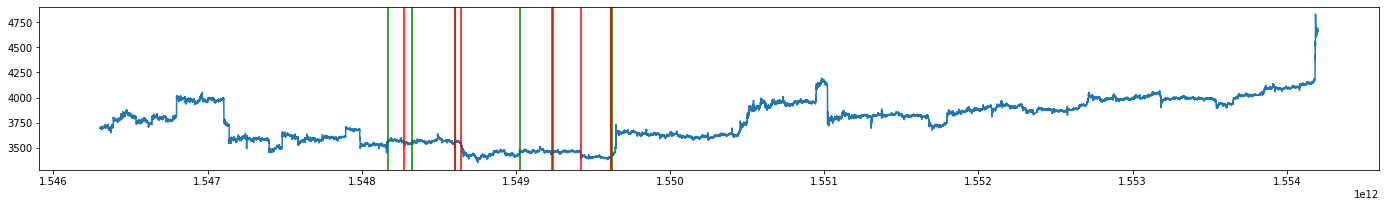

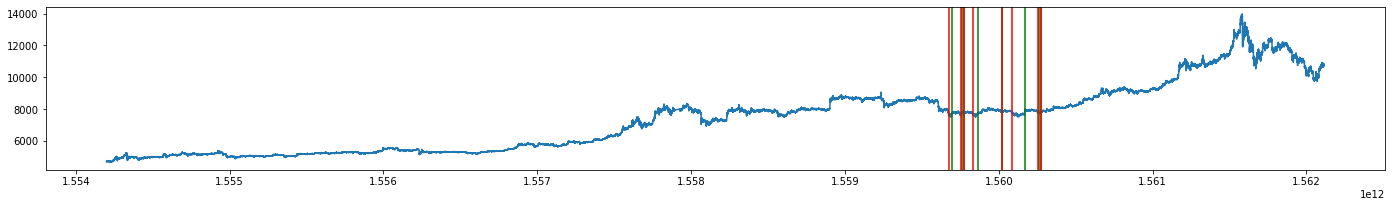

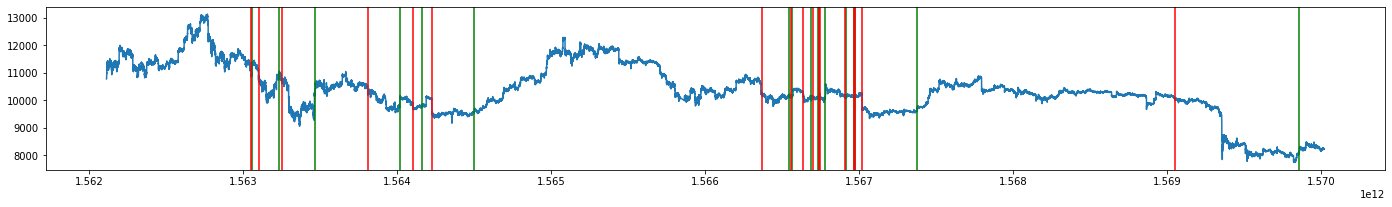

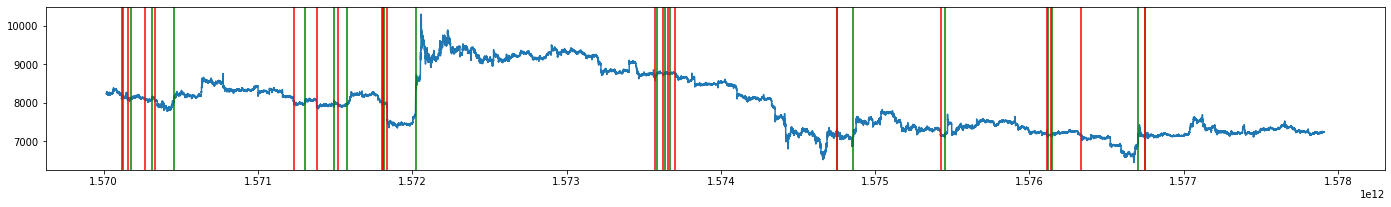

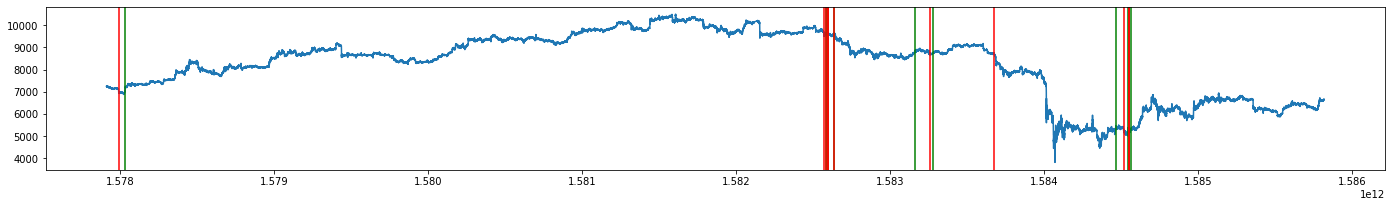

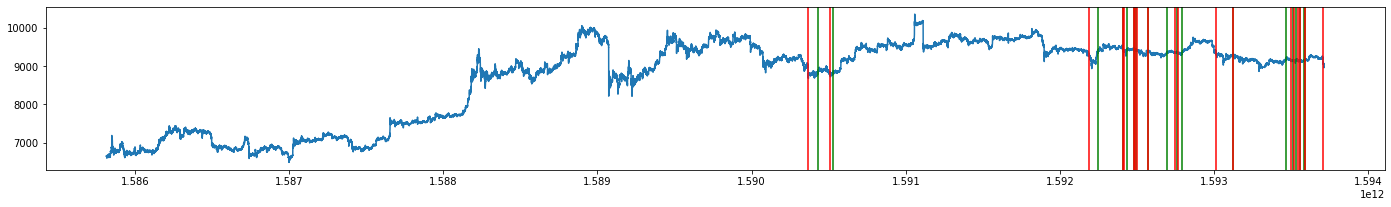

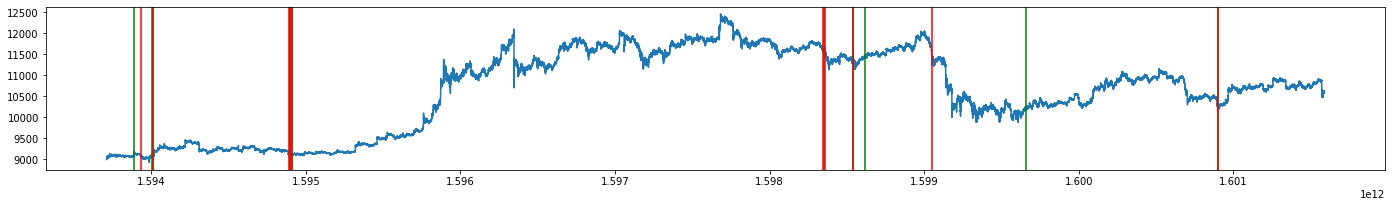

{'money': 7.773, 'bets': 383.0, 'acc': 0.337}


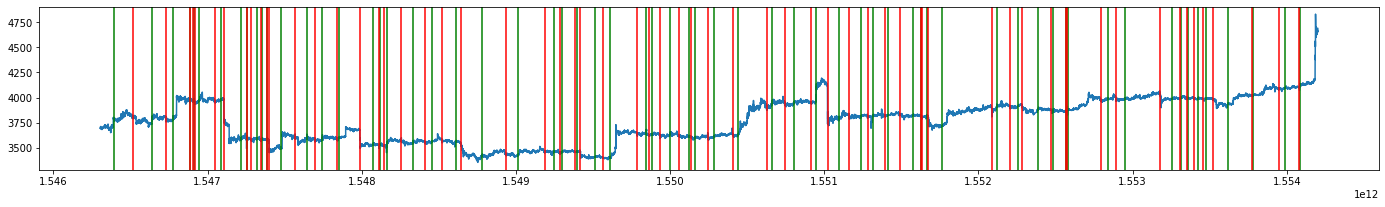

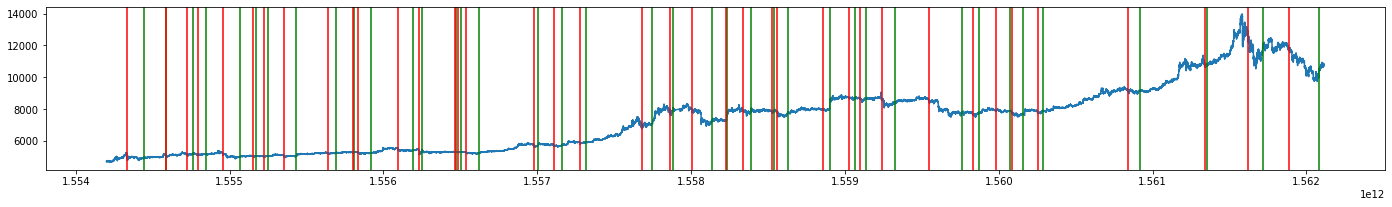

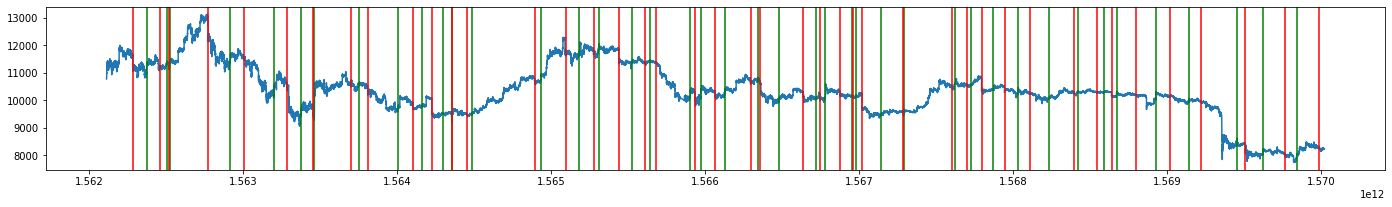

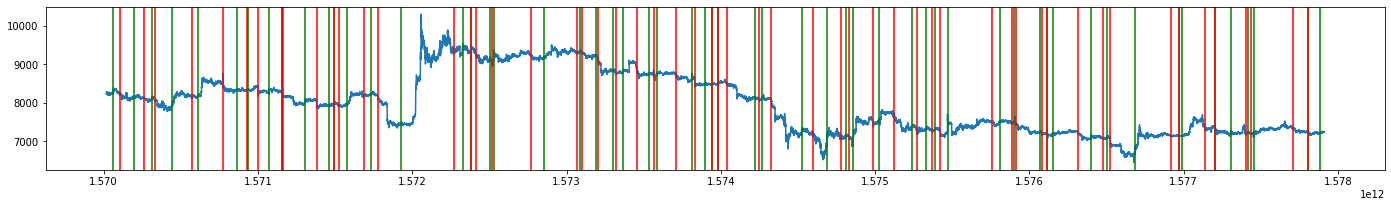

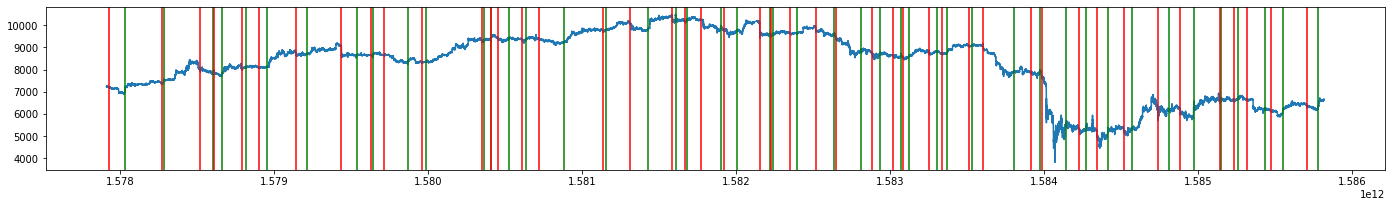

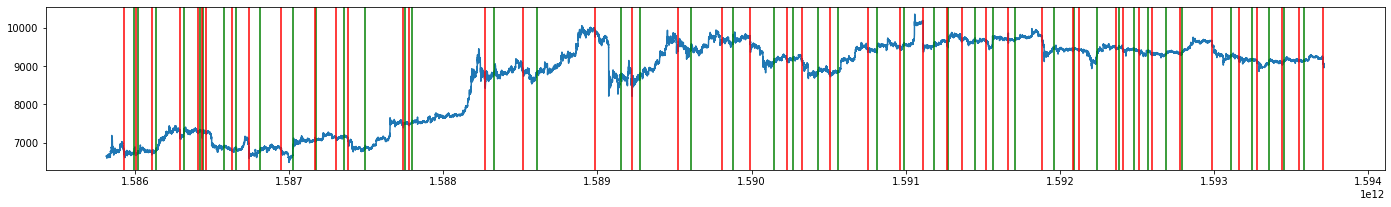

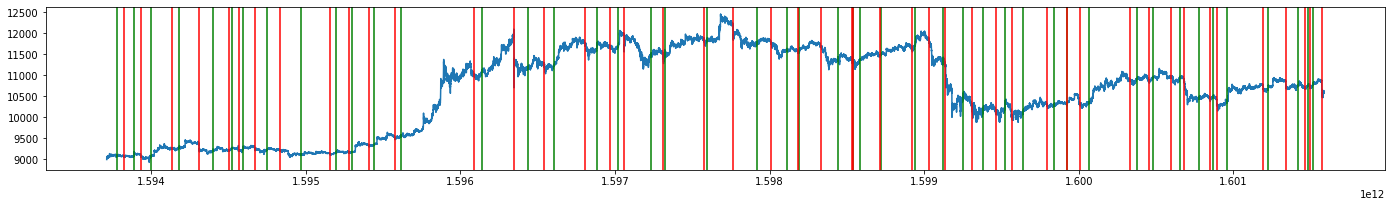

{'money': 7.46, 'bets': 13.0, 'acc': 0.538}


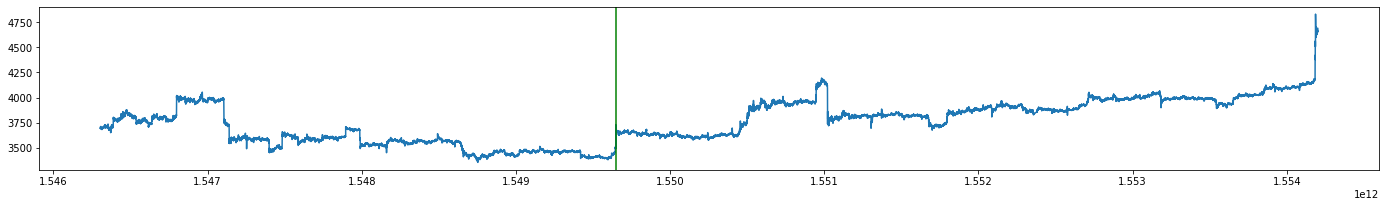

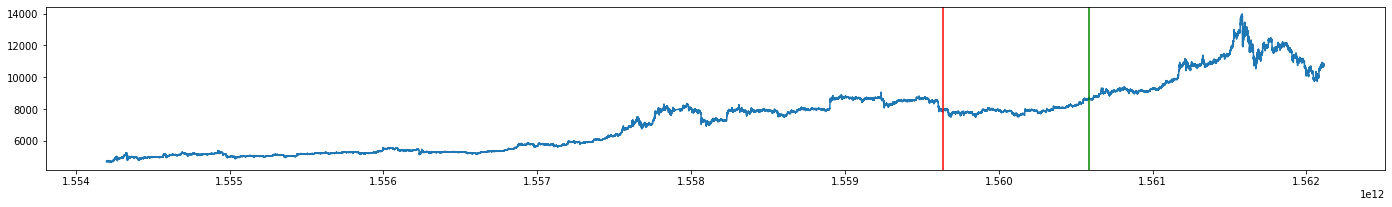

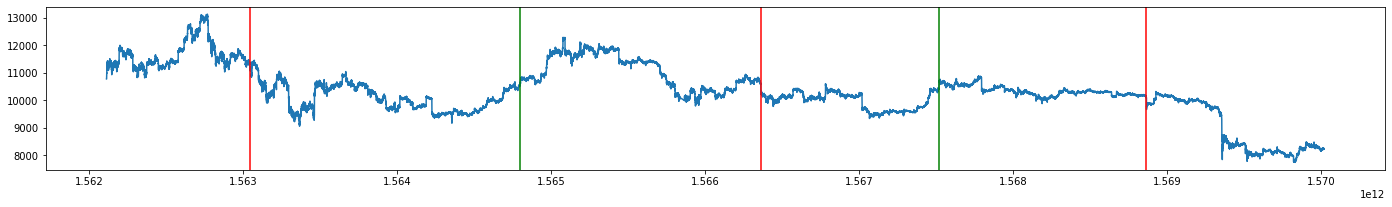

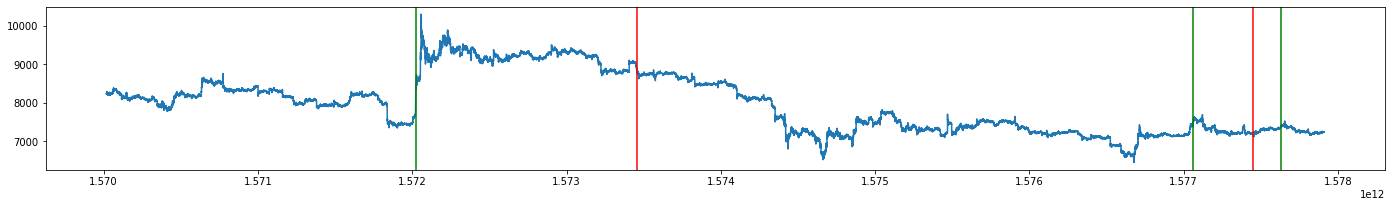

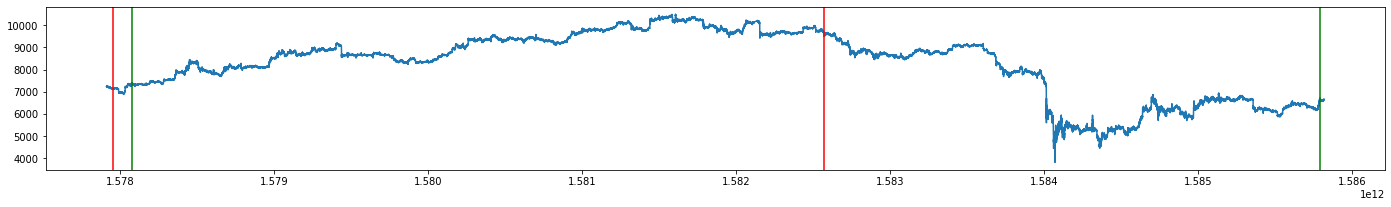

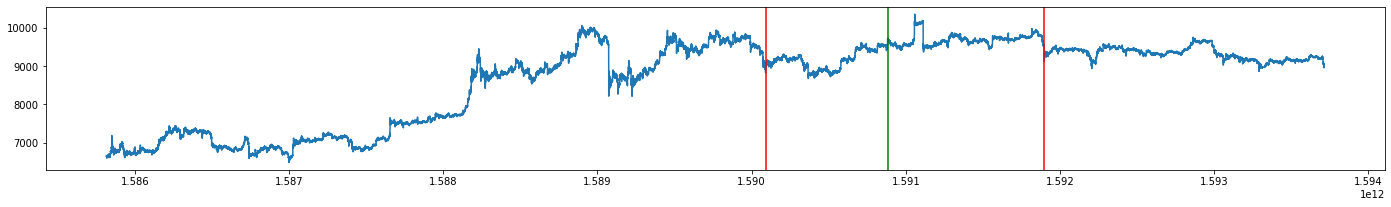

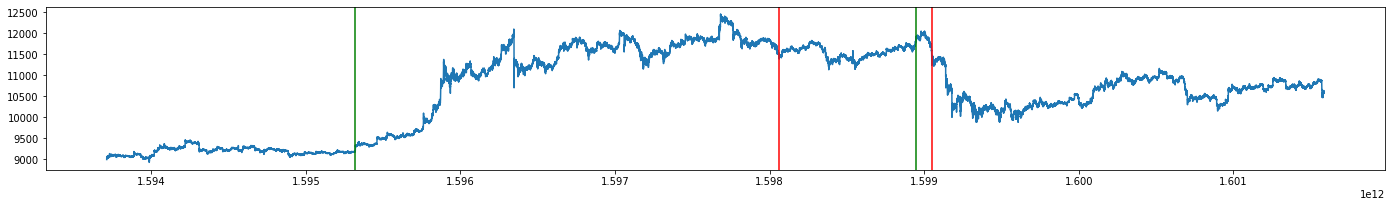

In [33]:
for strategy in [
    (28800, 0.18, 0.12), (1440, 0.76, 0.03), (28800, 0.91, 0.20)
]:
    lookup, buy_alpha, sell_alpha = strategy
    data_df = add_alpha(raw_data_df, lookup)
    data_df = add_signal(data_df, buy_alpha, sell_alpha)
    ev = evaluation(data_df) 
    print({'money' : ev[0], 'bets' : ev[2], 'acc' : ev[1]})
    plot_bets(data_df, 8)


{'money': 4.464, 'bets': 43.0, 'acc': 0.465}


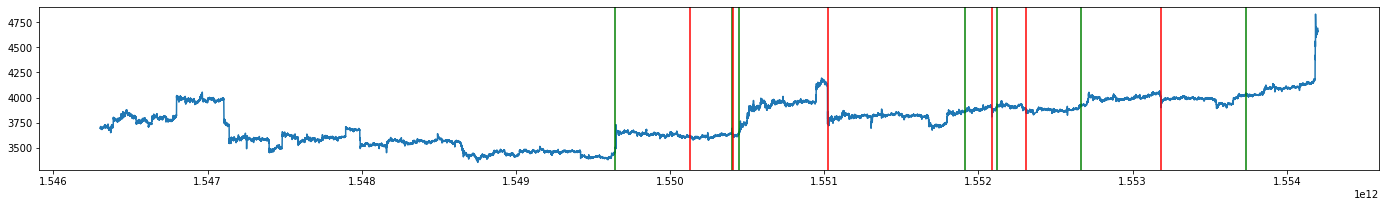

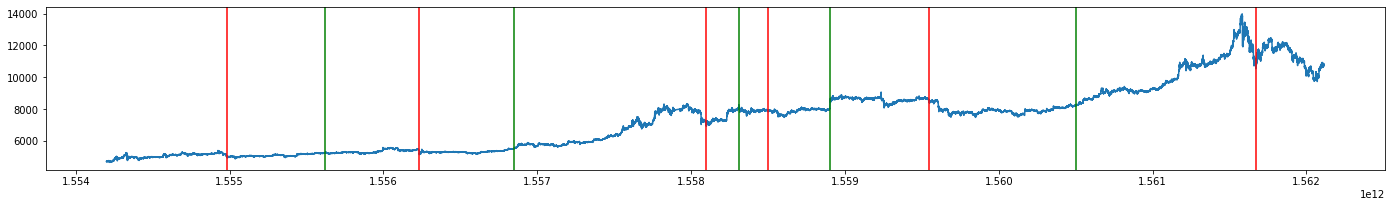

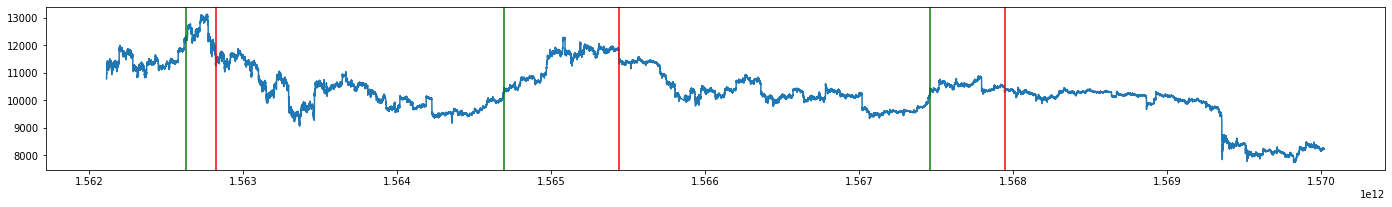

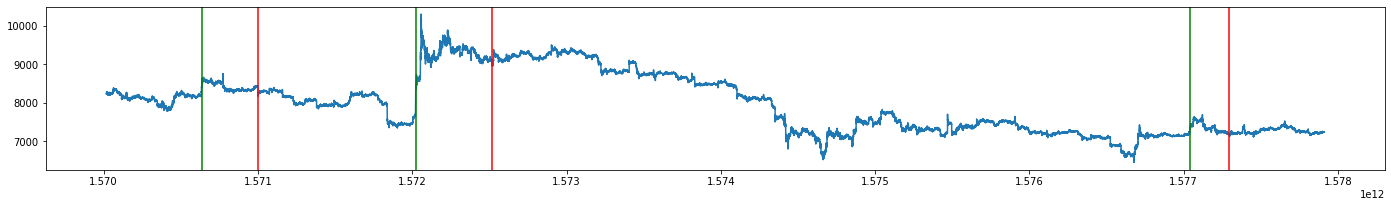

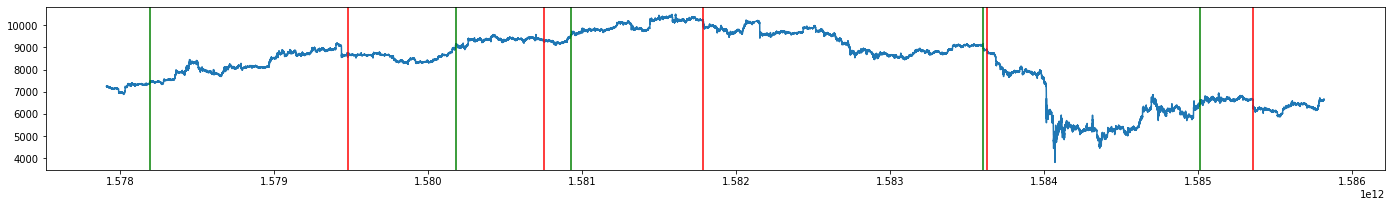

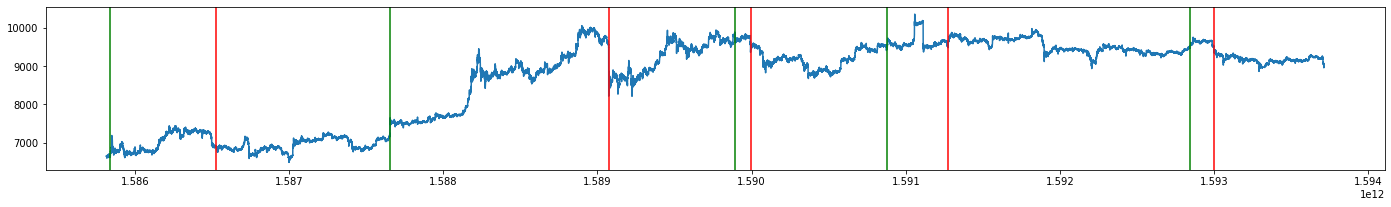

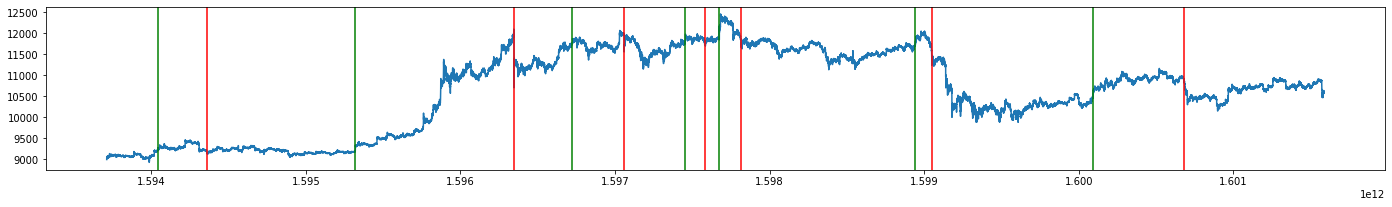

In [34]:
for strategy in [
    (15000, 0.98, 0.50)
]:
    lookup, buy_alpha, sell_alpha = strategy
    data_df = add_alpha(raw_data_df, lookup)
    data_df = add_signal(data_df, buy_alpha, sell_alpha)
    ev = evaluation(data_df) 
    print({'money' : ev[0], 'bets' : ev[2], 'acc' : ev[1]})
    plot_bets(data_df, 8)
